<a href="https://colab.research.google.com/github/quanndm/kltn/blob/main/notebooks/training/liver_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b main  https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 3251, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 3251 (delta 88), reused 59 (delta 29), pack-reused 3117 (from 3)
Receiving objects: 100% (3251/3251), 99.09 MiB | 18.26 MiB/s, done.
Resolving deltas: 100% (2226/2226), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage1
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results_stage_1

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 4) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.14% complete (down: 14496.0 kB/s up: 421.5 kB/s peers: 8) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.ph

## Load data

In [ ]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [8]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=2, pin_memory=True, drop_last=True,  prefetch_factor=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=2,  prefetch_factor=2)

## visualize

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_sample(image_tensor, label_tensor):
    image_np = image_tensor.squeeze().cpu().numpy()
    label_np = label_tensor.squeeze().cpu().numpy()

    slide_index = image_np.shape[0] // 2

    # Lấy slice tại slice_index
    image_slice = image_np[slide_index, :, :]
    label_slice = label_np[slide_index, :, :]

    # Vẽ ảnh
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(image_slice, cmap='gray')
    axes[0].set_title("Image Slice")
    axes[0].axis('off')

    axes[1].imshow(label_slice, cmap='gray')
    axes[1].set_title("Label Slice")
    axes[1].axis('off')

    plt.show()


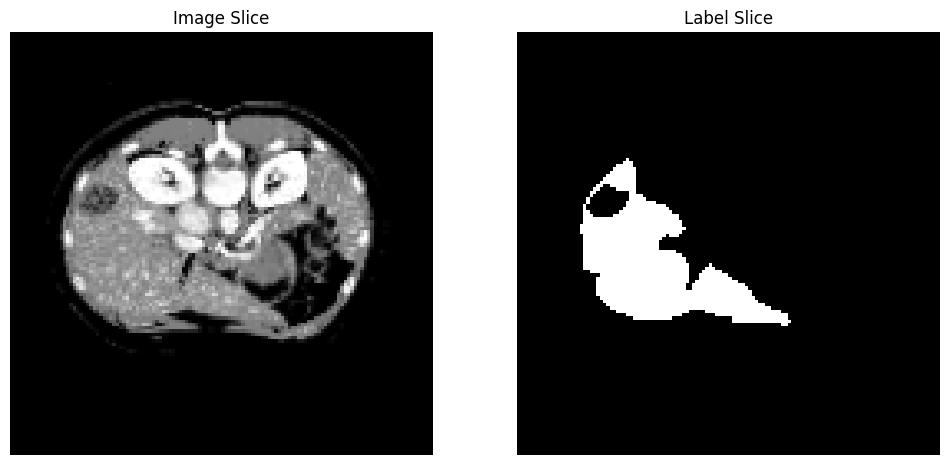

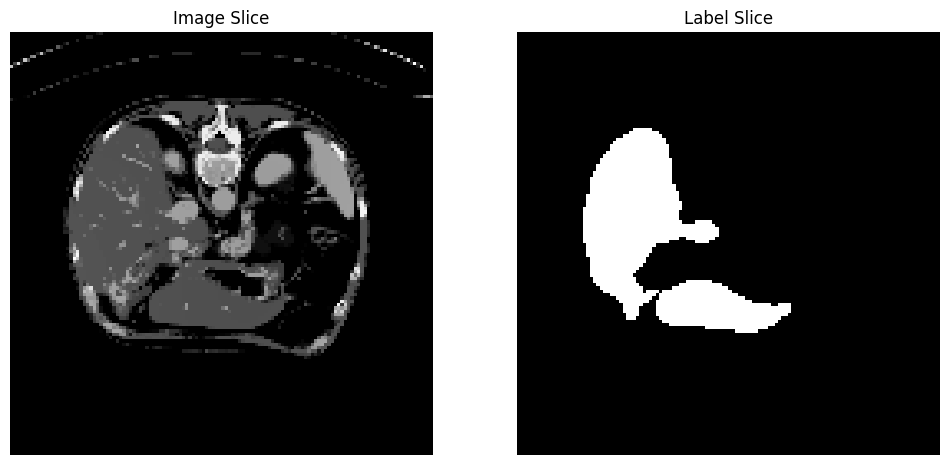

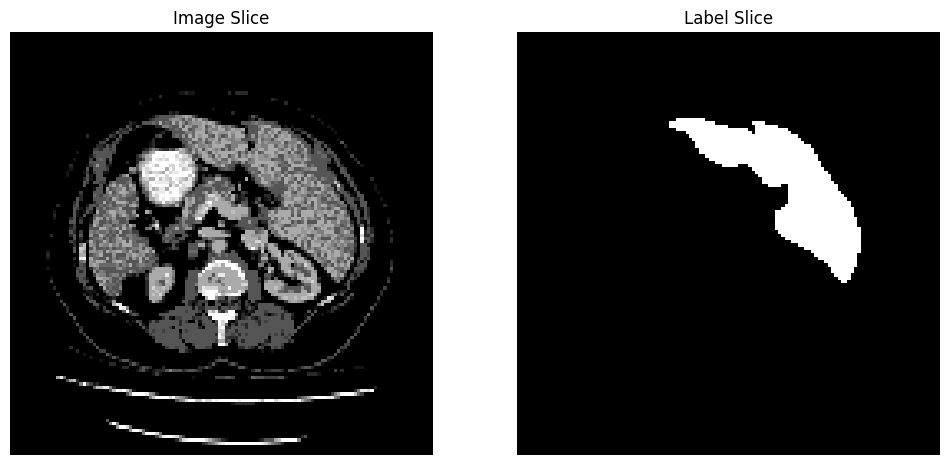

In [ ]:
i = 0
for batch in train_loader:
    i+=1
    image, label = batch["image"], batch["label"]
    plot_sample(image, label)

    if i == 3:
      break

## Training

In [9]:
model = ModelFactory.get_model("unet3d_resnextcot_mcb",in_channels=1, n_classes=1, n_channels=16).to(device)

In [ ]:
criterion = DiceLossWSigmoid().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [ ]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    loss_epochs,
    trains_epoch,
    ious_liver,
    precisions_liver,
    recalls_liver,
    time_tmp
) = trainer_stage1(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
    post_fix="liver_mcb"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.8707 time 23.55s
Epoch 1/100 2/105 loss: 0.8607 time 1.21s
Epoch 1/100 3/105 loss: 0.8518 time 1.25s
Epoch 1/100 4/105 loss: 0.8456 time 1.23s
Epoch 1/100 5/105 loss: 0.8328 time 15.53s
Epoch 1/100 6/105 loss: 0.8283 time 2.13s
Epoch 1/100 7/105 loss: 0.8232 time 14.67s
Epoch 1/100 8/105 loss: 0.8200 time 3.18s
Epoch 1/100 9/105 loss: 0.8176 time 1.18s
Epoch 1/100 10/105 loss: 0.8154 time 8.27s
Epoch 1/100 11/105 loss: 0.8139 time 1.20s
Epoch 1/100 12/105 loss: 0.8115 time 10.17s
Epoch 1/100 13/105 loss: 0.8089 time 1.21s
Epoch 1/100 14/105 loss: 0.8067 time 2.35s
Epoch 1/100 15/105 loss: 0.8048 time 5.07s
Epoch 1/100 16/105 loss: 0.8035 time 1.20s
Epoch 1/100 17/105 loss: 0.8017 time 11.77s
Epoch 1/100 18/105 loss: 0.8003 time 1.20s
Epoch 1/100 19/105 loss: 0.7985 time 18.90s
Epoch 1/100 20/105 loss: 0.7969 time 1.29s
Epoch 1/100 21/105 loss: 0.7955 time 8.70s
Epoch 1/100 22/105 loss: 0.7942 time 1.27s
Epoch 1/100 23/105 loss: 0.7931 time 8.45s
Epoch 1/100 24

Final training epochs: 1/100 ---[loss: 0.5480] ---[time 491.00s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.5480] ---[time 491.00s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.5480 time 1.30s


Val 1/100 1/26, Dice_Liver: 0.589461, time 24.78s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Liver: 0.589461, time 24.78s
Val 1/100 2/26, Dice_Liver: 0.790053, time 0.22s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Liver: 0.790053, time 0.22s
Val 1/100 3/26, Dice_Liver: 0.821021, time 13.62s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Liver: 0.821021, time 13.62s
Val 1/100 4/26, Dice_Liver: 0.702369, time 0.21s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Liver: 0.702369, time 0.21s
Val 1/100 5/26, Dice_Liver: 0.759741, time 14.01s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Liver: 0.759741, time 14.01s
Val 1/100 6/26, Dice_Liver: 0.752104, time 0.18s
INFO:kltn.utils.logger:Val 1/100 6/26, Dice_Liver: 0.752104, time 0.18s
Val 1/100 7/26, Dice_Liver: 0.653425, time 12.03s
INFO:kltn.utils.logger:Val 1/100 7/26, Dice_Liver: 0.653425, time 12.03s
Val 1/100 8/26, Dice_Liver: 0.644107, time 0.17s
INFO:kltn.utils.logger:Val 1/100 8/26, Dice_Liver: 0.644107, time 0.17s
Val 1/100 9/26, Dice_Liv

New best (0.000000 --> 0.763662). At epoch 1


Epoch 1/100 ---[loss: 0.5480] ---[val_dice: 0.763662] ---[time 136.92s]
INFO:kltn.utils.logger:Epoch 1/100 ---[loss: 0.5480] ---[val_dice: 0.763662] ---[time 136.92s]

==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/100 1/105 loss: 0.1638 time 5.15s
Epoch 2/100 2/105 loss: 0.1670 time 1.28s
Epoch 2/100 3/105 loss: 0.1844 time 15.62s
Epoch 2/100 4/105 loss: 0.1896 time 1.27s
Epoch 2/100 5/105 loss: 0.2097 time 5.15s
Epoch 2/100 6/105 loss: 0.2009 time 1.30s
Epoch 2/100 7/105 loss: 0.2148 time 12.86s
Epoch 2/100 8/105 loss: 0.2078 time 1.29s
Epoch 2/100 9/105 loss: 0.2075 time 13.28s
Epoch 2/100 10/105 loss: 0.2113 time 1.29s
Epoch 2/100 11/105 loss: 0.2059 time 1.32s
Epoch 2/100 12/105 loss: 0.2132 time 1.35s
Epoch 2/100 13/105 loss: 0.2171 time 4.61s
Epoch 2/100 14/105 loss: 0.2270 time 1.38s
Epoch 2/100 15/105 loss: 0.2246 time 1.32s
Epoch 2/100 16/105 loss: 0.2190 time 1.34s
Epoch 2/100 17/105 loss: 0.2270 time 6.50s
Epoch 2/100 18/105 loss: 0.2353 time 1.32s
Epoch 2/100 19/105 loss: 0.2441 time 4.93s
Epoch 2/100 20/105 loss: 0.2423 time 1.32s
Epoch 2/100 21/105 loss: 0.2401 time 7.33s
Epoch 2/100 22/105 loss: 0.2617 time 5.37s
Epoch 2/100 23/105 loss: 0.2554 time 2.26s
Epoch 2/100 24/10

Final training epochs: 2/100 ---[loss: 0.1978] ---[time 500.69s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.1978] ---[time 500.69s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.1978 time 4.80s


Val 2/100 1/26, Dice_Liver: 0.717404, time 21.26s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Liver: 0.717404, time 21.26s
Val 2/100 2/26, Dice_Liver: 0.717476, time 0.17s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Liver: 0.717476, time 0.17s
Val 2/100 3/26, Dice_Liver: 0.776860, time 18.87s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Liver: 0.776860, time 18.87s
Val 2/100 4/26, Dice_Liver: 0.859394, time 0.17s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Liver: 0.859394, time 0.17s
Val 2/100 5/26, Dice_Liver: 0.768207, time 22.31s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Liver: 0.768207, time 22.31s
Val 2/100 6/26, Dice_Liver: 0.695558, time 0.18s
INFO:kltn.utils.logger:Val 2/100 6/26, Dice_Liver: 0.695558, time 0.18s
Val 2/100 7/26, Dice_Liver: 0.752789, time 15.54s
INFO:kltn.utils.logger:Val 2/100 7/26, Dice_Liver: 0.752789, time 15.54s
Val 2/100 8/26, Dice_Liver: 0.824940, time 0.19s
INFO:kltn.utils.logger:Val 2/100 8/26, Dice_Liver: 0.824940, time 0.19s
Val 2/100 9/26, Dice_Liv

New best (0.763662 --> 0.785559). At epoch 2
Epoch 3/100 1/105 loss: 0.2607 time 8.98s
Epoch 3/100 2/105 loss: 0.2070 time 3.58s
Epoch 3/100 3/105 loss: 0.1736 time 8.08s
Epoch 3/100 4/105 loss: 0.1604 time 4.57s
Epoch 3/100 5/105 loss: 0.1649 time 1.29s
Epoch 3/100 6/105 loss: 0.1608 time 3.30s
Epoch 3/100 7/105 loss: 0.1792 time 11.49s
Epoch 3/100 8/105 loss: 0.1742 time 1.29s
Epoch 3/100 9/105 loss: 0.1722 time 7.24s
Epoch 3/100 10/105 loss: 0.1726 time 1.29s
Epoch 3/100 11/105 loss: 0.1795 time 7.05s
Epoch 3/100 12/105 loss: 0.1871 time 1.29s
Epoch 3/100 13/105 loss: 0.1809 time 11.71s
Epoch 3/100 14/105 loss: 0.1761 time 1.28s
Epoch 3/100 15/105 loss: 0.1814 time 7.28s
Epoch 3/100 16/105 loss: 0.1801 time 1.39s
Epoch 3/100 17/105 loss: 0.1749 time 1.34s
Epoch 3/100 18/105 loss: 0.1769 time 1.97s
Epoch 3/100 19/105 loss: 0.1744 time 13.10s
Epoch 3/100 20/105 loss: 0.1739 time 1.29s
Epoch 3/100 21/105 loss: 0.1744 time 2.35s
Epoch 3/100 22/105 loss: 0.1731 time 1.67s
Epoch 3/100 23/

Final training epochs: 3/100 ---[loss: 0.1639] ---[time 478.62s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.1639] ---[time 478.62s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.1639 time 2.55s


Val 3/100 1/26, Dice_Liver: 0.846980, time 22.23s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Liver: 0.846980, time 22.23s
Val 3/100 2/26, Dice_Liver: 0.853909, time 0.21s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Liver: 0.853909, time 0.21s
Val 3/100 3/26, Dice_Liver: 0.858025, time 17.77s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Liver: 0.858025, time 17.77s
Val 3/100 4/26, Dice_Liver: 0.688659, time 0.18s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Liver: 0.688659, time 0.18s
Val 3/100 5/26, Dice_Liver: 0.823501, time 15.63s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Liver: 0.823501, time 15.63s
Val 3/100 6/26, Dice_Liver: 0.849556, time 0.18s
INFO:kltn.utils.logger:Val 3/100 6/26, Dice_Liver: 0.849556, time 0.18s
Val 3/100 7/26, Dice_Liver: 0.808032, time 13.58s
INFO:kltn.utils.logger:Val 3/100 7/26, Dice_Liver: 0.808032, time 13.58s
Val 3/100 8/26, Dice_Liver: 0.730374, time 0.18s
INFO:kltn.utils.logger:Val 3/100 8/26, Dice_Liver: 0.730374, time 0.18s
Val 3/100 9/26, Dice_Liv

New best (0.785559 --> 0.838786). At epoch 3
Epoch 4/100 1/105 loss: 0.0948 time 5.27s
Epoch 4/100 2/105 loss: 0.0860 time 7.46s
Epoch 4/100 3/105 loss: 0.0943 time 11.57s
Epoch 4/100 4/105 loss: 0.1315 time 1.33s
Epoch 4/100 5/105 loss: 0.1186 time 5.87s
Epoch 4/100 6/105 loss: 0.1127 time 1.28s
Epoch 4/100 7/105 loss: 0.1166 time 2.02s
Epoch 4/100 8/105 loss: 0.1272 time 12.57s
Epoch 4/100 9/105 loss: 0.1286 time 1.30s
Epoch 4/100 10/105 loss: 0.1234 time 7.82s
Epoch 4/100 11/105 loss: 0.1216 time 1.29s
Epoch 4/100 12/105 loss: 0.1193 time 1.30s
Epoch 4/100 13/105 loss: 0.1161 time 1.32s
Epoch 4/100 14/105 loss: 0.1136 time 2.60s
Epoch 4/100 15/105 loss: 0.1159 time 9.35s
Epoch 4/100 16/105 loss: 0.1141 time 1.30s
Epoch 4/100 17/105 loss: 0.1129 time 15.68s
Epoch 4/100 18/105 loss: 0.1114 time 1.27s
Epoch 4/100 19/105 loss: 0.1109 time 1.91s
Epoch 4/100 20/105 loss: 0.1122 time 5.55s
Epoch 4/100 21/105 loss: 0.1132 time 1.30s
Epoch 4/100 22/105 loss: 0.1149 time 12.95s
Epoch 4/100 23

Final training epochs: 4/100 ---[loss: 0.1165] ---[time 482.03s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.1165] ---[time 482.03s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.1165 time 9.51s


Val 4/100 1/26, Dice_Liver: 0.902524, time 20.72s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Liver: 0.902524, time 20.72s
Val 4/100 2/26, Dice_Liver: 0.897193, time 0.17s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Liver: 0.897193, time 0.17s
Val 4/100 3/26, Dice_Liver: 0.895084, time 18.41s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Liver: 0.895084, time 18.41s
Val 4/100 4/26, Dice_Liver: 0.776689, time 0.17s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Liver: 0.776689, time 0.17s
Val 4/100 5/26, Dice_Liver: 0.867683, time 21.59s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Liver: 0.867683, time 21.59s
Val 4/100 6/26, Dice_Liver: 0.883520, time 0.20s
INFO:kltn.utils.logger:Val 4/100 6/26, Dice_Liver: 0.883520, time 0.20s
Val 4/100 7/26, Dice_Liver: 0.887495, time 14.79s
INFO:kltn.utils.logger:Val 4/100 7/26, Dice_Liver: 0.887495, time 14.79s
Val 4/100 8/26, Dice_Liver: 0.831437, time 0.17s
INFO:kltn.utils.logger:Val 4/100 8/26, Dice_Liver: 0.831437, time 0.17s
Val 4/100 9/26, Dice_Liv

New best (0.838786 --> 0.882067). At epoch 4
Epoch 5/100 1/105 loss: 0.0844 time 10.06s
Epoch 5/100 2/105 loss: 0.0798 time 1.29s
Epoch 5/100 3/105 loss: 0.0793 time 4.79s
Epoch 5/100 4/105 loss: 0.0969 time 1.29s
Epoch 5/100 5/105 loss: 0.0981 time 14.17s
Epoch 5/100 6/105 loss: 0.0973 time 1.29s
Epoch 5/100 7/105 loss: 0.1025 time 7.23s
Epoch 5/100 8/105 loss: 0.1059 time 1.29s
Epoch 5/100 9/105 loss: 0.1053 time 1.84s
Epoch 5/100 10/105 loss: 0.1011 time 1.32s
Epoch 5/100 11/105 loss: 0.0994 time 4.59s
Epoch 5/100 12/105 loss: 0.1016 time 1.32s
Epoch 5/100 13/105 loss: 0.0989 time 1.38s
Epoch 5/100 14/105 loss: 0.0973 time 1.45s
Epoch 5/100 15/105 loss: 0.1057 time 9.18s
Epoch 5/100 16/105 loss: 0.1097 time 1.28s
Epoch 5/100 17/105 loss: 0.1088 time 8.20s
Epoch 5/100 18/105 loss: 0.1104 time 1.28s
Epoch 5/100 19/105 loss: 0.1157 time 4.86s
Epoch 5/100 20/105 loss: 0.1135 time 1.33s
Epoch 5/100 21/105 loss: 0.1125 time 9.67s
Epoch 5/100 22/105 loss: 0.1114 time 1.27s
Epoch 5/100 23/1

Final training epochs: 5/100 ---[loss: 0.1136] ---[time 497.82s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.1136] ---[time 497.82s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.1136 time 1.29s


Val 5/100 1/26, Dice_Liver: 0.917007, time 22.56s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Liver: 0.917007, time 22.56s
Val 5/100 2/26, Dice_Liver: 0.904364, time 0.19s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Liver: 0.904364, time 0.19s
Val 5/100 3/26, Dice_Liver: 0.897158, time 18.72s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Liver: 0.897158, time 18.72s
Val 5/100 4/26, Dice_Liver: 0.855790, time 0.19s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Liver: 0.855790, time 0.19s
Val 5/100 5/26, Dice_Liver: 0.892633, time 15.60s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Liver: 0.892633, time 15.60s
Val 5/100 6/26, Dice_Liver: 0.890647, time 0.21s
INFO:kltn.utils.logger:Val 5/100 6/26, Dice_Liver: 0.890647, time 0.21s
Val 5/100 7/26, Dice_Liver: 0.909672, time 13.35s
INFO:kltn.utils.logger:Val 5/100 7/26, Dice_Liver: 0.909672, time 13.35s
Val 5/100 8/26, Dice_Liver: 0.847499, time 0.18s
INFO:kltn.utils.logger:Val 5/100 8/26, Dice_Liver: 0.847499, time 0.18s
Val 5/100 9/26, Dice_Liv

New best (0.882067 --> 0.895714). At epoch 5
Epoch 6/100 1/105 loss: 0.0619 time 16.13s
Epoch 6/100 2/105 loss: 0.0607 time 1.28s
Epoch 6/100 3/105 loss: 0.0773 time 15.01s
Epoch 6/100 4/105 loss: 0.0843 time 1.27s
Epoch 6/100 5/105 loss: 0.0794 time 10.91s
Epoch 6/100 6/105 loss: 0.0785 time 1.29s
Epoch 6/100 7/105 loss: 0.0758 time 5.87s
Epoch 6/100 8/105 loss: 0.0749 time 1.29s
Epoch 6/100 9/105 loss: 0.0746 time 19.98s
Epoch 6/100 10/105 loss: 0.1378 time 1.34s
Epoch 6/100 11/105 loss: 0.1317 time 3.62s
Epoch 6/100 12/105 loss: 0.1272 time 1.31s
Epoch 6/100 13/105 loss: 0.1237 time 4.10s
Epoch 6/100 14/105 loss: 0.1231 time 1.30s
Epoch 6/100 15/105 loss: 0.1271 time 9.94s
Epoch 6/100 16/105 loss: 0.1332 time 1.29s
Epoch 6/100 17/105 loss: 0.1306 time 22.21s
Epoch 6/100 18/105 loss: 0.1311 time 1.28s
Epoch 6/100 19/105 loss: 0.1303 time 20.48s
Epoch 6/100 20/105 loss: 0.1279 time 1.28s
Epoch 6/100 21/105 loss: 0.1282 time 8.09s
Epoch 6/100 22/105 loss: 0.1265 time 1.28s
Epoch 6/100 

Final training epochs: 6/100 ---[loss: 0.1217] ---[time 533.70s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.1217] ---[time 533.70s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.1217 time 1.30s


Val 6/100 1/26, Dice_Liver: 0.912718, time 22.91s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Liver: 0.912718, time 22.91s
Val 6/100 2/26, Dice_Liver: 0.885405, time 0.19s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Liver: 0.885405, time 0.19s
Val 6/100 3/26, Dice_Liver: 0.879739, time 21.21s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Liver: 0.879739, time 21.21s
Val 6/100 4/26, Dice_Liver: 0.856251, time 0.19s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Liver: 0.856251, time 0.19s
Val 6/100 5/26, Dice_Liver: 0.877479, time 22.70s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Liver: 0.877479, time 22.70s
Val 6/100 6/26, Dice_Liver: 0.885432, time 0.19s
INFO:kltn.utils.logger:Val 6/100 6/26, Dice_Liver: 0.885432, time 0.19s
Val 6/100 7/26, Dice_Liver: 0.844653, time 14.81s
INFO:kltn.utils.logger:Val 6/100 7/26, Dice_Liver: 0.844653, time 14.81s
Val 6/100 8/26, Dice_Liver: 0.838229, time 0.17s
INFO:kltn.utils.logger:Val 6/100 8/26, Dice_Liver: 0.838229, time 0.17s
Val 6/100 9/26, Dice_Liv

Epoch 7/100 1/105 loss: 0.1122 time 7.19s
Epoch 7/100 2/105 loss: 0.1278 time 14.32s
Epoch 7/100 3/105 loss: 0.1063 time 4.30s
Epoch 7/100 4/105 loss: 0.0981 time 1.28s
Epoch 7/100 5/105 loss: 0.0929 time 8.68s
Epoch 7/100 6/105 loss: 0.0937 time 1.32s
Epoch 7/100 7/105 loss: 0.0876 time 3.63s
Epoch 7/100 8/105 loss: 0.0865 time 1.29s
Epoch 7/100 9/105 loss: 0.0957 time 5.09s
Epoch 7/100 10/105 loss: 0.0974 time 1.31s
Epoch 7/100 11/105 loss: 0.0950 time 13.58s
Epoch 7/100 12/105 loss: 0.0932 time 1.90s
Epoch 7/100 13/105 loss: 0.0943 time 12.74s
Epoch 7/100 14/105 loss: 0.0929 time 3.39s
Epoch 7/100 15/105 loss: 0.0955 time 1.36s
Epoch 7/100 16/105 loss: 0.0946 time 1.34s
Epoch 7/100 17/105 loss: 0.0930 time 1.30s
Epoch 7/100 18/105 loss: 0.0936 time 1.32s
Epoch 7/100 19/105 loss: 0.0937 time 10.96s
Epoch 7/100 20/105 loss: 0.0922 time 1.29s
Epoch 7/100 21/105 loss: 0.0948 time 9.60s
Epoch 7/100 22/105 loss: 0.0933 time 1.27s
Epoch 7/100 23/105 loss: 0.0929 time 5.69s
Epoch 7/100 24/1

Final training epochs: 7/100 ---[loss: 0.1019] ---[time 509.44s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.1019] ---[time 509.44s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.1019 time 2.36s


Val 7/100 1/26, Dice_Liver: 0.925050, time 19.40s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Liver: 0.925050, time 19.40s
Val 7/100 2/26, Dice_Liver: 0.906649, time 0.20s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Liver: 0.906649, time 0.20s
Val 7/100 3/26, Dice_Liver: 0.910958, time 18.62s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Liver: 0.910958, time 18.62s
Val 7/100 4/26, Dice_Liver: 0.823579, time 0.19s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Liver: 0.823579, time 0.19s
Val 7/100 5/26, Dice_Liver: 0.893264, time 16.32s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Liver: 0.893264, time 16.32s
Val 7/100 6/26, Dice_Liver: 0.886384, time 0.18s
INFO:kltn.utils.logger:Val 7/100 6/26, Dice_Liver: 0.886384, time 0.18s
Val 7/100 7/26, Dice_Liver: 0.912724, time 15.03s
INFO:kltn.utils.logger:Val 7/100 7/26, Dice_Liver: 0.912724, time 15.03s
Val 7/100 8/26, Dice_Liver: 0.823526, time 0.18s
INFO:kltn.utils.logger:Val 7/100 8/26, Dice_Liver: 0.823526, time 0.18s
Val 7/100 9/26, Dice_Liv

New best (0.895714 --> 0.899397). At epoch 7
Epoch 8/100 1/105 loss: 0.0657 time 4.17s
Epoch 8/100 2/105 loss: 0.0586 time 2.24s
Epoch 8/100 3/105 loss: 0.0718 time 1.28s
Epoch 8/100 4/105 loss: 0.0753 time 17.78s
Epoch 8/100 5/105 loss: 0.0792 time 1.31s
Epoch 8/100 6/105 loss: 0.0766 time 4.94s
Epoch 8/100 7/105 loss: 0.0818 time 1.38s
Epoch 8/100 8/105 loss: 0.0795 time 13.38s
Epoch 8/100 9/105 loss: 0.0926 time 1.29s
Epoch 8/100 10/105 loss: 0.0897 time 8.87s
Epoch 8/100 11/105 loss: 0.0875 time 1.31s
Epoch 8/100 12/105 loss: 0.0865 time 3.29s
Epoch 8/100 13/105 loss: 0.0881 time 2.96s
Epoch 8/100 14/105 loss: 0.0859 time 10.80s
Epoch 8/100 15/105 loss: 0.0845 time 1.29s
Epoch 8/100 16/105 loss: 0.0850 time 15.04s
Epoch 8/100 17/105 loss: 0.0860 time 1.28s
Epoch 8/100 18/105 loss: 0.0858 time 14.31s
Epoch 8/100 19/105 loss: 0.0854 time 1.28s
Epoch 8/100 20/105 loss: 0.0846 time 1.28s
Epoch 8/100 21/105 loss: 0.0852 time 1.30s
Epoch 8/100 22/105 loss: 0.0844 time 1.29s
Epoch 8/100 2

Final training epochs: 8/100 ---[loss: 0.0845] ---[time 506.68s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.0845] ---[time 506.68s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.0845 time 1.30s


Val 8/100 1/26, Dice_Liver: 0.916138, time 22.24s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Liver: 0.916138, time 22.24s
Val 8/100 2/26, Dice_Liver: 0.882654, time 0.18s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Liver: 0.882654, time 0.18s
Val 8/100 3/26, Dice_Liver: 0.916270, time 20.13s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Liver: 0.916270, time 20.13s
Val 8/100 4/26, Dice_Liver: 0.877919, time 0.19s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Liver: 0.877919, time 0.19s
Val 8/100 5/26, Dice_Liver: 0.907286, time 22.51s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Liver: 0.907286, time 22.51s
Val 8/100 6/26, Dice_Liver: 0.885084, time 0.18s
INFO:kltn.utils.logger:Val 8/100 6/26, Dice_Liver: 0.885084, time 0.18s
Val 8/100 7/26, Dice_Liver: 0.926316, time 14.28s
INFO:kltn.utils.logger:Val 8/100 7/26, Dice_Liver: 0.926316, time 14.28s
Val 8/100 8/26, Dice_Liver: 0.889060, time 0.19s
INFO:kltn.utils.logger:Val 8/100 8/26, Dice_Liver: 0.889060, time 0.19s
Val 8/100 9/26, Dice_Liv

New best (0.899397 --> 0.913174). At epoch 8
Epoch 9/100 1/105 loss: 0.0678 time 15.17s
Epoch 9/100 2/105 loss: 0.0622 time 1.27s
Epoch 9/100 3/105 loss: 0.0622 time 7.01s
Epoch 9/100 4/105 loss: 0.0686 time 1.37s
Epoch 9/100 5/105 loss: 0.0698 time 2.38s
Epoch 9/100 6/105 loss: 0.0663 time 3.63s
Epoch 9/100 7/105 loss: 0.0669 time 6.35s
Epoch 9/100 8/105 loss: 0.0682 time 1.30s
Epoch 9/100 9/105 loss: 0.0679 time 16.41s
Epoch 9/100 10/105 loss: 0.0679 time 1.29s
Epoch 9/100 11/105 loss: 0.0659 time 5.45s
Epoch 9/100 12/105 loss: 0.0662 time 1.28s
Epoch 9/100 13/105 loss: 0.0681 time 17.74s
Epoch 9/100 14/105 loss: 0.0688 time 1.35s
Epoch 9/100 15/105 loss: 0.0680 time 2.68s
Epoch 9/100 16/105 loss: 0.0682 time 1.31s
Epoch 9/100 17/105 loss: 0.0683 time 1.43s
Epoch 9/100 18/105 loss: 0.0676 time 4.93s
Epoch 9/100 19/105 loss: 0.0683 time 14.52s
Epoch 9/100 20/105 loss: 0.0683 time 1.34s
Epoch 9/100 21/105 loss: 0.0679 time 5.54s
Epoch 9/100 22/105 loss: 0.0758 time 1.27s
Epoch 9/100 23

Final training epochs: 9/100 ---[loss: 0.0836] ---[time 521.82s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.0836] ---[time 521.82s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.0836 time 7.01s


Val 9/100 1/26, Dice_Liver: 0.893886, time 22.27s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Liver: 0.893886, time 22.27s
Val 9/100 2/26, Dice_Liver: 0.920922, time 0.19s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Liver: 0.920922, time 0.19s
Val 9/100 3/26, Dice_Liver: 0.915080, time 19.70s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Liver: 0.915080, time 19.70s
Val 9/100 4/26, Dice_Liver: 0.585344, time 0.17s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Liver: 0.585344, time 0.17s
Val 9/100 5/26, Dice_Liver: 0.883882, time 22.35s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Liver: 0.883882, time 22.35s
Val 9/100 6/26, Dice_Liver: 0.900470, time 0.19s
INFO:kltn.utils.logger:Val 9/100 6/26, Dice_Liver: 0.900470, time 0.19s
Val 9/100 7/26, Dice_Liver: 0.899670, time 14.92s
INFO:kltn.utils.logger:Val 9/100 7/26, Dice_Liver: 0.899670, time 14.92s
Val 9/100 8/26, Dice_Liver: 0.794592, time 0.18s
INFO:kltn.utils.logger:Val 9/100 8/26, Dice_Liver: 0.794592, time 0.18s
Val 9/100 9/26, Dice_Liv

Epoch 10/100 1/105 loss: 0.0612 time 12.97s
Epoch 10/100 2/105 loss: 0.0637 time 1.27s
Epoch 10/100 3/105 loss: 0.0752 time 22.07s
Epoch 10/100 4/105 loss: 0.0738 time 1.27s
Epoch 10/100 5/105 loss: 0.0736 time 4.55s
Epoch 10/100 6/105 loss: 0.0740 time 1.29s
Epoch 10/100 7/105 loss: 0.0706 time 7.28s
Epoch 10/100 8/105 loss: 0.0688 time 1.33s
Epoch 10/100 9/105 loss: 0.0676 time 1.71s
Epoch 10/100 10/105 loss: 0.0674 time 2.88s
Epoch 10/100 11/105 loss: 0.0676 time 1.34s
Epoch 10/100 12/105 loss: 0.0737 time 1.35s
Epoch 10/100 13/105 loss: 0.0741 time 17.95s
Epoch 10/100 14/105 loss: 0.0740 time 1.27s
Epoch 10/100 15/105 loss: 0.0788 time 2.18s
Epoch 10/100 16/105 loss: 0.0787 time 7.62s
Epoch 10/100 17/105 loss: 0.0775 time 1.30s
Epoch 10/100 18/105 loss: 0.0766 time 5.89s
Epoch 10/100 19/105 loss: 0.0764 time 1.28s
Epoch 10/100 20/105 loss: 0.0782 time 13.71s
Epoch 10/100 21/105 loss: 0.0776 time 1.28s
Epoch 10/100 22/105 loss: 0.0783 time 1.37s
Epoch 10/100 23/105 loss: 0.0783 time

Final training epochs: 10/100 ---[loss: 0.0952] ---[time 495.84s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.0952] ---[time 495.84s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.0952 time 1.28s


Val 10/100 1/26, Dice_Liver: 0.904547, time 22.30s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Liver: 0.904547, time 22.30s
Val 10/100 2/26, Dice_Liver: 0.889300, time 0.19s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Liver: 0.889300, time 0.19s
Val 10/100 3/26, Dice_Liver: 0.884675, time 20.22s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Liver: 0.884675, time 20.22s
Val 10/100 4/26, Dice_Liver: 0.832407, time 0.19s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Liver: 0.832407, time 0.19s
Val 10/100 5/26, Dice_Liver: 0.895041, time 23.37s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Liver: 0.895041, time 23.37s
Val 10/100 6/26, Dice_Liver: 0.850758, time 0.18s
INFO:kltn.utils.logger:Val 10/100 6/26, Dice_Liver: 0.850758, time 0.18s
Val 10/100 7/26, Dice_Liver: 0.886041, time 15.27s
INFO:kltn.utils.logger:Val 10/100 7/26, Dice_Liver: 0.886041, time 15.27s
Val 10/100 8/26, Dice_Liver: 0.869614, time 0.17s
INFO:kltn.utils.logger:Val 10/100 8/26, Dice_Liver: 0.869614, time 0.17s
Val 10/1

Epoch 11/100 1/105 loss: 0.2464 time 5.47s
Epoch 11/100 2/105 loss: 0.1627 time 1.28s
Epoch 11/100 3/105 loss: 0.1396 time 15.08s
Epoch 11/100 4/105 loss: 0.1281 time 1.27s
Epoch 11/100 5/105 loss: 0.1132 time 10.73s
Epoch 11/100 6/105 loss: 0.1378 time 1.29s
Epoch 11/100 7/105 loss: 0.1259 time 12.80s
Epoch 11/100 8/105 loss: 0.1217 time 1.28s
Epoch 11/100 9/105 loss: 0.1145 time 4.94s
Epoch 11/100 10/105 loss: 0.1120 time 1.30s
Epoch 11/100 11/105 loss: 0.1128 time 12.58s
Epoch 11/100 12/105 loss: 0.1117 time 1.32s
Epoch 11/100 13/105 loss: 0.1081 time 3.69s
Epoch 11/100 14/105 loss: 0.1067 time 4.43s
Epoch 11/100 15/105 loss: 0.1062 time 1.30s
Epoch 11/100 16/105 loss: 0.1029 time 11.38s
Epoch 11/100 17/105 loss: 0.1003 time 1.31s
Epoch 11/100 18/105 loss: 0.0979 time 2.48s
Epoch 11/100 19/105 loss: 0.0964 time 4.86s
Epoch 11/100 20/105 loss: 0.0961 time 1.36s
Epoch 11/100 21/105 loss: 0.0950 time 16.11s
Epoch 11/100 22/105 loss: 0.0940 time 1.28s
Epoch 11/100 23/105 loss: 0.0951 ti

Final training epochs: 11/100 ---[loss: 0.0783] ---[time 502.48s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.0783] ---[time 502.48s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.0783 time 1.28s


Val 11/100 1/26, Dice_Liver: 0.914511, time 21.95s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Liver: 0.914511, time 21.95s
Val 11/100 2/26, Dice_Liver: 0.902483, time 0.19s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Liver: 0.902483, time 0.19s
Val 11/100 3/26, Dice_Liver: 0.931900, time 20.25s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Liver: 0.931900, time 20.25s
Val 11/100 4/26, Dice_Liver: 0.815528, time 0.19s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Liver: 0.815528, time 0.19s
Val 11/100 5/26, Dice_Liver: 0.909082, time 22.52s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Liver: 0.909082, time 22.52s
Val 11/100 6/26, Dice_Liver: 0.916297, time 0.18s
INFO:kltn.utils.logger:Val 11/100 6/26, Dice_Liver: 0.916297, time 0.18s
Val 11/100 7/26, Dice_Liver: 0.920312, time 14.71s
INFO:kltn.utils.logger:Val 11/100 7/26, Dice_Liver: 0.920312, time 14.71s
Val 11/100 8/26, Dice_Liver: 0.807189, time 0.17s
INFO:kltn.utils.logger:Val 11/100 8/26, Dice_Liver: 0.807189, time 0.17s
Val 11/1

Epoch 12/100 1/105 loss: 0.1388 time 3.94s
Epoch 12/100 2/105 loss: 0.0930 time 6.74s
Epoch 12/100 3/105 loss: 0.0839 time 8.84s
Epoch 12/100 4/105 loss: 0.0738 time 2.97s
Epoch 12/100 5/105 loss: 0.0717 time 1.36s
Epoch 12/100 6/105 loss: 0.0720 time 1.91s
Epoch 12/100 7/105 loss: 0.0696 time 1.38s
Epoch 12/100 8/105 loss: 0.0691 time 2.23s
Epoch 12/100 9/105 loss: 0.0667 time 1.37s
Epoch 12/100 10/105 loss: 0.0852 time 1.30s
Epoch 12/100 11/105 loss: 0.0844 time 3.82s
Epoch 12/100 12/105 loss: 0.0830 time 1.33s
Epoch 12/100 13/105 loss: 0.0807 time 11.67s
Epoch 12/100 14/105 loss: 0.0813 time 1.33s
Epoch 12/100 15/105 loss: 0.0797 time 2.02s
Epoch 12/100 16/105 loss: 0.0792 time 1.28s
Epoch 12/100 17/105 loss: 0.0838 time 1.40s
Epoch 12/100 18/105 loss: 0.0827 time 8.72s
Epoch 12/100 19/105 loss: 0.0837 time 1.27s
Epoch 12/100 20/105 loss: 0.0826 time 12.55s
Epoch 12/100 21/105 loss: 0.0818 time 1.27s
Epoch 12/100 22/105 loss: 0.0814 time 10.95s
Epoch 12/100 23/105 loss: 0.0816 time 

Final training epochs: 12/100 ---[loss: 0.0794] ---[time 494.93s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.0794] ---[time 494.93s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.0794 time 1.29s


Val 12/100 1/26, Dice_Liver: 0.915143, time 23.67s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Liver: 0.915143, time 23.67s
Val 12/100 2/26, Dice_Liver: 0.934649, time 0.18s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Liver: 0.934649, time 0.18s
Val 12/100 3/26, Dice_Liver: 0.900934, time 20.29s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Liver: 0.900934, time 20.29s
Val 12/100 4/26, Dice_Liver: 0.808682, time 0.18s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Liver: 0.808682, time 0.18s
Val 12/100 5/26, Dice_Liver: 0.920252, time 23.27s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Liver: 0.920252, time 23.27s
Val 12/100 6/26, Dice_Liver: 0.915778, time 0.18s
INFO:kltn.utils.logger:Val 12/100 6/26, Dice_Liver: 0.915778, time 0.18s
Val 12/100 7/26, Dice_Liver: 0.918187, time 14.44s
INFO:kltn.utils.logger:Val 12/100 7/26, Dice_Liver: 0.918187, time 14.44s
Val 12/100 8/26, Dice_Liver: 0.867872, time 0.17s
INFO:kltn.utils.logger:Val 12/100 8/26, Dice_Liver: 0.867872, time 0.17s
Val 12/1

Epoch 13/100 1/105 loss: 0.0504 time 8.43s
Epoch 13/100 2/105 loss: 0.0599 time 1.95s
Epoch 13/100 3/105 loss: 0.0646 time 1.28s
Epoch 13/100 4/105 loss: 0.0620 time 1.29s
Epoch 13/100 5/105 loss: 0.0643 time 2.28s
Epoch 13/100 6/105 loss: 0.0672 time 12.45s
Epoch 13/100 7/105 loss: 0.0672 time 6.05s
Epoch 13/100 8/105 loss: 0.0716 time 1.29s
Epoch 13/100 9/105 loss: 0.0693 time 1.59s
Epoch 13/100 10/105 loss: 0.0929 time 1.33s
Epoch 13/100 11/105 loss: 0.0924 time 16.81s
Epoch 13/100 12/105 loss: 0.0897 time 1.29s
Epoch 13/100 13/105 loss: 0.0873 time 12.60s
Epoch 13/100 14/105 loss: 0.0849 time 1.33s
Epoch 13/100 15/105 loss: 0.0867 time 8.56s
Epoch 13/100 16/105 loss: 0.0862 time 1.29s
Epoch 13/100 17/105 loss: 0.0848 time 12.86s
Epoch 13/100 18/105 loss: 0.0866 time 1.30s
Epoch 13/100 19/105 loss: 0.0971 time 1.30s
Epoch 13/100 20/105 loss: 0.0958 time 1.31s
Epoch 13/100 21/105 loss: 0.0947 time 1.31s
Epoch 13/100 22/105 loss: 0.0936 time 4.76s
Epoch 13/100 23/105 loss: 0.0926 time

Final training epochs: 13/100 ---[loss: 0.0866] ---[time 505.30s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.0866] ---[time 505.30s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.0866 time 1.28s


Val 13/100 1/26, Dice_Liver: 0.925516, time 23.22s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Liver: 0.925516, time 23.22s
Val 13/100 2/26, Dice_Liver: 0.937135, time 0.19s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Liver: 0.937135, time 0.19s
Val 13/100 3/26, Dice_Liver: 0.930120, time 19.62s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Liver: 0.930120, time 19.62s
Val 13/100 4/26, Dice_Liver: 0.773964, time 0.17s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Liver: 0.773964, time 0.17s
Val 13/100 5/26, Dice_Liver: 0.915698, time 23.96s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Liver: 0.915698, time 23.96s
Val 13/100 6/26, Dice_Liver: 0.902422, time 0.17s
INFO:kltn.utils.logger:Val 13/100 6/26, Dice_Liver: 0.902422, time 0.17s
Val 13/100 7/26, Dice_Liver: 0.907843, time 15.46s
INFO:kltn.utils.logger:Val 13/100 7/26, Dice_Liver: 0.907843, time 15.46s
Val 13/100 8/26, Dice_Liver: 0.856920, time 0.17s
INFO:kltn.utils.logger:Val 13/100 8/26, Dice_Liver: 0.856920, time 0.17s
Val 13/1

Epoch 14/100 1/105 loss: 0.0672 time 19.32s
Epoch 14/100 2/105 loss: 0.0713 time 1.34s
Epoch 14/100 3/105 loss: 0.0677 time 8.25s
Epoch 14/100 4/105 loss: 0.0693 time 1.28s
Epoch 14/100 5/105 loss: 0.0752 time 1.27s
Epoch 14/100 6/105 loss: 0.0756 time 16.96s
Epoch 14/100 7/105 loss: 0.0716 time 1.74s
Epoch 14/100 8/105 loss: 0.0686 time 5.43s
Epoch 14/100 9/105 loss: 0.0678 time 2.10s
Epoch 14/100 10/105 loss: 0.0686 time 11.15s
Epoch 14/100 11/105 loss: 0.0671 time 1.40s
Epoch 14/100 12/105 loss: 0.0660 time 7.63s
Epoch 14/100 13/105 loss: 0.0658 time 1.30s
Epoch 14/100 14/105 loss: 0.0662 time 3.26s
Epoch 14/100 15/105 loss: 0.0652 time 1.31s
Epoch 14/100 16/105 loss: 0.0671 time 7.49s
Epoch 14/100 17/105 loss: 0.0667 time 1.30s
Epoch 14/100 18/105 loss: 0.0669 time 2.12s
Epoch 14/100 19/105 loss: 0.0681 time 1.31s
Epoch 14/100 20/105 loss: 0.0665 time 6.04s
Epoch 14/100 21/105 loss: 0.0652 time 2.59s
Epoch 14/100 22/105 loss: 0.0643 time 7.93s
Epoch 14/100 23/105 loss: 0.0640 time 

Final training epochs: 14/100 ---[loss: 0.0731] ---[time 509.83s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.0731] ---[time 509.83s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.0731 time 2.66s


Val 14/100 1/26, Dice_Liver: 0.928091, time 22.56s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Liver: 0.928091, time 22.56s
Val 14/100 2/26, Dice_Liver: 0.937827, time 0.17s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Liver: 0.937827, time 0.17s
Val 14/100 3/26, Dice_Liver: 0.932894, time 17.29s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Liver: 0.932894, time 17.29s
Val 14/100 4/26, Dice_Liver: 0.724037, time 0.25s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Liver: 0.724037, time 0.25s
Val 14/100 5/26, Dice_Liver: 0.924399, time 16.05s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Liver: 0.924399, time 16.05s
Val 14/100 6/26, Dice_Liver: 0.927413, time 0.19s
INFO:kltn.utils.logger:Val 14/100 6/26, Dice_Liver: 0.927413, time 0.19s
Val 14/100 7/26, Dice_Liver: 0.925835, time 14.31s
INFO:kltn.utils.logger:Val 14/100 7/26, Dice_Liver: 0.925835, time 14.31s
Val 14/100 8/26, Dice_Liver: 0.856779, time 0.18s
INFO:kltn.utils.logger:Val 14/100 8/26, Dice_Liver: 0.856779, time 0.18s
Val 14/1

Epoch 15/100 1/105 loss: 0.0579 time 20.51s
Epoch 15/100 2/105 loss: 0.0622 time 1.29s
Epoch 15/100 3/105 loss: 0.0666 time 9.92s
Epoch 15/100 4/105 loss: 0.0651 time 1.28s
Epoch 15/100 5/105 loss: 0.0622 time 1.40s
Epoch 15/100 6/105 loss: 0.0663 time 1.27s
Epoch 15/100 7/105 loss: 0.0668 time 10.04s
Epoch 15/100 8/105 loss: 0.0646 time 5.95s
Epoch 15/100 9/105 loss: 0.0674 time 4.64s
Epoch 15/100 10/105 loss: 0.0669 time 1.54s
Epoch 15/100 11/105 loss: 0.0651 time 1.80s
Epoch 15/100 12/105 loss: 0.0641 time 1.30s
Epoch 15/100 13/105 loss: 0.0630 time 3.90s
Epoch 15/100 14/105 loss: 0.0649 time 1.32s
Epoch 15/100 15/105 loss: 0.0659 time 14.96s
Epoch 15/100 16/105 loss: 0.0645 time 1.27s
Epoch 15/100 17/105 loss: 0.0752 time 1.27s
Epoch 15/100 18/105 loss: 0.0730 time 1.27s
Epoch 15/100 19/105 loss: 0.0724 time 12.38s
Epoch 15/100 20/105 loss: 0.0740 time 5.01s
Epoch 15/100 21/105 loss: 0.0725 time 1.29s
Epoch 15/100 22/105 loss: 0.0735 time 8.75s
Epoch 15/100 23/105 loss: 0.0722 time

Final training epochs: 15/100 ---[loss: 0.0687] ---[time 512.08s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.0687] ---[time 512.08s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.0687 time 6.10s


Val 15/100 1/26, Dice_Liver: 0.922800, time 22.76s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Liver: 0.922800, time 22.76s
Val 15/100 2/26, Dice_Liver: 0.939557, time 0.18s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Liver: 0.939557, time 0.18s
Val 15/100 3/26, Dice_Liver: 0.940290, time 19.77s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Liver: 0.940290, time 19.77s
Val 15/100 4/26, Dice_Liver: 0.802548, time 0.19s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Liver: 0.802548, time 0.19s
Val 15/100 5/26, Dice_Liver: 0.921806, time 22.02s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Liver: 0.921806, time 22.02s
Val 15/100 6/26, Dice_Liver: 0.919726, time 0.18s
INFO:kltn.utils.logger:Val 15/100 6/26, Dice_Liver: 0.919726, time 0.18s
Val 15/100 7/26, Dice_Liver: 0.940954, time 14.15s
INFO:kltn.utils.logger:Val 15/100 7/26, Dice_Liver: 0.940954, time 14.15s
Val 15/100 8/26, Dice_Liver: 0.886649, time 0.19s
INFO:kltn.utils.logger:Val 15/100 8/26, Dice_Liver: 0.886649, time 0.19s
Val 15/1

New best (0.913174 --> 0.922354). At epoch 15
Epoch 16/100 1/105 loss: 0.0555 time 5.23s
Epoch 16/100 2/105 loss: 0.0507 time 16.48s
Epoch 16/100 3/105 loss: 0.0518 time 6.23s
Epoch 16/100 4/105 loss: 0.0684 time 1.33s
Epoch 16/100 5/105 loss: 0.0640 time 1.29s
Epoch 16/100 6/105 loss: 0.0641 time 4.65s
Epoch 16/100 7/105 loss: 0.0702 time 1.30s
Epoch 16/100 8/105 loss: 0.0678 time 21.58s
Epoch 16/100 9/105 loss: 0.0670 time 1.28s
Epoch 16/100 10/105 loss: 0.0649 time 2.66s
Epoch 16/100 11/105 loss: 0.0649 time 1.29s
Epoch 16/100 12/105 loss: 0.0635 time 9.82s
Epoch 16/100 13/105 loss: 0.0629 time 1.31s
Epoch 16/100 14/105 loss: 0.0628 time 1.29s
Epoch 16/100 15/105 loss: 0.0623 time 1.30s
Epoch 16/100 16/105 loss: 0.0642 time 2.06s
Epoch 16/100 17/105 loss: 0.0677 time 13.86s
Epoch 16/100 18/105 loss: 0.0669 time 1.29s
Epoch 16/100 19/105 loss: 0.0662 time 1.32s
Epoch 16/100 20/105 loss: 0.0654 time 1.30s
Epoch 16/100 21/105 loss: 0.0645 time 3.47s
Epoch 16/100 22/105 loss: 0.0640 tim

Final training epochs: 16/100 ---[loss: 0.0781] ---[time 536.63s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.0781] ---[time 536.63s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.0781 time 1.30s


Val 16/100 1/26, Dice_Liver: 0.917984, time 21.24s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Liver: 0.917984, time 21.24s
Val 16/100 2/26, Dice_Liver: 0.917265, time 0.20s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Liver: 0.917265, time 0.20s
Val 16/100 3/26, Dice_Liver: 0.906721, time 18.68s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Liver: 0.906721, time 18.68s
Val 16/100 4/26, Dice_Liver: 0.762417, time 0.18s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Liver: 0.762417, time 0.18s
Val 16/100 5/26, Dice_Liver: 0.909795, time 17.11s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Liver: 0.909795, time 17.11s
Val 16/100 6/26, Dice_Liver: 0.893333, time 0.18s
INFO:kltn.utils.logger:Val 16/100 6/26, Dice_Liver: 0.893333, time 0.18s
Val 16/100 7/26, Dice_Liver: 0.897990, time 14.23s
INFO:kltn.utils.logger:Val 16/100 7/26, Dice_Liver: 0.897990, time 14.23s
Val 16/100 8/26, Dice_Liver: 0.854451, time 0.17s
INFO:kltn.utils.logger:Val 16/100 8/26, Dice_Liver: 0.854451, time 0.17s
Val 16/1

Epoch 17/100 1/105 loss: 0.0669 time 20.48s
Epoch 17/100 2/105 loss: 0.0812 time 1.27s
Epoch 17/100 3/105 loss: 0.0825 time 8.36s
Epoch 17/100 4/105 loss: 0.0788 time 1.34s
Epoch 17/100 5/105 loss: 0.0772 time 11.40s
Epoch 17/100 6/105 loss: 0.0747 time 1.29s
Epoch 17/100 7/105 loss: 0.0712 time 4.88s
Epoch 17/100 8/105 loss: 0.0755 time 7.83s
Epoch 17/100 9/105 loss: 0.0736 time 4.02s
Epoch 17/100 10/105 loss: 0.0727 time 9.04s
Epoch 17/100 11/105 loss: 0.0710 time 1.29s
Epoch 17/100 12/105 loss: 0.0869 time 2.14s
Epoch 17/100 13/105 loss: 0.0858 time 19.10s
Epoch 17/100 14/105 loss: 0.0841 time 1.28s
Epoch 17/100 15/105 loss: 0.0832 time 11.79s
Epoch 17/100 16/105 loss: 0.0810 time 1.28s
Epoch 17/100 17/105 loss: 0.0789 time 4.49s
Epoch 17/100 18/105 loss: 0.0779 time 1.31s
Epoch 17/100 19/105 loss: 0.0775 time 19.65s
Epoch 17/100 20/105 loss: 0.0764 time 1.28s
Epoch 17/100 21/105 loss: 0.0759 time 8.96s
Epoch 17/100 22/105 loss: 0.0776 time 1.29s
Epoch 17/100 23/105 loss: 0.0773 tim

Final training epochs: 17/100 ---[loss: 0.0755] ---[time 508.39s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.0755] ---[time 508.39s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.0755 time 7.60s


Val 17/100 1/26, Dice_Liver: 0.941213, time 22.50s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Liver: 0.941213, time 22.50s
Val 17/100 2/26, Dice_Liver: 0.934922, time 0.18s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Liver: 0.934922, time 0.18s
Val 17/100 3/26, Dice_Liver: 0.923814, time 19.91s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Liver: 0.923814, time 19.91s
Val 17/100 4/26, Dice_Liver: 0.821467, time 0.18s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Liver: 0.821467, time 0.18s
Val 17/100 5/26, Dice_Liver: 0.933957, time 23.83s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Liver: 0.933957, time 23.83s
Val 17/100 6/26, Dice_Liver: 0.914379, time 0.18s
INFO:kltn.utils.logger:Val 17/100 6/26, Dice_Liver: 0.914379, time 0.18s
Val 17/100 7/26, Dice_Liver: 0.947356, time 14.34s
INFO:kltn.utils.logger:Val 17/100 7/26, Dice_Liver: 0.947356, time 14.34s
Val 17/100 8/26, Dice_Liver: 0.887762, time 0.19s
INFO:kltn.utils.logger:Val 17/100 8/26, Dice_Liver: 0.887762, time 0.19s
Val 17/1

Epoch 18/100 1/105 loss: 0.0510 time 18.41s
Epoch 18/100 2/105 loss: 0.0605 time 1.32s
Epoch 18/100 3/105 loss: 0.0605 time 1.28s
Epoch 18/100 4/105 loss: 0.0599 time 12.44s
Epoch 18/100 5/105 loss: 0.0570 time 1.27s
Epoch 18/100 6/105 loss: 0.0573 time 9.06s
Epoch 18/100 7/105 loss: 0.0563 time 1.28s
Epoch 18/100 8/105 loss: 0.0592 time 11.09s
Epoch 18/100 9/105 loss: 0.0580 time 1.28s
Epoch 18/100 10/105 loss: 0.0584 time 13.36s
Epoch 18/100 11/105 loss: 0.0599 time 1.28s
Epoch 18/100 12/105 loss: 0.0607 time 10.82s
Epoch 18/100 13/105 loss: 0.0601 time 1.28s
Epoch 18/100 14/105 loss: 0.0624 time 16.60s
Epoch 18/100 15/105 loss: 0.0614 time 1.29s
Epoch 18/100 16/105 loss: 0.0623 time 4.32s
Epoch 18/100 17/105 loss: 0.0615 time 1.33s
Epoch 18/100 18/105 loss: 0.0606 time 8.08s
Epoch 18/100 19/105 loss: 0.0604 time 1.29s
Epoch 18/100 20/105 loss: 0.0599 time 1.30s
Epoch 18/100 21/105 loss: 0.0606 time 1.32s
Epoch 18/100 22/105 loss: 0.0602 time 1.35s
Epoch 18/100 23/105 loss: 0.0599 ti

Final training epochs: 18/100 ---[loss: 0.0775] ---[time 522.28s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.0775] ---[time 522.28s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.0775 time 1.27s


Val 18/100 1/26, Dice_Liver: 0.909785, time 21.53s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Liver: 0.909785, time 21.53s
Val 18/100 2/26, Dice_Liver: 0.825831, time 0.17s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Liver: 0.825831, time 0.17s
Val 18/100 3/26, Dice_Liver: 0.900946, time 18.11s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Liver: 0.900946, time 18.11s
Val 18/100 4/26, Dice_Liver: 0.535453, time 0.18s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Liver: 0.535453, time 0.18s
Val 18/100 5/26, Dice_Liver: 0.898662, time 19.46s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Liver: 0.898662, time 19.46s
Val 18/100 6/26, Dice_Liver: 0.908888, time 0.18s
INFO:kltn.utils.logger:Val 18/100 6/26, Dice_Liver: 0.908888, time 0.18s
Val 18/100 7/26, Dice_Liver: 0.899407, time 14.62s
INFO:kltn.utils.logger:Val 18/100 7/26, Dice_Liver: 0.899407, time 14.62s
Val 18/100 8/26, Dice_Liver: 0.772600, time 0.17s
INFO:kltn.utils.logger:Val 18/100 8/26, Dice_Liver: 0.772600, time 0.17s
Val 18/1

Epoch 19/100 1/105 loss: 0.1436 time 14.13s
Epoch 19/100 2/105 loss: 0.1120 time 1.34s
Epoch 19/100 3/105 loss: 0.1091 time 1.55s
Epoch 19/100 4/105 loss: 0.1051 time 1.28s
Epoch 19/100 5/105 loss: 0.0957 time 9.46s
Epoch 19/100 6/105 loss: 0.0877 time 1.29s
Epoch 19/100 7/105 loss: 0.0872 time 1.84s
Epoch 19/100 8/105 loss: 0.0848 time 1.30s
Epoch 19/100 9/105 loss: 0.0836 time 7.38s
Epoch 19/100 10/105 loss: 0.0959 time 1.31s
Epoch 19/100 11/105 loss: 0.0938 time 1.30s
Epoch 19/100 12/105 loss: 0.0931 time 14.70s
Epoch 19/100 13/105 loss: 0.0913 time 1.28s
Epoch 19/100 14/105 loss: 0.0927 time 2.82s
Epoch 19/100 15/105 loss: 0.0909 time 11.20s
Epoch 19/100 16/105 loss: 0.0891 time 3.49s
Epoch 19/100 17/105 loss: 0.0882 time 15.36s
Epoch 19/100 18/105 loss: 0.0876 time 3.01s
Epoch 19/100 19/105 loss: 0.0857 time 2.71s
Epoch 19/100 20/105 loss: 0.0836 time 1.29s
Epoch 19/100 21/105 loss: 0.0853 time 13.22s
Epoch 19/100 22/105 loss: 0.0839 time 1.29s
Epoch 19/100 23/105 loss: 0.0831 tim

Final training epochs: 19/100 ---[loss: 0.0736] ---[time 513.65s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.0736] ---[time 513.65s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.0736 time 1.28s


Val 19/100 1/26, Dice_Liver: 0.934459, time 21.92s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Liver: 0.934459, time 21.92s
Val 19/100 2/26, Dice_Liver: 0.931425, time 0.18s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Liver: 0.931425, time 0.18s
Val 19/100 3/26, Dice_Liver: 0.930072, time 21.03s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Liver: 0.930072, time 21.03s
Val 19/100 4/26, Dice_Liver: 0.692963, time 0.19s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Liver: 0.692963, time 0.19s
Val 19/100 5/26, Dice_Liver: 0.938909, time 22.92s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Liver: 0.938909, time 22.92s
Val 19/100 6/26, Dice_Liver: 0.891826, time 0.17s
INFO:kltn.utils.logger:Val 19/100 6/26, Dice_Liver: 0.891826, time 0.17s
Val 19/100 7/26, Dice_Liver: 0.942708, time 15.27s
INFO:kltn.utils.logger:Val 19/100 7/26, Dice_Liver: 0.942708, time 15.27s
Val 19/100 8/26, Dice_Liver: 0.898854, time 0.17s
INFO:kltn.utils.logger:Val 19/100 8/26, Dice_Liver: 0.898854, time 0.17s
Val 19/1

Epoch 20/100 1/105 loss: 0.0715 time 12.10s
Epoch 20/100 2/105 loss: 0.0593 time 5.89s
Epoch 20/100 3/105 loss: 0.0522 time 5.72s
Epoch 20/100 4/105 loss: 0.0548 time 3.56s
Epoch 20/100 5/105 loss: 0.0604 time 4.59s
Epoch 20/100 6/105 loss: 0.0594 time 5.74s
Epoch 20/100 7/105 loss: 0.0612 time 1.33s
Epoch 20/100 8/105 loss: 0.0656 time 20.54s
Epoch 20/100 9/105 loss: 0.0644 time 1.28s
Epoch 20/100 10/105 loss: 0.0630 time 7.11s
Epoch 20/100 11/105 loss: 0.0633 time 1.29s
Epoch 20/100 12/105 loss: 0.0613 time 14.01s
Epoch 20/100 13/105 loss: 0.0591 time 1.30s
Epoch 20/100 14/105 loss: 0.0579 time 1.31s
Epoch 20/100 15/105 loss: 0.0606 time 1.30s
Epoch 20/100 16/105 loss: 0.0603 time 2.48s
Epoch 20/100 17/105 loss: 0.0621 time 1.30s
Epoch 20/100 18/105 loss: 0.0628 time 18.88s
Epoch 20/100 19/105 loss: 0.0623 time 1.27s
Epoch 20/100 20/105 loss: 0.0617 time 1.27s
Epoch 20/100 21/105 loss: 0.0620 time 1.28s
Epoch 20/100 22/105 loss: 0.0622 time 12.57s
Epoch 20/100 23/105 loss: 0.0616 tim

Final training epochs: 20/100 ---[loss: 0.0703] ---[time 508.33s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.0703] ---[time 508.33s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.0703 time 1.27s


Val 20/100 1/26, Dice_Liver: 0.939406, time 18.96s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Liver: 0.939406, time 18.96s
Val 20/100 2/26, Dice_Liver: 0.942737, time 0.18s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Liver: 0.942737, time 0.18s
Val 20/100 3/26, Dice_Liver: 0.936752, time 19.23s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Liver: 0.936752, time 19.23s
Val 20/100 4/26, Dice_Liver: 0.827231, time 0.18s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Liver: 0.827231, time 0.18s
Val 20/100 5/26, Dice_Liver: 0.938132, time 15.72s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Liver: 0.938132, time 15.72s
Val 20/100 6/26, Dice_Liver: 0.930080, time 0.20s
INFO:kltn.utils.logger:Val 20/100 6/26, Dice_Liver: 0.930080, time 0.20s
Val 20/100 7/26, Dice_Liver: 0.946324, time 13.40s
INFO:kltn.utils.logger:Val 20/100 7/26, Dice_Liver: 0.946324, time 13.40s
Val 20/100 8/26, Dice_Liver: 0.877629, time 0.18s
INFO:kltn.utils.logger:Val 20/100 8/26, Dice_Liver: 0.877629, time 0.18s
Val 20/1

New best (0.922354 --> 0.926015). At epoch 20



==============================Training epoch 21==============================
INFO:kltn.utils.logger:
==============================Training epoch 21==============================


Epoch 21/100 1/105 loss: 0.0400 time 3.13s
Epoch 21/100 2/105 loss: 0.0438 time 1.28s
Epoch 21/100 3/105 loss: 0.0520 time 1.28s
Epoch 21/100 4/105 loss: 0.0539 time 9.72s
Epoch 21/100 5/105 loss: 0.0540 time 1.30s
Epoch 21/100 6/105 loss: 0.0593 time 12.90s
Epoch 21/100 7/105 loss: 0.0609 time 1.30s
Epoch 21/100 8/105 loss: 0.0606 time 19.80s
Epoch 21/100 9/105 loss: 0.0598 time 1.32s
Epoch 21/100 10/105 loss: 0.0605 time 9.00s
Epoch 21/100 11/105 loss: 0.0593 time 1.30s
Epoch 21/100 12/105 loss: 0.0588 time 8.72s
Epoch 21/100 13/105 loss: 0.0589 time 1.31s
Epoch 21/100 14/105 loss: 0.0591 time 3.90s
Epoch 21/100 15/105 loss: 0.0588 time 2.44s
Epoch 21/100 16/105 loss: 0.0586 time 1.31s
Epoch 21/100 17/105 loss: 0.0593 time 5.61s
Epoch 21/100 18/105 loss: 0.0582 time 6.37s
Epoch 21/100 19/105 loss: 0.0573 time 8.82s
Epoch 21/100 20/105 loss: 0.0662 time 1.27s
Epoch 21/100 21/105 loss: 0.0667 time 11.37s
Epoch 21/100 22/105 loss: 0.0663 time 1.31s
Epoch 21/100 23/105 loss: 0.0659 time 

Final training epochs: 21/100 ---[loss: 0.0661] ---[time 494.32s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.0661] ---[time 494.32s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.0661 time 1.29s


Val 21/100 1/26, Dice_Liver: 0.948209, time 23.00s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Liver: 0.948209, time 23.00s
Val 21/100 2/26, Dice_Liver: 0.942178, time 0.18s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Liver: 0.942178, time 0.18s
Val 21/100 3/26, Dice_Liver: 0.926832, time 20.08s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Liver: 0.926832, time 20.08s
Val 21/100 4/26, Dice_Liver: 0.773015, time 0.18s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Liver: 0.773015, time 0.18s
Val 21/100 5/26, Dice_Liver: 0.937148, time 23.92s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Liver: 0.937148, time 23.92s
Val 21/100 6/26, Dice_Liver: 0.920256, time 0.19s
INFO:kltn.utils.logger:Val 21/100 6/26, Dice_Liver: 0.920256, time 0.19s
Val 21/100 7/26, Dice_Liver: 0.943823, time 15.76s
INFO:kltn.utils.logger:Val 21/100 7/26, Dice_Liver: 0.943823, time 15.76s
Val 21/100 8/26, Dice_Liver: 0.880516, time 0.17s
INFO:kltn.utils.logger:Val 21/100 8/26, Dice_Liver: 0.880516, time 0.17s
Val 21/1

Epoch 22/100 1/105 loss: 0.0466 time 14.68s
Epoch 22/100 2/105 loss: 0.1174 time 1.28s
Epoch 22/100 3/105 loss: 0.0975 time 14.54s
Epoch 22/100 4/105 loss: 0.0878 time 1.30s
Epoch 22/100 5/105 loss: 0.0795 time 2.12s
Epoch 22/100 6/105 loss: 0.0731 time 1.29s
Epoch 22/100 7/105 loss: 0.0688 time 2.24s
Epoch 22/100 8/105 loss: 0.0687 time 3.00s
Epoch 22/100 9/105 loss: 0.0658 time 1.32s
Epoch 22/100 10/105 loss: 0.0637 time 19.62s
Epoch 22/100 11/105 loss: 0.0628 time 1.28s
Epoch 22/100 12/105 loss: 0.0628 time 1.28s
Epoch 22/100 13/105 loss: 0.0618 time 1.29s
Epoch 22/100 14/105 loss: 0.0610 time 15.71s
Epoch 22/100 15/105 loss: 0.0614 time 1.28s
Epoch 22/100 16/105 loss: 0.0614 time 17.99s
Epoch 22/100 17/105 loss: 0.0620 time 3.22s
Epoch 22/100 18/105 loss: 0.0625 time 12.68s
Epoch 22/100 19/105 loss: 0.0630 time 1.29s
Epoch 22/100 20/105 loss: 0.0632 time 3.29s
Epoch 22/100 21/105 loss: 0.0627 time 1.30s
Epoch 22/100 22/105 loss: 0.0627 time 6.92s
Epoch 22/100 23/105 loss: 0.0635 ti

Final training epochs: 22/100 ---[loss: 0.0608] ---[time 510.95s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.0608] ---[time 510.95s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.0608 time 1.28s


Val 22/100 1/26, Dice_Liver: 0.930077, time 22.80s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Liver: 0.930077, time 22.80s
Val 22/100 2/26, Dice_Liver: 0.939200, time 0.18s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Liver: 0.939200, time 0.18s
Val 22/100 3/26, Dice_Liver: 0.946789, time 19.81s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Liver: 0.946789, time 19.81s
Val 22/100 4/26, Dice_Liver: 0.673700, time 0.19s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Liver: 0.673700, time 0.19s
Val 22/100 5/26, Dice_Liver: 0.920390, time 22.98s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Liver: 0.920390, time 22.98s
Val 22/100 6/26, Dice_Liver: 0.930720, time 0.17s
INFO:kltn.utils.logger:Val 22/100 6/26, Dice_Liver: 0.930720, time 0.17s
Val 22/100 7/26, Dice_Liver: 0.941223, time 16.27s
INFO:kltn.utils.logger:Val 22/100 7/26, Dice_Liver: 0.941223, time 16.27s
Val 22/100 8/26, Dice_Liver: 0.842450, time 0.17s
INFO:kltn.utils.logger:Val 22/100 8/26, Dice_Liver: 0.842450, time 0.17s
Val 22/1

Epoch 23/100 1/105 loss: 0.0437 time 24.02s
Epoch 23/100 2/105 loss: 0.0476 time 1.27s
Epoch 23/100 3/105 loss: 0.0553 time 4.08s
Epoch 23/100 4/105 loss: 0.0569 time 7.46s
Epoch 23/100 5/105 loss: 0.0532 time 1.28s
Epoch 23/100 6/105 loss: 0.0535 time 14.67s
Epoch 23/100 7/105 loss: 0.0521 time 1.28s
Epoch 23/100 8/105 loss: 0.0518 time 4.69s
Epoch 23/100 9/105 loss: 0.0507 time 1.30s
Epoch 23/100 10/105 loss: 0.0512 time 16.76s
Epoch 23/100 11/105 loss: 0.0505 time 1.31s
Epoch 23/100 12/105 loss: 0.0523 time 5.51s
Epoch 23/100 13/105 loss: 0.0514 time 1.31s
Epoch 23/100 14/105 loss: 0.0514 time 11.34s
Epoch 23/100 15/105 loss: 0.0504 time 1.31s
Epoch 23/100 16/105 loss: 0.0505 time 1.37s
Epoch 23/100 17/105 loss: 0.0509 time 1.38s
Epoch 23/100 18/105 loss: 0.0501 time 10.06s
Epoch 23/100 19/105 loss: 0.0501 time 1.29s
Epoch 23/100 20/105 loss: 0.0513 time 10.83s
Epoch 23/100 21/105 loss: 0.0518 time 1.28s
Epoch 23/100 22/105 loss: 0.0510 time 2.15s
Epoch 23/100 23/105 loss: 0.0515 ti

Final training epochs: 23/100 ---[loss: 0.0588] ---[time 504.17s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.0588] ---[time 504.17s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.0588 time 1.26s


Val 23/100 1/26, Dice_Liver: 0.927401, time 22.10s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Liver: 0.927401, time 22.10s
Val 23/100 2/26, Dice_Liver: 0.930976, time 0.18s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Liver: 0.930976, time 0.18s
Val 23/100 3/26, Dice_Liver: 0.944151, time 19.01s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Liver: 0.944151, time 19.01s
Val 23/100 4/26, Dice_Liver: 0.651368, time 0.18s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Liver: 0.651368, time 0.18s
Val 23/100 5/26, Dice_Liver: 0.927226, time 23.05s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Liver: 0.927226, time 23.05s
Val 23/100 6/26, Dice_Liver: 0.921346, time 0.19s
INFO:kltn.utils.logger:Val 23/100 6/26, Dice_Liver: 0.921346, time 0.19s
Val 23/100 7/26, Dice_Liver: 0.951665, time 15.80s
INFO:kltn.utils.logger:Val 23/100 7/26, Dice_Liver: 0.951665, time 15.80s
Val 23/100 8/26, Dice_Liver: 0.863447, time 0.18s
INFO:kltn.utils.logger:Val 23/100 8/26, Dice_Liver: 0.863447, time 0.18s
Val 23/1

Epoch 24/100 1/105 loss: 0.0904 time 17.94s
Epoch 24/100 2/105 loss: 0.0780 time 1.28s
Epoch 24/100 3/105 loss: 0.0813 time 1.50s
Epoch 24/100 4/105 loss: 0.0707 time 1.29s
Epoch 24/100 5/105 loss: 0.0644 time 9.30s
Epoch 24/100 6/105 loss: 0.0678 time 1.28s
Epoch 24/100 7/105 loss: 0.0680 time 2.98s
Epoch 24/100 8/105 loss: 0.0715 time 7.76s
Epoch 24/100 9/105 loss: 0.0686 time 5.77s
Epoch 24/100 10/105 loss: 0.0660 time 9.11s
Epoch 24/100 11/105 loss: 0.0652 time 1.28s
Epoch 24/100 12/105 loss: 0.0649 time 12.25s
Epoch 24/100 13/105 loss: 0.0628 time 1.30s
Epoch 24/100 14/105 loss: 0.0621 time 2.37s
Epoch 24/100 15/105 loss: 0.0644 time 1.30s
Epoch 24/100 16/105 loss: 0.0637 time 9.79s
Epoch 24/100 17/105 loss: 0.0648 time 2.11s
Epoch 24/100 18/105 loss: 0.0633 time 5.43s
Epoch 24/100 19/105 loss: 0.0627 time 1.30s
Epoch 24/100 20/105 loss: 0.0615 time 8.93s
Epoch 24/100 21/105 loss: 0.0620 time 1.29s
Epoch 24/100 22/105 loss: 0.0623 time 10.39s
Epoch 24/100 23/105 loss: 0.0609 time 

Final training epochs: 24/100 ---[loss: 0.0607] ---[time 503.80s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.0607] ---[time 503.80s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.0607 time 4.23s


Val 24/100 1/26, Dice_Liver: 0.934292, time 21.78s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Liver: 0.934292, time 21.78s
Val 24/100 2/26, Dice_Liver: 0.938215, time 0.19s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Liver: 0.938215, time 0.19s
Val 24/100 3/26, Dice_Liver: 0.936346, time 19.39s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Liver: 0.936346, time 19.39s
Val 24/100 4/26, Dice_Liver: 0.763749, time 0.19s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Liver: 0.763749, time 0.19s
Val 24/100 5/26, Dice_Liver: 0.925757, time 22.12s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Liver: 0.925757, time 22.12s
Val 24/100 6/26, Dice_Liver: 0.924462, time 0.18s
INFO:kltn.utils.logger:Val 24/100 6/26, Dice_Liver: 0.924462, time 0.18s
Val 24/100 7/26, Dice_Liver: 0.943142, time 15.25s
INFO:kltn.utils.logger:Val 24/100 7/26, Dice_Liver: 0.943142, time 15.25s
Val 24/100 8/26, Dice_Liver: 0.892342, time 0.17s
INFO:kltn.utils.logger:Val 24/100 8/26, Dice_Liver: 0.892342, time 0.17s
Val 24/1

Epoch 25/100 1/105 loss: 0.0416 time 21.53s
Epoch 25/100 2/105 loss: 0.0410 time 1.33s
Epoch 25/100 3/105 loss: 0.0484 time 1.95s
Epoch 25/100 4/105 loss: 0.0439 time 1.28s
Epoch 25/100 5/105 loss: 0.0435 time 3.15s
Epoch 25/100 6/105 loss: 0.0430 time 9.36s
Epoch 25/100 7/105 loss: 0.0461 time 2.10s
Epoch 25/100 8/105 loss: 0.0460 time 5.47s
Epoch 25/100 9/105 loss: 0.0477 time 1.30s
Epoch 25/100 10/105 loss: 0.0472 time 3.04s
Epoch 25/100 11/105 loss: 0.0463 time 4.08s
Epoch 25/100 12/105 loss: 0.0454 time 7.64s
Epoch 25/100 13/105 loss: 0.0453 time 1.40s
Epoch 25/100 14/105 loss: 0.0474 time 3.26s
Epoch 25/100 15/105 loss: 0.0472 time 3.97s
Epoch 25/100 16/105 loss: 0.0473 time 18.51s
Epoch 25/100 17/105 loss: 0.0469 time 1.28s
Epoch 25/100 18/105 loss: 0.0490 time 5.48s
Epoch 25/100 19/105 loss: 0.0493 time 1.93s
Epoch 25/100 20/105 loss: 0.0487 time 4.58s
Epoch 25/100 21/105 loss: 0.0495 time 1.29s
Epoch 25/100 22/105 loss: 0.0491 time 2.37s
Epoch 25/100 23/105 loss: 0.0508 time 1

Final training epochs: 25/100 ---[loss: 0.0550] ---[time 484.46s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.0550] ---[time 484.46s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.0550 time 1.28s


Val 25/100 1/26, Dice_Liver: 0.941033, time 22.10s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Liver: 0.941033, time 22.10s
Val 25/100 2/26, Dice_Liver: 0.941269, time 0.21s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Liver: 0.941269, time 0.21s
Val 25/100 3/26, Dice_Liver: 0.945366, time 19.36s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Liver: 0.945366, time 19.36s
Val 25/100 4/26, Dice_Liver: 0.721148, time 0.17s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Liver: 0.721148, time 0.17s
Val 25/100 5/26, Dice_Liver: 0.936734, time 23.57s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Liver: 0.936734, time 23.57s
Val 25/100 6/26, Dice_Liver: 0.932052, time 0.20s
INFO:kltn.utils.logger:Val 25/100 6/26, Dice_Liver: 0.932052, time 0.20s
Val 25/100 7/26, Dice_Liver: 0.951610, time 14.56s
INFO:kltn.utils.logger:Val 25/100 7/26, Dice_Liver: 0.951610, time 14.56s
Val 25/100 8/26, Dice_Liver: 0.904605, time 0.17s
INFO:kltn.utils.logger:Val 25/100 8/26, Dice_Liver: 0.904605, time 0.17s
Val 25/1

Epoch 26/100 1/105 loss: 0.0496 time 13.95s
Epoch 26/100 2/105 loss: 0.0544 time 1.30s
Epoch 26/100 3/105 loss: 0.0495 time 1.27s
Epoch 26/100 4/105 loss: 0.0491 time 1.28s
Epoch 26/100 5/105 loss: 0.0497 time 12.61s
Epoch 26/100 6/105 loss: 0.0578 time 5.37s
Epoch 26/100 7/105 loss: 0.0570 time 10.03s
Epoch 26/100 8/105 loss: 0.0549 time 1.30s
Epoch 26/100 9/105 loss: 0.0572 time 1.29s
Epoch 26/100 10/105 loss: 0.0568 time 10.62s
Epoch 26/100 11/105 loss: 0.0571 time 1.33s
Epoch 26/100 12/105 loss: 0.0563 time 1.58s
Epoch 26/100 13/105 loss: 0.0575 time 1.30s
Epoch 26/100 14/105 loss: 0.0574 time 15.24s
Epoch 26/100 15/105 loss: 0.0566 time 1.32s
Epoch 26/100 16/105 loss: 0.0577 time 12.20s
Epoch 26/100 17/105 loss: 0.0574 time 1.28s
Epoch 26/100 18/105 loss: 0.0568 time 5.31s
Epoch 26/100 19/105 loss: 0.0567 time 1.31s
Epoch 26/100 20/105 loss: 0.0562 time 1.29s
Epoch 26/100 21/105 loss: 0.0569 time 1.30s
Epoch 26/100 22/105 loss: 0.0559 time 7.40s
Epoch 26/100 23/105 loss: 0.0553 ti

Final training epochs: 26/100 ---[loss: 0.0552] ---[time 507.95s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.0552] ---[time 507.95s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.0552 time 1.30s


Val 26/100 1/26, Dice_Liver: 0.945299, time 23.02s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Liver: 0.945299, time 23.02s
Val 26/100 2/26, Dice_Liver: 0.942424, time 0.18s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Liver: 0.942424, time 0.18s
Val 26/100 3/26, Dice_Liver: 0.938704, time 19.26s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Liver: 0.938704, time 19.26s
Val 26/100 4/26, Dice_Liver: 0.732573, time 0.19s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Liver: 0.732573, time 0.19s
Val 26/100 5/26, Dice_Liver: 0.942842, time 24.06s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Liver: 0.942842, time 24.06s
Val 26/100 6/26, Dice_Liver: 0.930092, time 0.17s
INFO:kltn.utils.logger:Val 26/100 6/26, Dice_Liver: 0.930092, time 0.17s
Val 26/100 7/26, Dice_Liver: 0.955954, time 15.01s
INFO:kltn.utils.logger:Val 26/100 7/26, Dice_Liver: 0.955954, time 15.01s
Val 26/100 8/26, Dice_Liver: 0.923808, time 0.17s
INFO:kltn.utils.logger:Val 26/100 8/26, Dice_Liver: 0.923808, time 0.17s
Val 26/1

New best (0.926015 --> 0.929570). At epoch 26
Epoch 27/100 1/105 loss: 0.0468 time 5.70s
Epoch 27/100 2/105 loss: 0.0552 time 8.57s
Epoch 27/100 3/105 loss: 0.0601 time 2.88s
Epoch 27/100 4/105 loss: 0.0636 time 15.47s
Epoch 27/100 5/105 loss: 0.0580 time 1.29s
Epoch 27/100 6/105 loss: 0.0580 time 6.54s
Epoch 27/100 7/105 loss: 0.0551 time 1.29s
Epoch 27/100 8/105 loss: 0.0573 time 10.66s
Epoch 27/100 9/105 loss: 0.0572 time 1.29s
Epoch 27/100 10/105 loss: 0.0572 time 2.21s
Epoch 27/100 11/105 loss: 0.0571 time 1.30s
Epoch 27/100 12/105 loss: 0.0551 time 2.73s
Epoch 27/100 13/105 loss: 0.0542 time 12.27s
Epoch 27/100 14/105 loss: 0.0535 time 2.26s
Epoch 27/100 15/105 loss: 0.0562 time 1.37s
Epoch 27/100 16/105 loss: 0.0567 time 1.28s
Epoch 27/100 17/105 loss: 0.0570 time 16.23s
Epoch 27/100 18/105 loss: 0.0566 time 1.28s
Epoch 27/100 19/105 loss: 0.0561 time 2.26s
Epoch 27/100 20/105 loss: 0.0557 time 1.32s
Epoch 27/100 21/105 loss: 0.0570 time 1.61s
Epoch 27/100 22/105 loss: 0.0561 ti

Final training epochs: 27/100 ---[loss: 0.0585] ---[time 486.05s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.0585] ---[time 486.05s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.0585 time 1.39s


Val 27/100 1/26, Dice_Liver: 0.923667, time 21.97s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Liver: 0.923667, time 21.97s
Val 27/100 2/26, Dice_Liver: 0.940907, time 0.18s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Liver: 0.940907, time 0.18s
Val 27/100 3/26, Dice_Liver: 0.936976, time 20.74s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Liver: 0.936976, time 20.74s
Val 27/100 4/26, Dice_Liver: 0.835461, time 0.19s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Liver: 0.835461, time 0.19s
Val 27/100 5/26, Dice_Liver: 0.917470, time 21.78s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Liver: 0.917470, time 21.78s
Val 27/100 6/26, Dice_Liver: 0.910564, time 0.18s
INFO:kltn.utils.logger:Val 27/100 6/26, Dice_Liver: 0.910564, time 0.18s
Val 27/100 7/26, Dice_Liver: 0.941781, time 14.93s
INFO:kltn.utils.logger:Val 27/100 7/26, Dice_Liver: 0.941781, time 14.93s
Val 27/100 8/26, Dice_Liver: 0.866920, time 0.19s
INFO:kltn.utils.logger:Val 27/100 8/26, Dice_Liver: 0.866920, time 0.19s
Val 27/1

Epoch 28/100 1/105 loss: 0.0479 time 15.33s
Epoch 28/100 2/105 loss: 0.0611 time 1.27s
Epoch 28/100 3/105 loss: 0.0720 time 10.83s
Epoch 28/100 4/105 loss: 0.0703 time 1.28s
Epoch 28/100 5/105 loss: 0.0699 time 17.11s
Epoch 28/100 6/105 loss: 0.0642 time 1.29s
Epoch 28/100 7/105 loss: 0.0652 time 10.90s
Epoch 28/100 8/105 loss: 0.0648 time 1.29s
Epoch 28/100 9/105 loss: 0.0631 time 9.67s
Epoch 28/100 10/105 loss: 0.0650 time 1.29s
Epoch 28/100 11/105 loss: 0.0645 time 4.47s
Epoch 28/100 12/105 loss: 0.0635 time 1.30s
Epoch 28/100 13/105 loss: 0.0611 time 11.75s
Epoch 28/100 14/105 loss: 0.0618 time 1.31s
Epoch 28/100 15/105 loss: 0.0652 time 1.38s
Epoch 28/100 16/105 loss: 0.0652 time 1.35s
Epoch 28/100 17/105 loss: 0.0637 time 8.10s
Epoch 28/100 18/105 loss: 0.0632 time 1.29s
Epoch 28/100 19/105 loss: 0.0637 time 7.46s
Epoch 28/100 20/105 loss: 0.0635 time 1.28s
Epoch 28/100 21/105 loss: 0.0624 time 9.22s
Epoch 28/100 22/105 loss: 0.0622 time 1.28s
Epoch 28/100 23/105 loss: 0.0626 tim

Final training epochs: 28/100 ---[loss: 0.0609] ---[time 509.00s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.0609] ---[time 509.00s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.0609 time 1.30s


Val 28/100 1/26, Dice_Liver: 0.927584, time 23.52s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Liver: 0.927584, time 23.52s
Val 28/100 2/26, Dice_Liver: 0.948011, time 0.18s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Liver: 0.948011, time 0.18s
Val 28/100 3/26, Dice_Liver: 0.934908, time 20.25s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Liver: 0.934908, time 20.25s
Val 28/100 4/26, Dice_Liver: 0.783598, time 0.19s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Liver: 0.783598, time 0.19s
Val 28/100 5/26, Dice_Liver: 0.927569, time 24.42s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Liver: 0.927569, time 24.42s
Val 28/100 6/26, Dice_Liver: 0.923778, time 0.17s
INFO:kltn.utils.logger:Val 28/100 6/26, Dice_Liver: 0.923778, time 0.17s
Val 28/100 7/26, Dice_Liver: 0.947000, time 15.54s
INFO:kltn.utils.logger:Val 28/100 7/26, Dice_Liver: 0.947000, time 15.54s
Val 28/100 8/26, Dice_Liver: 0.897269, time 0.19s
INFO:kltn.utils.logger:Val 28/100 8/26, Dice_Liver: 0.897269, time 0.19s
Val 28/1

Epoch 29/100 1/105 loss: 0.0525 time 14.97s
Epoch 29/100 2/105 loss: 0.0500 time 1.31s
Epoch 29/100 3/105 loss: 0.0550 time 1.56s
Epoch 29/100 4/105 loss: 0.0519 time 5.34s
Epoch 29/100 5/105 loss: 0.0505 time 1.27s
Epoch 29/100 6/105 loss: 0.0476 time 3.14s
Epoch 29/100 7/105 loss: 0.0478 time 11.61s
Epoch 29/100 8/105 loss: 0.0498 time 1.29s
Epoch 29/100 9/105 loss: 0.0523 time 2.43s
Epoch 29/100 10/105 loss: 0.0536 time 1.31s
Epoch 29/100 11/105 loss: 0.0534 time 11.82s
Epoch 29/100 12/105 loss: 0.0541 time 1.29s
Epoch 29/100 13/105 loss: 0.0529 time 6.76s
Epoch 29/100 14/105 loss: 0.0524 time 1.30s
Epoch 29/100 15/105 loss: 0.0527 time 14.95s
Epoch 29/100 16/105 loss: 0.0541 time 1.29s
Epoch 29/100 17/105 loss: 0.0538 time 4.43s
Epoch 29/100 18/105 loss: 0.0539 time 1.33s
Epoch 29/100 19/105 loss: 0.0528 time 4.99s
Epoch 29/100 20/105 loss: 0.0533 time 1.30s
Epoch 29/100 21/105 loss: 0.0540 time 7.47s
Epoch 29/100 22/105 loss: 0.0539 time 8.25s
Epoch 29/100 23/105 loss: 0.0533 time

Final training epochs: 29/100 ---[loss: 0.0742] ---[time 498.59s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.0742] ---[time 498.59s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.0742 time 1.29s


Val 29/100 1/26, Dice_Liver: 0.075285, time 22.43s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Liver: 0.075285, time 22.43s
Val 29/100 2/26, Dice_Liver: 0.232396, time 0.19s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Liver: 0.232396, time 0.19s
Val 29/100 3/26, Dice_Liver: 0.046839, time 19.21s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Liver: 0.046839, time 19.21s
Val 29/100 4/26, Dice_Liver: 0.382381, time 0.18s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Liver: 0.382381, time 0.18s
Val 29/100 5/26, Dice_Liver: 0.112120, time 22.33s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Liver: 0.112120, time 22.33s
Val 29/100 6/26, Dice_Liver: 0.171626, time 0.19s
INFO:kltn.utils.logger:Val 29/100 6/26, Dice_Liver: 0.171626, time 0.19s
Val 29/100 7/26, Dice_Liver: 0.071260, time 16.43s
INFO:kltn.utils.logger:Val 29/100 7/26, Dice_Liver: 0.071260, time 16.43s
Val 29/100 8/26, Dice_Liver: 0.225294, time 0.18s
INFO:kltn.utils.logger:Val 29/100 8/26, Dice_Liver: 0.225294, time 0.18s
Val 29/1

Epoch 30/100 1/105 loss: 0.0497 time 7.18s
Epoch 30/100 2/105 loss: 0.0495 time 1.33s
Epoch 30/100 3/105 loss: 0.1018 time 4.75s
Epoch 30/100 4/105 loss: 0.0951 time 4.24s
Epoch 30/100 5/105 loss: 0.1576 time 11.07s
Epoch 30/100 6/105 loss: 0.1411 time 3.90s
Epoch 30/100 7/105 loss: 0.1472 time 1.28s
Epoch 30/100 8/105 loss: 0.1489 time 2.37s
Epoch 30/100 9/105 loss: 0.1431 time 14.95s
Epoch 30/100 10/105 loss: 0.1411 time 5.62s
Epoch 30/100 11/105 loss: 0.1387 time 1.28s
Epoch 30/100 12/105 loss: 0.1358 time 18.00s
Epoch 30/100 13/105 loss: 0.1296 time 1.35s
Epoch 30/100 14/105 loss: 0.1313 time 1.28s
Epoch 30/100 15/105 loss: 0.1299 time 1.29s
Epoch 30/100 16/105 loss: 0.1264 time 20.98s
Epoch 30/100 17/105 loss: 0.1323 time 3.18s
Epoch 30/100 18/105 loss: 0.1280 time 1.33s
Epoch 30/100 19/105 loss: 0.1266 time 1.29s
Epoch 30/100 20/105 loss: 0.1238 time 1.30s
Epoch 30/100 21/105 loss: 0.1215 time 11.39s
Epoch 30/100 22/105 loss: 0.1236 time 1.29s
Epoch 30/100 23/105 loss: 0.1208 tim

Final training epochs: 30/100 ---[loss: 0.0774] ---[time 505.81s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.0774] ---[time 505.81s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.0774 time 4.27s


Val 30/100 1/26, Dice_Liver: 0.939267, time 20.74s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Liver: 0.939267, time 20.74s
Val 30/100 2/26, Dice_Liver: 0.944760, time 0.20s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Liver: 0.944760, time 0.20s
Val 30/100 3/26, Dice_Liver: 0.931643, time 21.96s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Liver: 0.931643, time 21.96s
Val 30/100 4/26, Dice_Liver: 0.810359, time 0.17s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Liver: 0.810359, time 0.17s
Val 30/100 5/26, Dice_Liver: 0.942894, time 24.75s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Liver: 0.942894, time 24.75s
Val 30/100 6/26, Dice_Liver: 0.901551, time 0.18s
INFO:kltn.utils.logger:Val 30/100 6/26, Dice_Liver: 0.901551, time 0.18s
Val 30/100 7/26, Dice_Liver: 0.946649, time 16.00s
INFO:kltn.utils.logger:Val 30/100 7/26, Dice_Liver: 0.946649, time 16.00s
Val 30/100 8/26, Dice_Liver: 0.913979, time 0.17s
INFO:kltn.utils.logger:Val 30/100 8/26, Dice_Liver: 0.913979, time 0.17s
Val 30/1

Epoch 31/100 1/105 loss: 0.0706 time 18.61s
Epoch 31/100 2/105 loss: 0.0624 time 1.29s
Epoch 31/100 3/105 loss: 0.0595 time 2.65s
Epoch 31/100 4/105 loss: 0.0577 time 1.29s
Epoch 31/100 5/105 loss: 0.0568 time 17.79s
Epoch 31/100 6/105 loss: 0.0558 time 1.28s
Epoch 31/100 7/105 loss: 0.0548 time 1.66s
Epoch 31/100 8/105 loss: 0.0572 time 1.29s
Epoch 31/100 9/105 loss: 0.0578 time 9.79s
Epoch 31/100 10/105 loss: 0.0559 time 5.48s
Epoch 31/100 11/105 loss: 0.0559 time 1.29s
Epoch 31/100 12/105 loss: 0.0575 time 16.11s
Epoch 31/100 13/105 loss: 0.0578 time 2.12s
Epoch 31/100 14/105 loss: 0.0570 time 5.71s
Epoch 31/100 15/105 loss: 0.0602 time 1.33s
Epoch 31/100 16/105 loss: 0.0607 time 14.23s
Epoch 31/100 17/105 loss: 0.0605 time 1.32s
Epoch 31/100 18/105 loss: 0.0603 time 1.83s
Epoch 31/100 19/105 loss: 0.0602 time 1.30s
Epoch 31/100 20/105 loss: 0.0590 time 9.34s
Epoch 31/100 21/105 loss: 0.0588 time 1.29s
Epoch 31/100 22/105 loss: 0.0590 time 1.30s
Epoch 31/100 23/105 loss: 0.0584 time

Final training epochs: 31/100 ---[loss: 0.0548] ---[time 489.19s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.0548] ---[time 489.19s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.0548 time 2.69s


Val 31/100 1/26, Dice_Liver: 0.929638, time 22.01s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Liver: 0.929638, time 22.01s
Val 31/100 2/26, Dice_Liver: 0.943649, time 0.18s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Liver: 0.943649, time 0.18s
Val 31/100 3/26, Dice_Liver: 0.940501, time 19.40s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Liver: 0.940501, time 19.40s
Val 31/100 4/26, Dice_Liver: 0.849757, time 0.18s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Liver: 0.849757, time 0.18s
Val 31/100 5/26, Dice_Liver: 0.931348, time 22.84s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Liver: 0.931348, time 22.84s
Val 31/100 6/26, Dice_Liver: 0.924075, time 0.20s
INFO:kltn.utils.logger:Val 31/100 6/26, Dice_Liver: 0.924075, time 0.20s
Val 31/100 7/26, Dice_Liver: 0.950475, time 14.55s
INFO:kltn.utils.logger:Val 31/100 7/26, Dice_Liver: 0.950475, time 14.55s
Val 31/100 8/26, Dice_Liver: 0.899863, time 0.17s
INFO:kltn.utils.logger:Val 31/100 8/26, Dice_Liver: 0.899863, time 0.17s
Val 31/1

New best (0.929570 --> 0.930504). At epoch 31
Epoch 32/100 1/105 loss: 0.0546 time 7.10s
Epoch 32/100 2/105 loss: 0.0503 time 4.35s
Epoch 32/100 3/105 loss: 0.0478 time 1.31s
Epoch 32/100 4/105 loss: 0.0579 time 11.31s
Epoch 32/100 5/105 loss: 0.0585 time 1.30s
Epoch 32/100 6/105 loss: 0.0579 time 11.38s
Epoch 32/100 7/105 loss: 0.0554 time 1.28s
Epoch 32/100 8/105 loss: 0.0543 time 10.75s
Epoch 32/100 9/105 loss: 0.0522 time 1.28s
Epoch 32/100 10/105 loss: 0.0512 time 7.42s
Epoch 32/100 11/105 loss: 0.0497 time 1.29s
Epoch 32/100 12/105 loss: 0.0490 time 13.37s
Epoch 32/100 13/105 loss: 0.0511 time 1.32s
Epoch 32/100 14/105 loss: 0.0506 time 1.31s
Epoch 32/100 15/105 loss: 0.0513 time 1.37s
Epoch 32/100 16/105 loss: 0.0557 time 1.74s
Epoch 32/100 17/105 loss: 0.0569 time 1.30s
Epoch 32/100 18/105 loss: 0.0610 time 4.56s
Epoch 32/100 19/105 loss: 0.0602 time 1.36s
Epoch 32/100 20/105 loss: 0.0589 time 5.35s
Epoch 32/100 21/105 loss: 0.0588 time 1.30s
Epoch 32/100 22/105 loss: 0.0600 ti

Final training epochs: 32/100 ---[loss: 0.0590] ---[time 494.56s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.0590] ---[time 494.56s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.0590 time 1.31s


Val 32/100 1/26, Dice_Liver: 0.932916, time 21.97s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Liver: 0.932916, time 21.97s
Val 32/100 2/26, Dice_Liver: 0.949230, time 0.18s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Liver: 0.949230, time 0.18s
Val 32/100 3/26, Dice_Liver: 0.939949, time 19.90s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Liver: 0.939949, time 19.90s
Val 32/100 4/26, Dice_Liver: 0.822064, time 0.17s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Liver: 0.822064, time 0.17s
Val 32/100 5/26, Dice_Liver: 0.935398, time 21.09s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Liver: 0.935398, time 21.09s
Val 32/100 6/26, Dice_Liver: 0.923711, time 0.18s
INFO:kltn.utils.logger:Val 32/100 6/26, Dice_Liver: 0.923711, time 0.18s
Val 32/100 7/26, Dice_Liver: 0.949790, time 14.04s
INFO:kltn.utils.logger:Val 32/100 7/26, Dice_Liver: 0.949790, time 14.04s
Val 32/100 8/26, Dice_Liver: 0.905821, time 0.17s
INFO:kltn.utils.logger:Val 32/100 8/26, Dice_Liver: 0.905821, time 0.17s
Val 32/1

Epoch 33/100 1/105 loss: 0.0436 time 15.39s
Epoch 33/100 2/105 loss: 0.0504 time 1.28s
Epoch 33/100 3/105 loss: 0.0493 time 16.23s
Epoch 33/100 4/105 loss: 0.0465 time 1.29s
Epoch 33/100 5/105 loss: 0.0452 time 7.88s
Epoch 33/100 6/105 loss: 0.0457 time 1.28s
Epoch 33/100 7/105 loss: 0.0469 time 8.10s
Epoch 33/100 8/105 loss: 0.0496 time 1.29s
Epoch 33/100 9/105 loss: 0.0529 time 7.21s
Epoch 33/100 10/105 loss: 0.0518 time 1.36s
Epoch 33/100 11/105 loss: 0.0537 time 12.35s
Epoch 33/100 12/105 loss: 0.0545 time 1.32s
Epoch 33/100 13/105 loss: 0.0534 time 1.38s
Epoch 33/100 14/105 loss: 0.0530 time 1.36s
Epoch 33/100 15/105 loss: 0.0535 time 1.44s
Epoch 33/100 16/105 loss: 0.0537 time 1.32s
Epoch 33/100 17/105 loss: 0.0540 time 9.18s
Epoch 33/100 18/105 loss: 0.0536 time 1.31s
Epoch 33/100 19/105 loss: 0.0529 time 2.90s
Epoch 33/100 20/105 loss: 0.0532 time 9.44s
Epoch 33/100 21/105 loss: 0.0531 time 1.28s
Epoch 33/100 22/105 loss: 0.0532 time 9.55s
Epoch 33/100 23/105 loss: 0.0546 time 

Final training epochs: 33/100 ---[loss: 0.0511] ---[time 503.09s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.0511] ---[time 503.09s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.0511 time 1.30s


Val 33/100 1/26, Dice_Liver: 0.944935, time 21.73s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Liver: 0.944935, time 21.73s
Val 33/100 2/26, Dice_Liver: 0.941687, time 0.17s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Liver: 0.941687, time 0.17s
Val 33/100 3/26, Dice_Liver: 0.944025, time 19.28s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Liver: 0.944025, time 19.28s
Val 33/100 4/26, Dice_Liver: 0.832093, time 0.17s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Liver: 0.832093, time 0.17s
Val 33/100 5/26, Dice_Liver: 0.938769, time 21.58s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Liver: 0.938769, time 21.58s
Val 33/100 6/26, Dice_Liver: 0.934211, time 0.19s
INFO:kltn.utils.logger:Val 33/100 6/26, Dice_Liver: 0.934211, time 0.19s
Val 33/100 7/26, Dice_Liver: 0.946764, time 15.15s
INFO:kltn.utils.logger:Val 33/100 7/26, Dice_Liver: 0.946764, time 15.15s
Val 33/100 8/26, Dice_Liver: 0.904969, time 0.18s
INFO:kltn.utils.logger:Val 33/100 8/26, Dice_Liver: 0.904969, time 0.18s
Val 33/1

New best (0.930504 --> 0.931152). At epoch 33
Epoch 34/100 1/105 loss: 0.0468 time 11.02s
Epoch 34/100 2/105 loss: 0.0489 time 1.37s
Epoch 34/100 3/105 loss: 0.0496 time 9.79s
Epoch 34/100 4/105 loss: 0.0474 time 1.30s
Epoch 34/100 5/105 loss: 0.0559 time 2.47s
Epoch 34/100 6/105 loss: 0.0555 time 1.34s
Epoch 34/100 7/105 loss: 0.0524 time 10.20s
Epoch 34/100 8/105 loss: 0.0514 time 1.43s
Epoch 34/100 9/105 loss: 0.0505 time 2.10s
Epoch 34/100 10/105 loss: 0.0522 time 1.30s
Epoch 34/100 11/105 loss: 0.0532 time 17.22s
Epoch 34/100 12/105 loss: 0.0527 time 1.28s
Epoch 34/100 13/105 loss: 0.0514 time 4.50s
Epoch 34/100 14/105 loss: 0.0497 time 1.41s
Epoch 34/100 15/105 loss: 0.0510 time 2.05s
Epoch 34/100 16/105 loss: 0.0511 time 3.66s
Epoch 34/100 17/105 loss: 0.0518 time 2.22s
Epoch 34/100 18/105 loss: 0.0517 time 6.41s
Epoch 34/100 19/105 loss: 0.0534 time 1.32s
Epoch 34/100 20/105 loss: 0.0530 time 10.96s
Epoch 34/100 21/105 loss: 0.0528 time 1.39s
Epoch 34/100 22/105 loss: 0.0520 ti

Final training epochs: 34/100 ---[loss: 0.0545] ---[time 496.78s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.0545] ---[time 496.78s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.0545 time 9.75s


Val 34/100 1/26, Dice_Liver: 0.925538, time 22.65s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Liver: 0.925538, time 22.65s
Val 34/100 2/26, Dice_Liver: 0.945292, time 0.19s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Liver: 0.945292, time 0.19s
Val 34/100 3/26, Dice_Liver: 0.942110, time 19.23s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Liver: 0.942110, time 19.23s
Val 34/100 4/26, Dice_Liver: 0.743975, time 0.19s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Liver: 0.743975, time 0.19s
Val 34/100 5/26, Dice_Liver: 0.925548, time 16.63s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Liver: 0.925548, time 16.63s
Val 34/100 6/26, Dice_Liver: 0.922954, time 0.19s
INFO:kltn.utils.logger:Val 34/100 6/26, Dice_Liver: 0.922954, time 0.19s
Val 34/100 7/26, Dice_Liver: 0.952409, time 14.01s
INFO:kltn.utils.logger:Val 34/100 7/26, Dice_Liver: 0.952409, time 14.01s
Val 34/100 8/26, Dice_Liver: 0.872381, time 0.18s
INFO:kltn.utils.logger:Val 34/100 8/26, Dice_Liver: 0.872381, time 0.18s
Val 34/1

Epoch 35/100 1/105 loss: 0.0363 time 5.55s
Epoch 35/100 2/105 loss: 0.0429 time 5.89s
Epoch 35/100 3/105 loss: 0.0437 time 14.46s
Epoch 35/100 4/105 loss: 0.0435 time 1.27s
Epoch 35/100 5/105 loss: 0.0459 time 15.98s
Epoch 35/100 6/105 loss: 0.0454 time 1.28s
Epoch 35/100 7/105 loss: 0.0458 time 12.94s
Epoch 35/100 8/105 loss: 0.0464 time 1.37s
Epoch 35/100 9/105 loss: 0.0469 time 1.29s
Epoch 35/100 10/105 loss: 0.0500 time 6.79s
Epoch 35/100 11/105 loss: 0.0489 time 1.31s
Epoch 35/100 12/105 loss: 0.0479 time 4.39s
Epoch 35/100 13/105 loss: 0.0481 time 1.29s
Epoch 35/100 14/105 loss: 0.0475 time 22.05s
Epoch 35/100 15/105 loss: 0.0491 time 1.28s
Epoch 35/100 16/105 loss: 0.0494 time 5.15s
Epoch 35/100 17/105 loss: 0.0583 time 1.33s
Epoch 35/100 18/105 loss: 0.0622 time 5.45s
Epoch 35/100 19/105 loss: 0.0617 time 1.28s
Epoch 35/100 20/105 loss: 0.0622 time 2.52s
Epoch 35/100 21/105 loss: 0.0612 time 9.82s
Epoch 35/100 22/105 loss: 0.0608 time 3.46s
Epoch 35/100 23/105 loss: 0.0602 time

Final training epochs: 35/100 ---[loss: 0.0605] ---[time 490.42s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.0605] ---[time 490.42s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.0605 time 1.28s


Val 35/100 1/26, Dice_Liver: 0.938011, time 22.84s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Liver: 0.938011, time 22.84s
Val 35/100 2/26, Dice_Liver: 0.934538, time 0.20s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Liver: 0.934538, time 0.20s
Val 35/100 3/26, Dice_Liver: 0.940527, time 18.83s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Liver: 0.940527, time 18.83s
Val 35/100 4/26, Dice_Liver: 0.863110, time 0.17s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Liver: 0.863110, time 0.17s
Val 35/100 5/26, Dice_Liver: 0.923697, time 23.72s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Liver: 0.923697, time 23.72s
Val 35/100 6/26, Dice_Liver: 0.922987, time 0.19s
INFO:kltn.utils.logger:Val 35/100 6/26, Dice_Liver: 0.922987, time 0.19s
Val 35/100 7/26, Dice_Liver: 0.940603, time 15.00s
INFO:kltn.utils.logger:Val 35/100 7/26, Dice_Liver: 0.940603, time 15.00s
Val 35/100 8/26, Dice_Liver: 0.916030, time 0.17s
INFO:kltn.utils.logger:Val 35/100 8/26, Dice_Liver: 0.916030, time 0.17s
Val 35/1

Epoch 36/100 1/105 loss: 0.0394 time 10.25s
Epoch 36/100 2/105 loss: 0.0502 time 1.33s
Epoch 36/100 3/105 loss: 0.0487 time 8.98s
Epoch 36/100 4/105 loss: 0.0446 time 1.29s
Epoch 36/100 5/105 loss: 0.0452 time 1.29s
Epoch 36/100 6/105 loss: 0.0460 time 1.36s
Epoch 36/100 7/105 loss: 0.0523 time 13.45s
Epoch 36/100 8/105 loss: 0.0506 time 1.34s
Epoch 36/100 9/105 loss: 0.0483 time 1.32s
Epoch 36/100 10/105 loss: 0.0562 time 1.29s
Epoch 36/100 11/105 loss: 0.0545 time 7.87s
Epoch 36/100 12/105 loss: 0.0541 time 1.29s
Epoch 36/100 13/105 loss: 0.0539 time 21.33s
Epoch 36/100 14/105 loss: 0.0540 time 1.29s
Epoch 36/100 15/105 loss: 0.0527 time 2.10s
Epoch 36/100 16/105 loss: 0.0522 time 1.28s
Epoch 36/100 17/105 loss: 0.0514 time 20.12s
Epoch 36/100 18/105 loss: 0.0514 time 3.07s
Epoch 36/100 19/105 loss: 0.0516 time 1.29s
Epoch 36/100 20/105 loss: 0.0513 time 9.25s
Epoch 36/100 21/105 loss: 0.0509 time 1.30s
Epoch 36/100 22/105 loss: 0.0503 time 15.44s
Epoch 36/100 23/105 loss: 0.0507 tim

Final training epochs: 36/100 ---[loss: 0.0523] ---[time 506.60s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.0523] ---[time 506.60s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.0523 time 7.03s


Val 36/100 1/26, Dice_Liver: 0.921193, time 22.80s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Liver: 0.921193, time 22.80s
Val 36/100 2/26, Dice_Liver: 0.943150, time 0.19s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Liver: 0.943150, time 0.19s
Val 36/100 3/26, Dice_Liver: 0.940353, time 19.91s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Liver: 0.940353, time 19.91s
Val 36/100 4/26, Dice_Liver: 0.848749, time 0.19s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Liver: 0.848749, time 0.19s
Val 36/100 5/26, Dice_Liver: 0.924796, time 21.77s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Liver: 0.924796, time 21.77s
Val 36/100 6/26, Dice_Liver: 0.921145, time 0.18s
INFO:kltn.utils.logger:Val 36/100 6/26, Dice_Liver: 0.921145, time 0.18s
Val 36/100 7/26, Dice_Liver: 0.944468, time 15.12s
INFO:kltn.utils.logger:Val 36/100 7/26, Dice_Liver: 0.944468, time 15.12s
Val 36/100 8/26, Dice_Liver: 0.907288, time 0.19s
INFO:kltn.utils.logger:Val 36/100 8/26, Dice_Liver: 0.907288, time 0.19s
Val 36/1

Epoch 37/100 1/105 loss: 0.0561 time 16.08s
Epoch 37/100 2/105 loss: 0.0509 time 1.27s
Epoch 37/100 3/105 loss: 0.0498 time 19.51s
Epoch 37/100 4/105 loss: 0.0548 time 1.27s
Epoch 37/100 5/105 loss: 0.0572 time 9.12s
Epoch 37/100 6/105 loss: 0.0559 time 1.28s
Epoch 37/100 7/105 loss: 0.0541 time 5.28s
Epoch 37/100 8/105 loss: 0.0559 time 1.34s
Epoch 37/100 9/105 loss: 0.0557 time 1.91s
Epoch 37/100 10/105 loss: 0.0554 time 1.30s
Epoch 37/100 11/105 loss: 0.0593 time 14.17s
Epoch 37/100 12/105 loss: 0.0568 time 1.29s
Epoch 37/100 13/105 loss: 0.0554 time 9.59s
Epoch 37/100 14/105 loss: 0.0547 time 1.39s
Epoch 37/100 15/105 loss: 0.0539 time 9.67s
Epoch 37/100 16/105 loss: 0.0535 time 1.33s
Epoch 37/100 17/105 loss: 0.0528 time 1.31s
Epoch 37/100 18/105 loss: 0.0526 time 1.36s
Epoch 37/100 19/105 loss: 0.0518 time 6.97s
Epoch 37/100 20/105 loss: 0.0521 time 1.29s
Epoch 37/100 21/105 loss: 0.0517 time 5.64s
Epoch 37/100 22/105 loss: 0.0535 time 1.29s
Epoch 37/100 23/105 loss: 0.0532 time 

Final training epochs: 37/100 ---[loss: 0.0509] ---[time 514.60s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.0509] ---[time 514.60s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.0509 time 7.96s


Val 37/100 1/26, Dice_Liver: 0.948349, time 22.79s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Liver: 0.948349, time 22.79s
Val 37/100 2/26, Dice_Liver: 0.948080, time 0.19s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Liver: 0.948080, time 0.19s
Val 37/100 3/26, Dice_Liver: 0.949872, time 19.80s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Liver: 0.949872, time 19.80s
Val 37/100 4/26, Dice_Liver: 0.850249, time 0.18s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Liver: 0.850249, time 0.18s
Val 37/100 5/26, Dice_Liver: 0.947486, time 24.71s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Liver: 0.947486, time 24.71s
Val 37/100 6/26, Dice_Liver: 0.937218, time 0.18s
INFO:kltn.utils.logger:Val 37/100 6/26, Dice_Liver: 0.937218, time 0.18s
Val 37/100 7/26, Dice_Liver: 0.953415, time 15.67s
INFO:kltn.utils.logger:Val 37/100 7/26, Dice_Liver: 0.953415, time 15.67s
Val 37/100 8/26, Dice_Liver: 0.931580, time 0.19s
INFO:kltn.utils.logger:Val 37/100 8/26, Dice_Liver: 0.931580, time 0.19s
Val 37/1

New best (0.931152 --> 0.936914). At epoch 37
Epoch 38/100 1/105 loss: 0.0468 time 14.66s
Epoch 38/100 2/105 loss: 0.0570 time 1.27s
Epoch 38/100 3/105 loss: 0.0563 time 5.95s
Epoch 38/100 4/105 loss: 0.0549 time 1.28s
Epoch 38/100 5/105 loss: 0.0505 time 6.74s
Epoch 38/100 6/105 loss: 0.0504 time 1.28s
Epoch 38/100 7/105 loss: 0.0492 time 11.42s
Epoch 38/100 8/105 loss: 0.0500 time 1.28s
Epoch 38/100 9/105 loss: 0.0482 time 6.36s
Epoch 38/100 10/105 loss: 0.0498 time 1.29s
Epoch 38/100 11/105 loss: 0.0492 time 8.46s
Epoch 38/100 12/105 loss: 0.0555 time 1.30s
Epoch 38/100 13/105 loss: 0.0552 time 9.98s
Epoch 38/100 14/105 loss: 0.0538 time 1.28s
Epoch 38/100 15/105 loss: 0.0525 time 17.48s
Epoch 38/100 16/105 loss: 0.0530 time 1.28s
Epoch 38/100 17/105 loss: 0.0521 time 15.20s
Epoch 38/100 18/105 loss: 0.0513 time 1.29s
Epoch 38/100 19/105 loss: 0.0515 time 1.68s
Epoch 38/100 20/105 loss: 0.0504 time 1.29s
Epoch 38/100 21/105 loss: 0.0497 time 7.65s
Epoch 38/100 22/105 loss: 0.0495 ti

Final training epochs: 38/100 ---[loss: 0.0498] ---[time 511.67s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.0498] ---[time 511.67s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.0498 time 1.30s


Val 38/100 1/26, Dice_Liver: 0.927462, time 21.75s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Liver: 0.927462, time 21.75s
Val 38/100 2/26, Dice_Liver: 0.947607, time 0.19s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Liver: 0.947607, time 0.19s
Val 38/100 3/26, Dice_Liver: 0.945634, time 19.37s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Liver: 0.945634, time 19.37s
Val 38/100 4/26, Dice_Liver: 0.824755, time 0.19s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Liver: 0.824755, time 0.19s
Val 38/100 5/26, Dice_Liver: 0.924390, time 22.28s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Liver: 0.924390, time 22.28s
Val 38/100 6/26, Dice_Liver: 0.924207, time 0.18s
INFO:kltn.utils.logger:Val 38/100 6/26, Dice_Liver: 0.924207, time 0.18s
Val 38/100 7/26, Dice_Liver: 0.949434, time 14.84s
INFO:kltn.utils.logger:Val 38/100 7/26, Dice_Liver: 0.949434, time 14.84s
Val 38/100 8/26, Dice_Liver: 0.902899, time 0.17s
INFO:kltn.utils.logger:Val 38/100 8/26, Dice_Liver: 0.902899, time 0.17s
Val 38/1

Epoch 39/100 1/105 loss: 0.0446 time 3.25s
Epoch 39/100 2/105 loss: 0.0587 time 4.07s
Epoch 39/100 3/105 loss: 0.0539 time 1.28s
Epoch 39/100 4/105 loss: 0.0505 time 9.75s
Epoch 39/100 5/105 loss: 0.0490 time 1.29s
Epoch 39/100 6/105 loss: 0.0526 time 4.21s
Epoch 39/100 7/105 loss: 0.0553 time 3.11s
Epoch 39/100 8/105 loss: 0.0528 time 1.30s
Epoch 39/100 9/105 loss: 0.0509 time 13.32s
Epoch 39/100 10/105 loss: 0.0524 time 4.22s
Epoch 39/100 11/105 loss: 0.0531 time 1.29s
Epoch 39/100 12/105 loss: 0.0553 time 3.92s
Epoch 39/100 13/105 loss: 0.0561 time 5.25s
Epoch 39/100 14/105 loss: 0.0547 time 1.31s
Epoch 39/100 15/105 loss: 0.0550 time 8.05s
Epoch 39/100 16/105 loss: 0.0546 time 1.30s
Epoch 39/100 17/105 loss: 0.0541 time 1.70s
Epoch 39/100 18/105 loss: 0.0535 time 1.31s
Epoch 39/100 19/105 loss: 0.0551 time 1.29s
Epoch 39/100 20/105 loss: 0.0540 time 1.29s
Epoch 39/100 21/105 loss: 0.0538 time 10.59s
Epoch 39/100 22/105 loss: 0.0534 time 1.28s
Epoch 39/100 23/105 loss: 0.0538 time 2

Final training epochs: 39/100 ---[loss: 0.0504] ---[time 500.94s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.0504] ---[time 500.94s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.0504 time 1.96s


Val 39/100 1/26, Dice_Liver: 0.947994, time 22.98s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Liver: 0.947994, time 22.98s
Val 39/100 2/26, Dice_Liver: 0.949726, time 0.19s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Liver: 0.949726, time 0.19s
Val 39/100 3/26, Dice_Liver: 0.951186, time 19.67s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Liver: 0.951186, time 19.67s
Val 39/100 4/26, Dice_Liver: 0.837481, time 0.17s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Liver: 0.837481, time 0.17s
Val 39/100 5/26, Dice_Liver: 0.941273, time 21.10s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Liver: 0.941273, time 21.10s
Val 39/100 6/26, Dice_Liver: 0.937972, time 0.18s
INFO:kltn.utils.logger:Val 39/100 6/26, Dice_Liver: 0.937972, time 0.18s
Val 39/100 7/26, Dice_Liver: 0.959065, time 14.26s
INFO:kltn.utils.logger:Val 39/100 7/26, Dice_Liver: 0.959065, time 14.26s
Val 39/100 8/26, Dice_Liver: 0.915005, time 0.17s
INFO:kltn.utils.logger:Val 39/100 8/26, Dice_Liver: 0.915005, time 0.17s
Val 39/1

Epoch 40/100 1/105 loss: 0.0297 time 5.68s
Epoch 40/100 2/105 loss: 0.0491 time 2.03s
Epoch 40/100 3/105 loss: 0.0537 time 1.33s
Epoch 40/100 4/105 loss: 0.0520 time 5.09s
Epoch 40/100 5/105 loss: 0.0515 time 1.43s
Epoch 40/100 6/105 loss: 0.0529 time 1.31s
Epoch 40/100 7/105 loss: 0.0501 time 4.90s
Epoch 40/100 8/105 loss: 0.0484 time 14.21s
Epoch 40/100 9/105 loss: 0.0496 time 4.25s
Epoch 40/100 10/105 loss: 0.0494 time 1.29s
Epoch 40/100 11/105 loss: 0.0485 time 7.67s
Epoch 40/100 12/105 loss: 0.0474 time 1.29s
Epoch 40/100 13/105 loss: 0.0490 time 9.24s
Epoch 40/100 14/105 loss: 0.0487 time 1.31s
Epoch 40/100 15/105 loss: 0.0481 time 1.30s
Epoch 40/100 16/105 loss: 0.0475 time 1.30s
Epoch 40/100 17/105 loss: 0.0475 time 8.26s
Epoch 40/100 18/105 loss: 0.0480 time 1.34s
Epoch 40/100 19/105 loss: 0.0476 time 1.68s
Epoch 40/100 20/105 loss: 0.0500 time 10.73s
Epoch 40/100 21/105 loss: 0.0494 time 1.42s
Epoch 40/100 22/105 loss: 0.0500 time 3.07s
Epoch 40/100 23/105 loss: 0.0498 time 1

Final training epochs: 40/100 ---[loss: 0.0475] ---[time 492.38s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.0475] ---[time 492.38s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.0475 time 7.31s


Val 40/100 1/26, Dice_Liver: 0.940265, time 22.49s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Liver: 0.940265, time 22.49s
Val 40/100 2/26, Dice_Liver: 0.949255, time 0.19s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Liver: 0.949255, time 0.19s
Val 40/100 3/26, Dice_Liver: 0.952738, time 20.39s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Liver: 0.952738, time 20.39s
Val 40/100 4/26, Dice_Liver: 0.892180, time 0.17s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Liver: 0.892180, time 0.17s
Val 40/100 5/26, Dice_Liver: 0.946769, time 21.32s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Liver: 0.946769, time 21.32s
Val 40/100 6/26, Dice_Liver: 0.933859, time 0.19s
INFO:kltn.utils.logger:Val 40/100 6/26, Dice_Liver: 0.933859, time 0.19s
Val 40/100 7/26, Dice_Liver: 0.957234, time 14.86s
INFO:kltn.utils.logger:Val 40/100 7/26, Dice_Liver: 0.957234, time 14.86s
Val 40/100 8/26, Dice_Liver: 0.932365, time 0.18s
INFO:kltn.utils.logger:Val 40/100 8/26, Dice_Liver: 0.932365, time 0.18s
Val 40/1

New best (0.936914 --> 0.939404). At epoch 40


Epoch 40/100 ---[loss: 0.0475] ---[val_dice: 0.939404] ---[time 150.27s]
INFO:kltn.utils.logger:Epoch 40/100 ---[loss: 0.0475] ---[val_dice: 0.939404] ---[time 150.27s]

==============================Training epoch 41==============================
INFO:kltn.utils.logger:
==============================Training epoch 41==============================


Epoch 41/100 1/105 loss: 0.0368 time 19.11s
Epoch 41/100 2/105 loss: 0.0353 time 1.28s
Epoch 41/100 3/105 loss: 0.0444 time 11.01s
Epoch 41/100 4/105 loss: 0.0426 time 1.27s
Epoch 41/100 5/105 loss: 0.0435 time 7.23s
Epoch 41/100 6/105 loss: 0.0430 time 1.29s
Epoch 41/100 7/105 loss: 0.0444 time 11.13s
Epoch 41/100 8/105 loss: 0.0425 time 1.35s
Epoch 41/100 9/105 loss: 0.0424 time 8.41s
Epoch 41/100 10/105 loss: 0.0441 time 1.29s
Epoch 41/100 11/105 loss: 0.0457 time 19.90s
Epoch 41/100 12/105 loss: 0.0464 time 1.29s
Epoch 41/100 13/105 loss: 0.0505 time 2.14s
Epoch 41/100 14/105 loss: 0.0491 time 1.30s
Epoch 41/100 15/105 loss: 0.0494 time 11.97s
Epoch 41/100 16/105 loss: 0.0498 time 1.59s
Epoch 41/100 17/105 loss: 0.0505 time 1.82s
Epoch 41/100 18/105 loss: 0.0505 time 9.61s
Epoch 41/100 19/105 loss: 0.0497 time 1.31s
Epoch 41/100 20/105 loss: 0.0496 time 4.21s
Epoch 41/100 21/105 loss: 0.0501 time 1.29s
Epoch 41/100 22/105 loss: 0.0502 time 11.33s
Epoch 41/100 23/105 loss: 0.0497 ti

Final training epochs: 41/100 ---[loss: 0.0495] ---[time 510.21s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.0495] ---[time 510.21s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.0495 time 5.70s


Val 41/100 1/26, Dice_Liver: 0.944050, time 22.44s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Liver: 0.944050, time 22.44s
Val 41/100 2/26, Dice_Liver: 0.953021, time 0.19s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Liver: 0.953021, time 0.19s
Val 41/100 3/26, Dice_Liver: 0.947951, time 19.64s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Liver: 0.947951, time 19.64s
Val 41/100 4/26, Dice_Liver: 0.834913, time 0.18s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Liver: 0.834913, time 0.18s
Val 41/100 5/26, Dice_Liver: 0.943211, time 23.25s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Liver: 0.943211, time 23.25s
Val 41/100 6/26, Dice_Liver: 0.933766, time 0.17s
INFO:kltn.utils.logger:Val 41/100 6/26, Dice_Liver: 0.933766, time 0.17s
Val 41/100 7/26, Dice_Liver: 0.958774, time 15.88s
INFO:kltn.utils.logger:Val 41/100 7/26, Dice_Liver: 0.958774, time 15.88s
Val 41/100 8/26, Dice_Liver: 0.909884, time 0.18s
INFO:kltn.utils.logger:Val 41/100 8/26, Dice_Liver: 0.909884, time 0.18s
Val 41/1

Epoch 42/100 1/105 loss: 0.0528 time 3.28s
Epoch 42/100 2/105 loss: 0.0432 time 1.48s
Epoch 42/100 3/105 loss: 0.0453 time 13.19s
Epoch 42/100 4/105 loss: 0.0494 time 6.21s
Epoch 42/100 5/105 loss: 0.0540 time 1.32s
Epoch 42/100 6/105 loss: 0.0541 time 2.42s
Epoch 42/100 7/105 loss: 0.0532 time 14.15s
Epoch 42/100 8/105 loss: 0.0532 time 1.39s
Epoch 42/100 9/105 loss: 0.0512 time 1.68s
Epoch 42/100 10/105 loss: 0.0515 time 1.29s
Epoch 42/100 11/105 loss: 0.0509 time 11.33s
Epoch 42/100 12/105 loss: 0.0514 time 2.86s
Epoch 42/100 13/105 loss: 0.0529 time 8.51s
Epoch 42/100 14/105 loss: 0.0511 time 1.29s
Epoch 42/100 15/105 loss: 0.0526 time 6.91s
Epoch 42/100 16/105 loss: 0.0527 time 1.29s
Epoch 42/100 17/105 loss: 0.0542 time 11.72s
Epoch 42/100 18/105 loss: 0.0535 time 1.34s
Epoch 42/100 19/105 loss: 0.0522 time 2.13s
Epoch 42/100 20/105 loss: 0.0514 time 1.36s
Epoch 42/100 21/105 loss: 0.0517 time 4.60s
Epoch 42/100 22/105 loss: 0.0512 time 2.10s
Epoch 42/100 23/105 loss: 0.0510 time

Final training epochs: 42/100 ---[loss: 0.0486] ---[time 497.58s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.0486] ---[time 497.58s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.0486 time 1.28s


Val 42/100 1/26, Dice_Liver: 0.943961, time 21.91s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Liver: 0.943961, time 21.91s
Val 42/100 2/26, Dice_Liver: 0.952646, time 0.21s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Liver: 0.952646, time 0.21s
Val 42/100 3/26, Dice_Liver: 0.947890, time 20.21s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Liver: 0.947890, time 20.21s
Val 42/100 4/26, Dice_Liver: 0.811363, time 0.18s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Liver: 0.811363, time 0.18s
Val 42/100 5/26, Dice_Liver: 0.938268, time 23.88s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Liver: 0.938268, time 23.88s
Val 42/100 6/26, Dice_Liver: 0.927000, time 0.24s
INFO:kltn.utils.logger:Val 42/100 6/26, Dice_Liver: 0.927000, time 0.24s
Val 42/100 7/26, Dice_Liver: 0.954875, time 14.84s
INFO:kltn.utils.logger:Val 42/100 7/26, Dice_Liver: 0.954875, time 14.84s
Val 42/100 8/26, Dice_Liver: 0.903539, time 0.18s
INFO:kltn.utils.logger:Val 42/100 8/26, Dice_Liver: 0.903539, time 0.18s
Val 42/1

Epoch 43/100 1/105 loss: 0.0409 time 15.05s
Epoch 43/100 2/105 loss: 0.0410 time 1.33s
Epoch 43/100 3/105 loss: 0.0447 time 2.37s
Epoch 43/100 4/105 loss: 0.0447 time 3.42s
Epoch 43/100 5/105 loss: 0.0456 time 1.37s
Epoch 43/100 6/105 loss: 0.0452 time 3.68s
Epoch 43/100 7/105 loss: 0.0461 time 1.30s
Epoch 43/100 8/105 loss: 0.0469 time 12.65s
Epoch 43/100 9/105 loss: 0.0451 time 1.28s
Epoch 43/100 10/105 loss: 0.0446 time 14.46s
Epoch 43/100 11/105 loss: 0.0444 time 1.28s
Epoch 43/100 12/105 loss: 0.0507 time 1.77s
Epoch 43/100 13/105 loss: 0.0530 time 1.29s
Epoch 43/100 14/105 loss: 0.0516 time 13.35s
Epoch 43/100 15/105 loss: 0.0503 time 1.30s
Epoch 43/100 16/105 loss: 0.0501 time 15.33s
Epoch 43/100 17/105 loss: 0.0496 time 1.29s
Epoch 43/100 18/105 loss: 0.0487 time 6.05s
Epoch 43/100 19/105 loss: 0.0488 time 1.29s
Epoch 43/100 20/105 loss: 0.0487 time 11.13s
Epoch 43/100 21/105 loss: 0.0488 time 1.29s
Epoch 43/100 22/105 loss: 0.0483 time 14.38s
Epoch 43/100 23/105 loss: 0.0486 t

Final training epochs: 43/100 ---[loss: 0.0493] ---[time 521.08s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.0493] ---[time 521.08s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.0493 time 3.09s


Val 43/100 1/26, Dice_Liver: 0.946507, time 22.16s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Liver: 0.946507, time 22.16s
Val 43/100 2/26, Dice_Liver: 0.945477, time 0.19s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Liver: 0.945477, time 0.19s
Val 43/100 3/26, Dice_Liver: 0.947697, time 20.24s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Liver: 0.947697, time 20.24s
Val 43/100 4/26, Dice_Liver: 0.874822, time 0.18s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Liver: 0.874822, time 0.18s
Val 43/100 5/26, Dice_Liver: 0.935848, time 21.44s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Liver: 0.935848, time 21.44s
Val 43/100 6/26, Dice_Liver: 0.936600, time 0.17s
INFO:kltn.utils.logger:Val 43/100 6/26, Dice_Liver: 0.936600, time 0.17s
Val 43/100 7/26, Dice_Liver: 0.955205, time 14.88s
INFO:kltn.utils.logger:Val 43/100 7/26, Dice_Liver: 0.955205, time 14.88s
Val 43/100 8/26, Dice_Liver: 0.920861, time 0.18s
INFO:kltn.utils.logger:Val 43/100 8/26, Dice_Liver: 0.920861, time 0.18s
Val 43/1

Epoch 44/100 1/105 loss: 0.0505 time 17.72s
Epoch 44/100 2/105 loss: 0.0503 time 1.27s
Epoch 44/100 3/105 loss: 0.0449 time 1.34s
Epoch 44/100 4/105 loss: 0.0459 time 1.28s
Epoch 44/100 5/105 loss: 0.0456 time 1.28s
Epoch 44/100 6/105 loss: 0.0445 time 1.28s
Epoch 44/100 7/105 loss: 0.0449 time 15.45s
Epoch 44/100 8/105 loss: 0.0437 time 1.34s
Epoch 44/100 9/105 loss: 0.0491 time 2.70s
Epoch 44/100 10/105 loss: 0.0475 time 1.29s
Epoch 44/100 11/105 loss: 0.0467 time 11.85s
Epoch 44/100 12/105 loss: 0.0465 time 1.31s
Epoch 44/100 13/105 loss: 0.0460 time 3.07s
Epoch 44/100 14/105 loss: 0.0466 time 1.34s
Epoch 44/100 15/105 loss: 0.0468 time 1.29s
Epoch 44/100 16/105 loss: 0.0470 time 8.50s
Epoch 44/100 17/105 loss: 0.0463 time 4.42s
Epoch 44/100 18/105 loss: 0.0466 time 10.11s
Epoch 44/100 19/105 loss: 0.0461 time 1.83s
Epoch 44/100 20/105 loss: 0.0454 time 7.49s
Epoch 44/100 21/105 loss: 0.0456 time 4.21s
Epoch 44/100 22/105 loss: 0.0457 time 1.30s
Epoch 44/100 23/105 loss: 0.0461 time

Final training epochs: 44/100 ---[loss: 0.0541] ---[time 512.46s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.0541] ---[time 512.46s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.0541 time 12.69s


Val 44/100 1/26, Dice_Liver: 0.940992, time 22.23s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Liver: 0.940992, time 22.23s
Val 44/100 2/26, Dice_Liver: 0.940046, time 0.19s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Liver: 0.940046, time 0.19s
Val 44/100 3/26, Dice_Liver: 0.949700, time 18.21s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Liver: 0.949700, time 18.21s
Val 44/100 4/26, Dice_Liver: 0.806961, time 0.19s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Liver: 0.806961, time 0.19s
Val 44/100 5/26, Dice_Liver: 0.935955, time 16.02s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Liver: 0.935955, time 16.02s
Val 44/100 6/26, Dice_Liver: 0.913082, time 0.18s
INFO:kltn.utils.logger:Val 44/100 6/26, Dice_Liver: 0.913082, time 0.18s
Val 44/100 7/26, Dice_Liver: 0.945086, time 13.32s
INFO:kltn.utils.logger:Val 44/100 7/26, Dice_Liver: 0.945086, time 13.32s
Val 44/100 8/26, Dice_Liver: 0.910561, time 0.17s
INFO:kltn.utils.logger:Val 44/100 8/26, Dice_Liver: 0.910561, time 0.17s
Val 44/1

Epoch 45/100 1/105 loss: 0.0431 time 3.27s
Epoch 45/100 2/105 loss: 0.0456 time 14.25s
Epoch 45/100 3/105 loss: 0.0487 time 1.28s
Epoch 45/100 4/105 loss: 0.0454 time 9.72s
Epoch 45/100 5/105 loss: 0.0508 time 1.29s
Epoch 45/100 6/105 loss: 0.0542 time 5.99s
Epoch 45/100 7/105 loss: 0.0610 time 1.30s
Epoch 45/100 8/105 loss: 0.0600 time 4.87s
Epoch 45/100 9/105 loss: 0.0602 time 3.30s
Epoch 45/100 10/105 loss: 0.0605 time 6.11s
Epoch 45/100 11/105 loss: 0.0593 time 1.32s
Epoch 45/100 12/105 loss: 0.0581 time 2.53s
Epoch 45/100 13/105 loss: 0.0564 time 1.30s
Epoch 45/100 14/105 loss: 0.0558 time 11.43s
Epoch 45/100 15/105 loss: 0.0547 time 1.27s
Epoch 45/100 16/105 loss: 0.0543 time 15.31s
Epoch 45/100 17/105 loss: 0.0538 time 1.27s
Epoch 45/100 18/105 loss: 0.0529 time 5.18s
Epoch 45/100 19/105 loss: 0.0528 time 1.34s
Epoch 45/100 20/105 loss: 0.0522 time 13.54s
Epoch 45/100 21/105 loss: 0.0516 time 1.37s
Epoch 45/100 22/105 loss: 0.0512 time 2.24s
Epoch 45/100 23/105 loss: 0.0511 time

Final training epochs: 45/100 ---[loss: 0.0495] ---[time 506.08s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.0495] ---[time 506.08s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.0495 time 1.29s


Val 45/100 1/26, Dice_Liver: 0.943307, time 23.07s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Liver: 0.943307, time 23.07s
Val 45/100 2/26, Dice_Liver: 0.953237, time 0.18s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Liver: 0.953237, time 0.18s
Val 45/100 3/26, Dice_Liver: 0.953153, time 20.57s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Liver: 0.953153, time 20.57s
Val 45/100 4/26, Dice_Liver: 0.866972, time 0.17s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Liver: 0.866972, time 0.17s
Val 45/100 5/26, Dice_Liver: 0.948489, time 23.37s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Liver: 0.948489, time 23.37s
Val 45/100 6/26, Dice_Liver: 0.937052, time 0.21s
INFO:kltn.utils.logger:Val 45/100 6/26, Dice_Liver: 0.937052, time 0.21s
Val 45/100 7/26, Dice_Liver: 0.959510, time 15.80s
INFO:kltn.utils.logger:Val 45/100 7/26, Dice_Liver: 0.959510, time 15.80s
Val 45/100 8/26, Dice_Liver: 0.932535, time 0.17s
INFO:kltn.utils.logger:Val 45/100 8/26, Dice_Liver: 0.932535, time 0.17s
Val 45/1

New best (0.939404 --> 0.940371). At epoch 45



==============================Training epoch 46==============================
INFO:kltn.utils.logger:
==============================Training epoch 46==============================


Epoch 46/100 1/105 loss: 0.0686 time 3.70s
Epoch 46/100 2/105 loss: 0.0590 time 14.71s
Epoch 46/100 3/105 loss: 0.0608 time 1.29s
Epoch 46/100 4/105 loss: 0.0530 time 2.67s
Epoch 46/100 5/105 loss: 0.0509 time 4.86s
Epoch 46/100 6/105 loss: 0.0477 time 7.20s
Epoch 46/100 7/105 loss: 0.0488 time 3.45s
Epoch 46/100 8/105 loss: 0.0475 time 1.37s
Epoch 46/100 9/105 loss: 0.0459 time 3.31s
Epoch 46/100 10/105 loss: 0.0441 time 1.30s
Epoch 46/100 11/105 loss: 0.0452 time 13.04s
Epoch 46/100 12/105 loss: 0.0453 time 2.95s
Epoch 46/100 13/105 loss: 0.0446 time 6.41s
Epoch 46/100 14/105 loss: 0.0466 time 1.34s
Epoch 46/100 15/105 loss: 0.0485 time 5.58s
Epoch 46/100 16/105 loss: 0.0481 time 1.28s
Epoch 46/100 17/105 loss: 0.0473 time 10.09s
Epoch 46/100 18/105 loss: 0.0489 time 1.35s
Epoch 46/100 19/105 loss: 0.0483 time 1.93s
Epoch 46/100 20/105 loss: 0.0483 time 1.31s
Epoch 46/100 21/105 loss: 0.0495 time 13.02s
Epoch 46/100 22/105 loss: 0.0502 time 1.30s
Epoch 46/100 23/105 loss: 0.0494 time

Final training epochs: 46/100 ---[loss: 0.0471] ---[time 505.95s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.0471] ---[time 505.95s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.0471 time 1.30s


Val 46/100 1/26, Dice_Liver: 0.955950, time 22.31s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Liver: 0.955950, time 22.31s
Val 46/100 2/26, Dice_Liver: 0.949555, time 0.19s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Liver: 0.949555, time 0.19s
Val 46/100 3/26, Dice_Liver: 0.953368, time 19.46s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Liver: 0.953368, time 19.46s
Val 46/100 4/26, Dice_Liver: 0.851234, time 0.19s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Liver: 0.851234, time 0.19s
Val 46/100 5/26, Dice_Liver: 0.951215, time 22.39s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Liver: 0.951215, time 22.39s
Val 46/100 6/26, Dice_Liver: 0.932844, time 0.23s
INFO:kltn.utils.logger:Val 46/100 6/26, Dice_Liver: 0.932844, time 0.23s
Val 46/100 7/26, Dice_Liver: 0.955849, time 13.98s
INFO:kltn.utils.logger:Val 46/100 7/26, Dice_Liver: 0.955849, time 13.98s
Val 46/100 8/26, Dice_Liver: 0.914264, time 0.17s
INFO:kltn.utils.logger:Val 46/100 8/26, Dice_Liver: 0.914264, time 0.17s
Val 46/1

Epoch 47/100 1/105 loss: 0.0555 time 21.20s
Epoch 47/100 2/105 loss: 0.0586 time 2.72s
Epoch 47/100 3/105 loss: 0.0561 time 1.28s
Epoch 47/100 4/105 loss: 0.0551 time 2.59s
Epoch 47/100 5/105 loss: 0.0511 time 4.02s
Epoch 47/100 6/105 loss: 0.0501 time 1.30s
Epoch 47/100 7/105 loss: 0.0503 time 9.70s
Epoch 47/100 8/105 loss: 0.0515 time 1.98s
Epoch 47/100 9/105 loss: 0.0518 time 9.49s
Epoch 47/100 10/105 loss: 0.0495 time 4.23s
Epoch 47/100 11/105 loss: 0.0486 time 5.44s
Epoch 47/100 12/105 loss: 0.0484 time 1.29s
Epoch 47/100 13/105 loss: 0.0475 time 9.48s
Epoch 47/100 14/105 loss: 0.0475 time 5.96s
Epoch 47/100 15/105 loss: 0.0471 time 1.41s
Epoch 47/100 16/105 loss: 0.0476 time 3.77s
Epoch 47/100 17/105 loss: 0.0467 time 4.81s
Epoch 47/100 18/105 loss: 0.0466 time 1.76s
Epoch 47/100 19/105 loss: 0.0459 time 5.24s
Epoch 47/100 20/105 loss: 0.0460 time 1.32s
Epoch 47/100 21/105 loss: 0.0472 time 1.40s
Epoch 47/100 22/105 loss: 0.0466 time 1.35s
Epoch 47/100 23/105 loss: 0.0468 time 16

Final training epochs: 47/100 ---[loss: 0.0466] ---[time 510.14s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.0466] ---[time 510.14s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.0466 time 8.50s


Val 47/100 1/26, Dice_Liver: 0.959090, time 22.38s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Liver: 0.959090, time 22.38s
Val 47/100 2/26, Dice_Liver: 0.947292, time 0.19s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Liver: 0.947292, time 0.19s
Val 47/100 3/26, Dice_Liver: 0.949250, time 19.89s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Liver: 0.949250, time 19.89s
Val 47/100 4/26, Dice_Liver: 0.845945, time 0.19s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Liver: 0.845945, time 0.19s
Val 47/100 5/26, Dice_Liver: 0.955232, time 24.94s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Liver: 0.955232, time 24.94s
Val 47/100 6/26, Dice_Liver: 0.936209, time 0.19s
INFO:kltn.utils.logger:Val 47/100 6/26, Dice_Liver: 0.936209, time 0.19s
Val 47/100 7/26, Dice_Liver: 0.956339, time 15.34s
INFO:kltn.utils.logger:Val 47/100 7/26, Dice_Liver: 0.956339, time 15.34s
Val 47/100 8/26, Dice_Liver: 0.916658, time 0.18s
INFO:kltn.utils.logger:Val 47/100 8/26, Dice_Liver: 0.916658, time 0.18s
Val 47/1

Epoch 48/100 1/105 loss: 0.0506 time 5.22s
Epoch 48/100 2/105 loss: 0.0467 time 1.27s
Epoch 48/100 3/105 loss: 0.0420 time 3.30s
Epoch 48/100 4/105 loss: 0.0476 time 17.50s
Epoch 48/100 5/105 loss: 0.0485 time 1.28s
Epoch 48/100 6/105 loss: 0.0507 time 13.34s
Epoch 48/100 7/105 loss: 0.0528 time 1.33s
Epoch 48/100 8/105 loss: 0.0526 time 3.18s
Epoch 48/100 9/105 loss: 0.0499 time 3.54s
Epoch 48/100 10/105 loss: 0.0492 time 1.91s
Epoch 48/100 11/105 loss: 0.0478 time 9.68s
Epoch 48/100 12/105 loss: 0.0476 time 1.29s
Epoch 48/100 13/105 loss: 0.0465 time 13.21s
Epoch 48/100 14/105 loss: 0.0455 time 1.30s
Epoch 48/100 15/105 loss: 0.0451 time 10.10s
Epoch 48/100 16/105 loss: 0.0450 time 1.34s
Epoch 48/100 17/105 loss: 0.0447 time 10.26s
Epoch 48/100 18/105 loss: 0.0462 time 1.51s
Epoch 48/100 19/105 loss: 0.0462 time 18.51s
Epoch 48/100 20/105 loss: 0.0468 time 1.28s
Epoch 48/100 21/105 loss: 0.0466 time 10.16s
Epoch 48/100 22/105 loss: 0.0465 time 1.29s
Epoch 48/100 23/105 loss: 0.0465 t

Final training epochs: 48/100 ---[loss: 0.0456] ---[time 505.41s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.0456] ---[time 505.41s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.0456 time 9.34s


Val 48/100 1/26, Dice_Liver: 0.954884, time 23.55s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Liver: 0.954884, time 23.55s
Val 48/100 2/26, Dice_Liver: 0.954068, time 0.20s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Liver: 0.954068, time 0.20s
Val 48/100 3/26, Dice_Liver: 0.950884, time 19.84s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Liver: 0.950884, time 19.84s
Val 48/100 4/26, Dice_Liver: 0.877109, time 0.18s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Liver: 0.877109, time 0.18s
Val 48/100 5/26, Dice_Liver: 0.954076, time 23.10s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Liver: 0.954076, time 23.10s
Val 48/100 6/26, Dice_Liver: 0.937029, time 0.25s
INFO:kltn.utils.logger:Val 48/100 6/26, Dice_Liver: 0.937029, time 0.25s
Val 48/100 7/26, Dice_Liver: 0.960496, time 15.42s
INFO:kltn.utils.logger:Val 48/100 7/26, Dice_Liver: 0.960496, time 15.42s
Val 48/100 8/26, Dice_Liver: 0.904409, time 0.19s
INFO:kltn.utils.logger:Val 48/100 8/26, Dice_Liver: 0.904409, time 0.19s
Val 48/1

New best (0.940371 --> 0.940658). At epoch 48
Epoch 49/100 1/105 loss: 0.0333 time 13.29s
Epoch 49/100 2/105 loss: 0.0423 time 1.28s
Epoch 49/100 3/105 loss: 0.0412 time 8.65s
Epoch 49/100 4/105 loss: 0.0377 time 1.77s
Epoch 49/100 5/105 loss: 0.0349 time 6.53s
Epoch 49/100 6/105 loss: 0.0364 time 1.29s
Epoch 49/100 7/105 loss: 0.0381 time 7.46s
Epoch 49/100 8/105 loss: 0.0376 time 1.29s
Epoch 49/100 9/105 loss: 0.0382 time 1.58s
Epoch 49/100 10/105 loss: 0.0387 time 1.33s
Epoch 49/100 11/105 loss: 0.0376 time 3.48s
Epoch 49/100 12/105 loss: 0.0373 time 10.81s
Epoch 49/100 13/105 loss: 0.0383 time 1.57s
Epoch 49/100 14/105 loss: 0.0389 time 1.27s
Epoch 49/100 15/105 loss: 0.0391 time 13.84s
Epoch 49/100 16/105 loss: 0.0397 time 1.28s
Epoch 49/100 17/105 loss: 0.0391 time 13.31s
Epoch 49/100 18/105 loss: 0.0385 time 1.28s
Epoch 49/100 19/105 loss: 0.0391 time 14.58s
Epoch 49/100 20/105 loss: 0.0395 time 1.27s
Epoch 49/100 21/105 loss: 0.0399 time 8.92s
Epoch 49/100 22/105 loss: 0.0409 t

Final training epochs: 49/100 ---[loss: 0.0458] ---[time 493.79s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.0458] ---[time 493.79s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.0458 time 1.29s


Val 49/100 1/26, Dice_Liver: 0.938318, time 21.84s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Liver: 0.938318, time 21.84s
Val 49/100 2/26, Dice_Liver: 0.953502, time 0.20s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Liver: 0.953502, time 0.20s
Val 49/100 3/26, Dice_Liver: 0.948525, time 19.88s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Liver: 0.948525, time 19.88s
Val 49/100 4/26, Dice_Liver: 0.929354, time 0.17s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Liver: 0.929354, time 0.17s
Val 49/100 5/26, Dice_Liver: 0.944138, time 22.96s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Liver: 0.944138, time 22.96s
Val 49/100 6/26, Dice_Liver: 0.935755, time 0.21s
INFO:kltn.utils.logger:Val 49/100 6/26, Dice_Liver: 0.935755, time 0.21s
Val 49/100 7/26, Dice_Liver: 0.956338, time 13.16s
INFO:kltn.utils.logger:Val 49/100 7/26, Dice_Liver: 0.956338, time 13.16s
Val 49/100 8/26, Dice_Liver: 0.932688, time 0.18s
INFO:kltn.utils.logger:Val 49/100 8/26, Dice_Liver: 0.932688, time 0.18s
Val 49/1

Epoch 50/100 1/105 loss: 0.0453 time 3.87s
Epoch 50/100 2/105 loss: 0.0434 time 1.28s
Epoch 50/100 3/105 loss: 0.0449 time 10.19s
Epoch 50/100 4/105 loss: 0.0468 time 1.28s
Epoch 50/100 5/105 loss: 0.0476 time 9.28s
Epoch 50/100 6/105 loss: 0.0542 time 1.32s
Epoch 50/100 7/105 loss: 0.0557 time 6.01s
Epoch 50/100 8/105 loss: 0.0544 time 1.30s
Epoch 50/100 9/105 loss: 0.0570 time 5.26s
Epoch 50/100 10/105 loss: 0.0559 time 1.32s
Epoch 50/100 11/105 loss: 0.0551 time 2.43s
Epoch 50/100 12/105 loss: 0.0542 time 1.31s
Epoch 50/100 13/105 loss: 0.0541 time 13.76s
Epoch 50/100 14/105 loss: 0.0533 time 1.27s
Epoch 50/100 15/105 loss: 0.0525 time 7.38s
Epoch 50/100 16/105 loss: 0.0536 time 1.29s
Epoch 50/100 17/105 loss: 0.0540 time 13.56s
Epoch 50/100 18/105 loss: 0.0533 time 1.29s
Epoch 50/100 19/105 loss: 0.0526 time 6.07s
Epoch 50/100 20/105 loss: 0.0514 time 1.31s
Epoch 50/100 21/105 loss: 0.0513 time 1.29s
Epoch 50/100 22/105 loss: 0.0510 time 1.37s
Epoch 50/100 23/105 loss: 0.0504 time 

Final training epochs: 50/100 ---[loss: 0.0481] ---[time 502.14s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.0481] ---[time 502.14s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.0481 time 11.06s


Val 50/100 1/26, Dice_Liver: 0.942327, time 22.84s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Liver: 0.942327, time 22.84s
Val 50/100 2/26, Dice_Liver: 0.953928, time 0.19s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Liver: 0.953928, time 0.19s
Val 50/100 3/26, Dice_Liver: 0.949105, time 20.14s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Liver: 0.949105, time 20.14s
Val 50/100 4/26, Dice_Liver: 0.890962, time 0.18s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Liver: 0.890962, time 0.18s
Val 50/100 5/26, Dice_Liver: 0.947410, time 24.79s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Liver: 0.947410, time 24.79s
Val 50/100 6/26, Dice_Liver: 0.941699, time 0.18s
INFO:kltn.utils.logger:Val 50/100 6/26, Dice_Liver: 0.941699, time 0.18s
Val 50/100 7/26, Dice_Liver: 0.959782, time 14.88s
INFO:kltn.utils.logger:Val 50/100 7/26, Dice_Liver: 0.959782, time 14.88s
Val 50/100 8/26, Dice_Liver: 0.920027, time 0.19s
INFO:kltn.utils.logger:Val 50/100 8/26, Dice_Liver: 0.920027, time 0.19s
Val 50/1

New best (0.940658 --> 0.941627). At epoch 50



==============================Training epoch 51==============================
INFO:kltn.utils.logger:
==============================Training epoch 51==============================


Epoch 51/100 1/105 loss: 0.0668 time 8.68s
Epoch 51/100 2/105 loss: 0.0540 time 1.30s
Epoch 51/100 3/105 loss: 0.0538 time 18.29s
Epoch 51/100 4/105 loss: 0.0484 time 1.30s
Epoch 51/100 5/105 loss: 0.0472 time 1.31s
Epoch 51/100 6/105 loss: 0.0460 time 1.30s
Epoch 51/100 7/105 loss: 0.0500 time 8.72s
Epoch 51/100 8/105 loss: 0.0501 time 1.30s
Epoch 51/100 9/105 loss: 0.0490 time 4.50s
Epoch 51/100 10/105 loss: 0.0481 time 1.29s
Epoch 51/100 11/105 loss: 0.0460 time 12.69s
Epoch 51/100 12/105 loss: 0.0446 time 1.31s
Epoch 51/100 13/105 loss: 0.0461 time 1.30s
Epoch 51/100 14/105 loss: 0.0466 time 1.54s
Epoch 51/100 15/105 loss: 0.0468 time 13.81s
Epoch 51/100 16/105 loss: 0.0456 time 1.28s
Epoch 51/100 17/105 loss: 0.0447 time 6.91s
Epoch 51/100 18/105 loss: 0.0441 time 1.29s
Epoch 51/100 19/105 loss: 0.0447 time 5.14s
Epoch 51/100 20/105 loss: 0.0443 time 1.30s
Epoch 51/100 21/105 loss: 0.0437 time 1.99s
Epoch 51/100 22/105 loss: 0.0437 time 1.30s
Epoch 51/100 23/105 loss: 0.0440 time 

Final training epochs: 51/100 ---[loss: 0.0459] ---[time 518.54s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.0459] ---[time 518.54s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.0459 time 12.25s


Val 51/100 1/26, Dice_Liver: 0.947308, time 22.84s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Liver: 0.947308, time 22.84s
Val 51/100 2/26, Dice_Liver: 0.954917, time 0.17s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Liver: 0.954917, time 0.17s
Val 51/100 3/26, Dice_Liver: 0.952506, time 21.90s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Liver: 0.952506, time 21.90s
Val 51/100 4/26, Dice_Liver: 0.874954, time 0.19s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Liver: 0.874954, time 0.19s
Val 51/100 5/26, Dice_Liver: 0.940711, time 22.30s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Liver: 0.940711, time 22.30s
Val 51/100 6/26, Dice_Liver: 0.939853, time 0.19s
INFO:kltn.utils.logger:Val 51/100 6/26, Dice_Liver: 0.939853, time 0.19s
Val 51/100 7/26, Dice_Liver: 0.960116, time 15.56s
INFO:kltn.utils.logger:Val 51/100 7/26, Dice_Liver: 0.960116, time 15.56s
Val 51/100 8/26, Dice_Liver: 0.893914, time 0.17s
INFO:kltn.utils.logger:Val 51/100 8/26, Dice_Liver: 0.893914, time 0.17s
Val 51/1

Epoch 52/100 1/105 loss: 0.0496 time 14.38s
Epoch 52/100 2/105 loss: 0.0455 time 1.29s
Epoch 52/100 3/105 loss: 0.0547 time 6.12s
Epoch 52/100 4/105 loss: 0.0506 time 1.30s
Epoch 52/100 5/105 loss: 0.0467 time 15.57s
Epoch 52/100 6/105 loss: 0.0469 time 1.29s
Epoch 52/100 7/105 loss: 0.0460 time 4.59s
Epoch 52/100 8/105 loss: 0.0456 time 1.31s
Epoch 52/100 9/105 loss: 0.0464 time 6.10s
Epoch 52/100 10/105 loss: 0.0456 time 1.32s
Epoch 52/100 11/105 loss: 0.0442 time 17.96s
Epoch 52/100 12/105 loss: 0.0434 time 1.29s
Epoch 52/100 13/105 loss: 0.0429 time 1.99s
Epoch 52/100 14/105 loss: 0.0430 time 1.29s
Epoch 52/100 15/105 loss: 0.0433 time 8.18s
Epoch 52/100 16/105 loss: 0.0423 time 1.28s
Epoch 52/100 17/105 loss: 0.0437 time 9.22s
Epoch 52/100 18/105 loss: 0.0439 time 1.29s
Epoch 52/100 19/105 loss: 0.0442 time 1.30s
Epoch 52/100 20/105 loss: 0.0447 time 1.30s
Epoch 52/100 21/105 loss: 0.0448 time 14.16s
Epoch 52/100 22/105 loss: 0.0453 time 1.31s
Epoch 52/100 23/105 loss: 0.0468 time

Final training epochs: 52/100 ---[loss: 0.0458] ---[time 512.07s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.0458] ---[time 512.07s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.0458 time 1.30s


Val 52/100 1/26, Dice_Liver: 0.942810, time 22.42s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Liver: 0.942810, time 22.42s
Val 52/100 2/26, Dice_Liver: 0.956332, time 0.18s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Liver: 0.956332, time 0.18s
Val 52/100 3/26, Dice_Liver: 0.951108, time 19.37s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Liver: 0.951108, time 19.37s
Val 52/100 4/26, Dice_Liver: 0.856519, time 0.18s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Liver: 0.856519, time 0.18s
Val 52/100 5/26, Dice_Liver: 0.940240, time 24.08s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Liver: 0.940240, time 24.08s
Val 52/100 6/26, Dice_Liver: 0.933490, time 0.19s
INFO:kltn.utils.logger:Val 52/100 6/26, Dice_Liver: 0.933490, time 0.19s
Val 52/100 7/26, Dice_Liver: 0.958630, time 14.87s
INFO:kltn.utils.logger:Val 52/100 7/26, Dice_Liver: 0.958630, time 14.87s
Val 52/100 8/26, Dice_Liver: 0.904219, time 0.19s
INFO:kltn.utils.logger:Val 52/100 8/26, Dice_Liver: 0.904219, time 0.19s
Val 52/1

Epoch 53/100 1/105 loss: 0.0559 time 17.61s
Epoch 53/100 2/105 loss: 0.0544 time 3.08s
Epoch 53/100 3/105 loss: 0.0525 time 1.29s
Epoch 53/100 4/105 loss: 0.0480 time 1.74s
Epoch 53/100 5/105 loss: 0.0465 time 7.30s
Epoch 53/100 6/105 loss: 0.0450 time 1.31s
Epoch 53/100 7/105 loss: 0.0462 time 3.07s
Epoch 53/100 8/105 loss: 0.0447 time 2.18s
Epoch 53/100 9/105 loss: 0.0446 time 7.05s
Epoch 53/100 10/105 loss: 0.0463 time 2.16s
Epoch 53/100 11/105 loss: 0.0461 time 12.65s
Epoch 53/100 12/105 loss: 0.0460 time 1.28s
Epoch 53/100 13/105 loss: 0.0458 time 8.80s
Epoch 53/100 14/105 loss: 0.0461 time 1.27s
Epoch 53/100 15/105 loss: 0.0453 time 6.27s
Epoch 53/100 16/105 loss: 0.0461 time 1.27s
Epoch 53/100 17/105 loss: 0.0470 time 6.09s
Epoch 53/100 18/105 loss: 0.0486 time 1.35s
Epoch 53/100 19/105 loss: 0.0485 time 1.59s
Epoch 53/100 20/105 loss: 0.0490 time 1.30s
Epoch 53/100 21/105 loss: 0.0491 time 15.43s
Epoch 53/100 22/105 loss: 0.0496 time 1.28s
Epoch 53/100 23/105 loss: 0.0509 time 

Final training epochs: 53/100 ---[loss: 0.0444] ---[time 509.58s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.0444] ---[time 509.58s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.0444 time 3.98s


Val 53/100 1/26, Dice_Liver: 0.945681, time 21.52s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Liver: 0.945681, time 21.52s
Val 53/100 2/26, Dice_Liver: 0.950420, time 0.19s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Liver: 0.950420, time 0.19s
Val 53/100 3/26, Dice_Liver: 0.955132, time 20.01s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Liver: 0.955132, time 20.01s
Val 53/100 4/26, Dice_Liver: 0.835531, time 0.20s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Liver: 0.835531, time 0.20s
Val 53/100 5/26, Dice_Liver: 0.939750, time 22.49s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Liver: 0.939750, time 22.49s
Val 53/100 6/26, Dice_Liver: 0.940303, time 0.19s
INFO:kltn.utils.logger:Val 53/100 6/26, Dice_Liver: 0.940303, time 0.19s
Val 53/100 7/26, Dice_Liver: 0.957549, time 15.15s
INFO:kltn.utils.logger:Val 53/100 7/26, Dice_Liver: 0.957549, time 15.15s
Val 53/100 8/26, Dice_Liver: 0.896633, time 0.17s
INFO:kltn.utils.logger:Val 53/100 8/26, Dice_Liver: 0.896633, time 0.17s
Val 53/1

Epoch 54/100 1/105 loss: 0.0404 time 4.59s
Epoch 54/100 2/105 loss: 0.0434 time 1.31s
Epoch 54/100 3/105 loss: 0.0410 time 14.16s
Epoch 54/100 4/105 loss: 0.0404 time 1.36s
Epoch 54/100 5/105 loss: 0.0415 time 5.55s
Epoch 54/100 6/105 loss: 0.0441 time 1.33s
Epoch 54/100 7/105 loss: 0.0434 time 6.38s
Epoch 54/100 8/105 loss: 0.0441 time 1.41s
Epoch 54/100 9/105 loss: 0.0439 time 3.32s
Epoch 54/100 10/105 loss: 0.0462 time 1.33s
Epoch 54/100 11/105 loss: 0.0454 time 1.66s
Epoch 54/100 12/105 loss: 0.0442 time 9.36s
Epoch 54/100 13/105 loss: 0.0434 time 1.32s
Epoch 54/100 14/105 loss: 0.0459 time 3.21s
Epoch 54/100 15/105 loss: 0.0453 time 3.49s
Epoch 54/100 16/105 loss: 0.0460 time 1.49s
Epoch 54/100 17/105 loss: 0.0460 time 2.49s
Epoch 54/100 18/105 loss: 0.0454 time 9.55s
Epoch 54/100 19/105 loss: 0.0446 time 1.27s
Epoch 54/100 20/105 loss: 0.0450 time 13.93s
Epoch 54/100 21/105 loss: 0.0457 time 1.27s
Epoch 54/100 22/105 loss: 0.0468 time 13.12s
Epoch 54/100 23/105 loss: 0.0461 time 

Final training epochs: 54/100 ---[loss: 0.0450] ---[time 484.84s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.0450] ---[time 484.84s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.0450 time 1.30s


Val 54/100 1/26, Dice_Liver: 0.956353, time 23.21s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Liver: 0.956353, time 23.21s
Val 54/100 2/26, Dice_Liver: 0.955919, time 0.18s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Liver: 0.955919, time 0.18s
Val 54/100 3/26, Dice_Liver: 0.952802, time 19.56s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Liver: 0.952802, time 19.56s
Val 54/100 4/26, Dice_Liver: 0.899397, time 0.19s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Liver: 0.899397, time 0.19s
Val 54/100 5/26, Dice_Liver: 0.954988, time 24.01s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Liver: 0.954988, time 24.01s
Val 54/100 6/26, Dice_Liver: 0.936435, time 0.17s
INFO:kltn.utils.logger:Val 54/100 6/26, Dice_Liver: 0.936435, time 0.17s
Val 54/100 7/26, Dice_Liver: 0.959929, time 14.95s
INFO:kltn.utils.logger:Val 54/100 7/26, Dice_Liver: 0.959929, time 14.95s
Val 54/100 8/26, Dice_Liver: 0.914401, time 0.18s
INFO:kltn.utils.logger:Val 54/100 8/26, Dice_Liver: 0.914401, time 0.18s
Val 54/1

New best (0.941627 --> 0.944082). At epoch 54
Epoch 55/100 1/105 loss: 0.0269 time 3.28s
Epoch 55/100 2/105 loss: 0.0362 time 1.50s
Epoch 55/100 3/105 loss: 0.0351 time 1.27s
Epoch 55/100 4/105 loss: 0.0362 time 18.69s
Epoch 55/100 5/105 loss: 0.0366 time 1.28s
Epoch 55/100 6/105 loss: 0.0383 time 6.40s
Epoch 55/100 7/105 loss: 0.0371 time 1.28s
Epoch 55/100 8/105 loss: 0.0403 time 8.31s
Epoch 55/100 9/105 loss: 0.0404 time 1.28s
Epoch 55/100 10/105 loss: 0.0412 time 2.48s
Epoch 55/100 11/105 loss: 0.0483 time 1.34s
Epoch 55/100 12/105 loss: 0.0474 time 8.02s
Epoch 55/100 13/105 loss: 0.0484 time 1.32s
Epoch 55/100 14/105 loss: 0.0472 time 1.46s
Epoch 55/100 15/105 loss: 0.0477 time 1.32s
Epoch 55/100 16/105 loss: 0.0483 time 14.83s
Epoch 55/100 17/105 loss: 0.0480 time 1.35s
Epoch 55/100 18/105 loss: 0.0483 time 1.28s
Epoch 55/100 19/105 loss: 0.0483 time 12.83s
Epoch 55/100 20/105 loss: 0.0476 time 1.94s
Epoch 55/100 21/105 loss: 0.0478 time 2.12s
Epoch 55/100 22/105 loss: 0.0485 tim

Final training epochs: 55/100 ---[loss: 0.0446] ---[time 503.28s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.0446] ---[time 503.28s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.0446 time 4.89s


Val 55/100 1/26, Dice_Liver: 0.948250, time 21.99s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Liver: 0.948250, time 21.99s
Val 55/100 2/26, Dice_Liver: 0.958709, time 0.18s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Liver: 0.958709, time 0.18s
Val 55/100 3/26, Dice_Liver: 0.954408, time 20.78s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Liver: 0.954408, time 20.78s
Val 55/100 4/26, Dice_Liver: 0.818354, time 0.18s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Liver: 0.818354, time 0.18s
Val 55/100 5/26, Dice_Liver: 0.953501, time 23.25s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Liver: 0.953501, time 23.25s
Val 55/100 6/26, Dice_Liver: 0.940596, time 0.20s
INFO:kltn.utils.logger:Val 55/100 6/26, Dice_Liver: 0.940596, time 0.20s
Val 55/100 7/26, Dice_Liver: 0.960169, time 14.94s
INFO:kltn.utils.logger:Val 55/100 7/26, Dice_Liver: 0.960169, time 14.94s
Val 55/100 8/26, Dice_Liver: 0.913234, time 0.17s
INFO:kltn.utils.logger:Val 55/100 8/26, Dice_Liver: 0.913234, time 0.17s
Val 55/1

Epoch 56/100 1/105 loss: 0.0333 time 13.60s
Epoch 56/100 2/105 loss: 0.0370 time 4.89s
Epoch 56/100 3/105 loss: 0.0354 time 1.28s
Epoch 56/100 4/105 loss: 0.0333 time 10.04s
Epoch 56/100 5/105 loss: 0.0335 time 2.05s
Epoch 56/100 6/105 loss: 0.0377 time 1.29s
Epoch 56/100 7/105 loss: 0.0403 time 18.31s
Epoch 56/100 8/105 loss: 0.0415 time 1.29s
Epoch 56/100 9/105 loss: 0.0416 time 4.71s
Epoch 56/100 10/105 loss: 0.0417 time 1.35s
Epoch 56/100 11/105 loss: 0.0413 time 2.63s
Epoch 56/100 12/105 loss: 0.0407 time 2.00s
Epoch 56/100 13/105 loss: 0.0404 time 1.32s
Epoch 56/100 14/105 loss: 0.0413 time 11.82s
Epoch 56/100 15/105 loss: 0.0428 time 2.31s
Epoch 56/100 16/105 loss: 0.0429 time 1.29s
Epoch 56/100 17/105 loss: 0.0424 time 10.71s
Epoch 56/100 18/105 loss: 0.0420 time 1.27s
Epoch 56/100 19/105 loss: 0.0417 time 19.98s
Epoch 56/100 20/105 loss: 0.0421 time 1.30s
Epoch 56/100 21/105 loss: 0.0414 time 6.51s
Epoch 56/100 22/105 loss: 0.0423 time 1.29s
Epoch 56/100 23/105 loss: 0.0428 ti

Final training epochs: 56/100 ---[loss: 0.0439] ---[time 506.52s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.0439] ---[time 506.52s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.0439 time 1.28s


Val 56/100 1/26, Dice_Liver: 0.951391, time 23.15s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Liver: 0.951391, time 23.15s
Val 56/100 2/26, Dice_Liver: 0.955562, time 0.22s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Liver: 0.955562, time 0.22s
Val 56/100 3/26, Dice_Liver: 0.949690, time 20.32s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Liver: 0.949690, time 20.32s
Val 56/100 4/26, Dice_Liver: 0.848213, time 0.19s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Liver: 0.848213, time 0.19s
Val 56/100 5/26, Dice_Liver: 0.949372, time 24.45s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Liver: 0.949372, time 24.45s
Val 56/100 6/26, Dice_Liver: 0.937223, time 0.21s
INFO:kltn.utils.logger:Val 56/100 6/26, Dice_Liver: 0.937223, time 0.21s
Val 56/100 7/26, Dice_Liver: 0.963370, time 14.94s
INFO:kltn.utils.logger:Val 56/100 7/26, Dice_Liver: 0.963370, time 14.94s
Val 56/100 8/26, Dice_Liver: 0.898972, time 0.17s
INFO:kltn.utils.logger:Val 56/100 8/26, Dice_Liver: 0.898972, time 0.17s
Val 56/1

Epoch 57/100 1/105 loss: 0.0460 time 4.43s
Epoch 57/100 2/105 loss: 0.0487 time 1.28s
Epoch 57/100 3/105 loss: 0.0440 time 18.08s
Epoch 57/100 4/105 loss: 0.0415 time 3.40s
Epoch 57/100 5/105 loss: 0.0401 time 1.62s
Epoch 57/100 6/105 loss: 0.0387 time 1.62s
Epoch 57/100 7/105 loss: 0.0419 time 2.46s
Epoch 57/100 8/105 loss: 0.0406 time 8.35s
Epoch 57/100 9/105 loss: 0.0437 time 1.30s
Epoch 57/100 10/105 loss: 0.0434 time 4.32s
Epoch 57/100 11/105 loss: 0.0425 time 1.30s
Epoch 57/100 12/105 loss: 0.0423 time 1.29s
Epoch 57/100 13/105 loss: 0.0423 time 16.52s
Epoch 57/100 14/105 loss: 0.0427 time 1.28s
Epoch 57/100 15/105 loss: 0.0439 time 6.95s
Epoch 57/100 16/105 loss: 0.0432 time 1.28s
Epoch 57/100 17/105 loss: 0.0423 time 2.01s
Epoch 57/100 18/105 loss: 0.0421 time 3.68s
Epoch 57/100 19/105 loss: 0.0418 time 1.29s
Epoch 57/100 20/105 loss: 0.0410 time 7.80s
Epoch 57/100 21/105 loss: 0.0410 time 1.31s
Epoch 57/100 22/105 loss: 0.0410 time 3.08s
Epoch 57/100 23/105 loss: 0.0417 time 1

Final training epochs: 57/100 ---[loss: 0.0424] ---[time 496.74s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.0424] ---[time 496.74s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.0424 time 4.58s


Val 57/100 1/26, Dice_Liver: 0.948379, time 21.66s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Liver: 0.948379, time 21.66s
Val 57/100 2/26, Dice_Liver: 0.955600, time 0.22s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Liver: 0.955600, time 0.22s
Val 57/100 3/26, Dice_Liver: 0.955576, time 19.25s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Liver: 0.955576, time 19.25s
Val 57/100 4/26, Dice_Liver: 0.843129, time 0.18s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Liver: 0.843129, time 0.18s
Val 57/100 5/26, Dice_Liver: 0.946623, time 23.43s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Liver: 0.946623, time 23.43s
Val 57/100 6/26, Dice_Liver: 0.944363, time 0.19s
INFO:kltn.utils.logger:Val 57/100 6/26, Dice_Liver: 0.944363, time 0.19s
Val 57/100 7/26, Dice_Liver: 0.962984, time 15.72s
INFO:kltn.utils.logger:Val 57/100 7/26, Dice_Liver: 0.962984, time 15.72s
Val 57/100 8/26, Dice_Liver: 0.918152, time 0.19s
INFO:kltn.utils.logger:Val 57/100 8/26, Dice_Liver: 0.918152, time 0.19s
Val 57/1

Epoch 58/100 1/105 loss: 0.0360 time 5.73s
Epoch 58/100 2/105 loss: 0.0407 time 11.55s
Epoch 58/100 3/105 loss: 0.0452 time 2.30s
Epoch 58/100 4/105 loss: 0.0443 time 14.81s
Epoch 58/100 5/105 loss: 0.0453 time 2.89s
Epoch 58/100 6/105 loss: 0.0427 time 10.41s
Epoch 58/100 7/105 loss: 0.0421 time 3.76s
Epoch 58/100 8/105 loss: 0.0415 time 1.30s
Epoch 58/100 9/105 loss: 0.0403 time 13.89s
Epoch 58/100 10/105 loss: 0.0397 time 2.79s
Epoch 58/100 11/105 loss: 0.0398 time 1.31s
Epoch 58/100 12/105 loss: 0.0413 time 5.46s
Epoch 58/100 13/105 loss: 0.0414 time 1.30s
Epoch 58/100 14/105 loss: 0.0419 time 1.30s
Epoch 58/100 15/105 loss: 0.0407 time 1.32s
Epoch 58/100 16/105 loss: 0.0404 time 9.26s
Epoch 58/100 17/105 loss: 0.0406 time 1.28s
Epoch 58/100 18/105 loss: 0.0402 time 12.13s
Epoch 58/100 19/105 loss: 0.0406 time 1.27s
Epoch 58/100 20/105 loss: 0.0415 time 1.58s
Epoch 58/100 21/105 loss: 0.0407 time 1.36s
Epoch 58/100 22/105 loss: 0.0409 time 1.28s
Epoch 58/100 23/105 loss: 0.0412 tim

Final training epochs: 58/100 ---[loss: 0.0422] ---[time 517.15s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.0422] ---[time 517.15s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.0422 time 4.10s


Val 58/100 1/26, Dice_Liver: 0.950735, time 23.01s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Liver: 0.950735, time 23.01s
Val 58/100 2/26, Dice_Liver: 0.950656, time 0.18s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Liver: 0.950656, time 0.18s
Val 58/100 3/26, Dice_Liver: 0.954959, time 19.66s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Liver: 0.954959, time 19.66s
Val 58/100 4/26, Dice_Liver: 0.863285, time 0.17s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Liver: 0.863285, time 0.17s
Val 58/100 5/26, Dice_Liver: 0.949726, time 24.23s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Liver: 0.949726, time 24.23s
Val 58/100 6/26, Dice_Liver: 0.934872, time 0.21s
INFO:kltn.utils.logger:Val 58/100 6/26, Dice_Liver: 0.934872, time 0.21s
Val 58/100 7/26, Dice_Liver: 0.963190, time 14.53s
INFO:kltn.utils.logger:Val 58/100 7/26, Dice_Liver: 0.963190, time 14.53s
Val 58/100 8/26, Dice_Liver: 0.920042, time 0.18s
INFO:kltn.utils.logger:Val 58/100 8/26, Dice_Liver: 0.920042, time 0.18s
Val 58/1

Epoch 59/100 1/105 loss: 0.0348 time 21.01s
Epoch 59/100 2/105 loss: 0.0367 time 1.29s
Epoch 59/100 3/105 loss: 0.0412 time 2.99s
Epoch 59/100 4/105 loss: 0.0411 time 1.31s
Epoch 59/100 5/105 loss: 0.0395 time 8.60s
Epoch 59/100 6/105 loss: 0.0375 time 1.34s
Epoch 59/100 7/105 loss: 0.0373 time 6.35s
Epoch 59/100 8/105 loss: 0.0382 time 1.30s
Epoch 59/100 9/105 loss: 0.0396 time 18.70s
Epoch 59/100 10/105 loss: 0.0383 time 1.28s
Epoch 59/100 11/105 loss: 0.0378 time 8.83s
Epoch 59/100 12/105 loss: 0.0388 time 1.29s
Epoch 59/100 13/105 loss: 0.0384 time 20.26s
Epoch 59/100 14/105 loss: 0.0398 time 1.35s
Epoch 59/100 15/105 loss: 0.0402 time 1.55s
Epoch 59/100 16/105 loss: 0.0412 time 1.32s
Epoch 59/100 17/105 loss: 0.0407 time 1.67s
Epoch 59/100 18/105 loss: 0.0400 time 5.57s
Epoch 59/100 19/105 loss: 0.0405 time 7.68s
Epoch 59/100 20/105 loss: 0.0406 time 6.07s
Epoch 59/100 21/105 loss: 0.0402 time 2.85s
Epoch 59/100 22/105 loss: 0.0407 time 6.86s
Epoch 59/100 23/105 loss: 0.0404 time 

Final training epochs: 59/100 ---[loss: 0.0424] ---[time 491.21s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.0424] ---[time 491.21s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.0424 time 2.76s


Val 59/100 1/26, Dice_Liver: 0.948544, time 22.92s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Liver: 0.948544, time 22.92s
Val 59/100 2/26, Dice_Liver: 0.954537, time 0.19s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Liver: 0.954537, time 0.19s
Val 59/100 3/26, Dice_Liver: 0.956247, time 21.07s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Liver: 0.956247, time 21.07s
Val 59/100 4/26, Dice_Liver: 0.842651, time 0.18s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Liver: 0.842651, time 0.18s
Val 59/100 5/26, Dice_Liver: 0.945562, time 22.67s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Liver: 0.945562, time 22.67s
Val 59/100 6/26, Dice_Liver: 0.937074, time 0.19s
INFO:kltn.utils.logger:Val 59/100 6/26, Dice_Liver: 0.937074, time 0.19s
Val 59/100 7/26, Dice_Liver: 0.965059, time 14.51s
INFO:kltn.utils.logger:Val 59/100 7/26, Dice_Liver: 0.965059, time 14.51s
Val 59/100 8/26, Dice_Liver: 0.898148, time 0.17s
INFO:kltn.utils.logger:Val 59/100 8/26, Dice_Liver: 0.898148, time 0.17s
Val 59/1

Epoch 60/100 1/105 loss: 0.0400 time 18.92s
Epoch 60/100 2/105 loss: 0.0347 time 1.30s
Epoch 60/100 3/105 loss: 0.0345 time 7.28s
Epoch 60/100 4/105 loss: 0.0374 time 1.28s
Epoch 60/100 5/105 loss: 0.0361 time 6.59s
Epoch 60/100 6/105 loss: 0.0350 time 1.29s
Epoch 60/100 7/105 loss: 0.0372 time 2.50s
Epoch 60/100 8/105 loss: 0.0384 time 1.32s
Epoch 60/100 9/105 loss: 0.0407 time 5.63s
Epoch 60/100 10/105 loss: 0.0403 time 1.33s
Epoch 60/100 11/105 loss: 0.0399 time 1.98s
Epoch 60/100 12/105 loss: 0.0401 time 2.36s
Epoch 60/100 13/105 loss: 0.0404 time 9.47s
Epoch 60/100 14/105 loss: 0.0415 time 4.37s
Epoch 60/100 15/105 loss: 0.0417 time 1.43s
Epoch 60/100 16/105 loss: 0.0426 time 1.30s
Epoch 60/100 17/105 loss: 0.0421 time 1.40s
Epoch 60/100 18/105 loss: 0.0420 time 1.28s
Epoch 60/100 19/105 loss: 0.0414 time 1.28s
Epoch 60/100 20/105 loss: 0.0414 time 1.92s
Epoch 60/100 21/105 loss: 0.0415 time 7.62s
Epoch 60/100 22/105 loss: 0.0417 time 2.73s
Epoch 60/100 23/105 loss: 0.0414 time 13

Final training epochs: 60/100 ---[loss: 0.0431] ---[time 499.67s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.0431] ---[time 499.67s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.0431 time 1.29s


Val 60/100 1/26, Dice_Liver: 0.947001, time 22.80s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Liver: 0.947001, time 22.80s
Val 60/100 2/26, Dice_Liver: 0.958767, time 0.19s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Liver: 0.958767, time 0.19s
Val 60/100 3/26, Dice_Liver: 0.953603, time 20.20s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Liver: 0.953603, time 20.20s
Val 60/100 4/26, Dice_Liver: 0.819086, time 0.20s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Liver: 0.819086, time 0.20s
Val 60/100 5/26, Dice_Liver: 0.951709, time 22.81s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Liver: 0.951709, time 22.81s
Val 60/100 6/26, Dice_Liver: 0.938344, time 0.17s
INFO:kltn.utils.logger:Val 60/100 6/26, Dice_Liver: 0.938344, time 0.17s
Val 60/100 7/26, Dice_Liver: 0.963661, time 15.25s
INFO:kltn.utils.logger:Val 60/100 7/26, Dice_Liver: 0.963661, time 15.25s
Val 60/100 8/26, Dice_Liver: 0.919233, time 0.17s
INFO:kltn.utils.logger:Val 60/100 8/26, Dice_Liver: 0.919233, time 0.17s
Val 60/1

Epoch 61/100 1/105 loss: 0.0252 time 3.09s
Epoch 61/100 2/105 loss: 0.0397 time 2.40s
Epoch 61/100 3/105 loss: 0.0377 time 8.39s
Epoch 61/100 4/105 loss: 0.0387 time 3.99s
Epoch 61/100 5/105 loss: 0.0399 time 2.78s
Epoch 61/100 6/105 loss: 0.0421 time 1.40s
Epoch 61/100 7/105 loss: 0.0402 time 1.38s
Epoch 61/100 8/105 loss: 0.0395 time 2.10s
Epoch 61/100 9/105 loss: 0.0399 time 2.00s
Epoch 61/100 10/105 loss: 0.0390 time 4.00s
Epoch 61/100 11/105 loss: 0.0388 time 11.00s
Epoch 61/100 12/105 loss: 0.0391 time 2.57s
Epoch 61/100 13/105 loss: 0.0396 time 1.27s
Epoch 61/100 14/105 loss: 0.0395 time 10.71s
Epoch 61/100 15/105 loss: 0.0387 time 3.74s
Epoch 61/100 16/105 loss: 0.0392 time 8.07s
Epoch 61/100 17/105 loss: 0.0399 time 5.51s
Epoch 61/100 18/105 loss: 0.0408 time 9.21s
Epoch 61/100 19/105 loss: 0.0407 time 1.29s
Epoch 61/100 20/105 loss: 0.0422 time 1.28s
Epoch 61/100 21/105 loss: 0.0418 time 1.31s
Epoch 61/100 22/105 loss: 0.0423 time 8.44s
Epoch 61/100 23/105 loss: 0.0424 time 1

Final training epochs: 61/100 ---[loss: 0.0409] ---[time 481.47s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.0409] ---[time 481.47s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.0409 time 1.51s


Val 61/100 1/26, Dice_Liver: 0.958296, time 22.09s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Liver: 0.958296, time 22.09s
Val 61/100 2/26, Dice_Liver: 0.957633, time 0.17s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Liver: 0.957633, time 0.17s
Val 61/100 3/26, Dice_Liver: 0.951651, time 20.09s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Liver: 0.951651, time 20.09s
Val 61/100 4/26, Dice_Liver: 0.795944, time 0.19s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Liver: 0.795944, time 0.19s
Val 61/100 5/26, Dice_Liver: 0.952627, time 21.80s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Liver: 0.952627, time 21.80s
Val 61/100 6/26, Dice_Liver: 0.944069, time 0.20s
INFO:kltn.utils.logger:Val 61/100 6/26, Dice_Liver: 0.944069, time 0.20s
Val 61/100 7/26, Dice_Liver: 0.963733, time 14.82s
INFO:kltn.utils.logger:Val 61/100 7/26, Dice_Liver: 0.963733, time 14.82s
Val 61/100 8/26, Dice_Liver: 0.905520, time 0.18s
INFO:kltn.utils.logger:Val 61/100 8/26, Dice_Liver: 0.905520, time 0.18s
Val 61/1

Epoch 62/100 1/105 loss: 0.0273 time 9.47s
Epoch 62/100 2/105 loss: 0.0314 time 1.29s
Epoch 62/100 3/105 loss: 0.0369 time 8.42s
Epoch 62/100 4/105 loss: 0.0397 time 4.49s
Epoch 62/100 5/105 loss: 0.0402 time 1.41s
Epoch 62/100 6/105 loss: 0.0420 time 1.36s
Epoch 62/100 7/105 loss: 0.0392 time 6.78s
Epoch 62/100 8/105 loss: 0.0395 time 2.63s
Epoch 62/100 9/105 loss: 0.0412 time 17.69s
Epoch 62/100 10/105 loss: 0.0423 time 1.33s
Epoch 62/100 11/105 loss: 0.0418 time 5.38s
Epoch 62/100 12/105 loss: 0.0443 time 1.34s
Epoch 62/100 13/105 loss: 0.0436 time 1.29s
Epoch 62/100 14/105 loss: 0.0432 time 1.30s
Epoch 62/100 15/105 loss: 0.0427 time 2.10s
Epoch 62/100 16/105 loss: 0.0426 time 1.29s
Epoch 62/100 17/105 loss: 0.0428 time 3.26s
Epoch 62/100 18/105 loss: 0.0430 time 9.92s
Epoch 62/100 19/105 loss: 0.0440 time 1.32s
Epoch 62/100 20/105 loss: 0.0441 time 10.97s
Epoch 62/100 21/105 loss: 0.0434 time 1.27s
Epoch 62/100 22/105 loss: 0.0428 time 9.56s
Epoch 62/100 23/105 loss: 0.0433 time 1

Final training epochs: 62/100 ---[loss: 0.0412] ---[time 513.08s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.0412] ---[time 513.08s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.0412 time 1.27s


Val 62/100 1/26, Dice_Liver: 0.952469, time 23.09s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Liver: 0.952469, time 23.09s
Val 62/100 2/26, Dice_Liver: 0.956669, time 0.18s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Liver: 0.956669, time 0.18s
Val 62/100 3/26, Dice_Liver: 0.956363, time 20.54s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Liver: 0.956363, time 20.54s
Val 62/100 4/26, Dice_Liver: 0.829776, time 0.19s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Liver: 0.829776, time 0.19s
Val 62/100 5/26, Dice_Liver: 0.947632, time 23.76s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Liver: 0.947632, time 23.76s
Val 62/100 6/26, Dice_Liver: 0.943839, time 0.19s
INFO:kltn.utils.logger:Val 62/100 6/26, Dice_Liver: 0.943839, time 0.19s
Val 62/100 7/26, Dice_Liver: 0.963633, time 15.15s
INFO:kltn.utils.logger:Val 62/100 7/26, Dice_Liver: 0.963633, time 15.15s
Val 62/100 8/26, Dice_Liver: 0.910003, time 0.17s
INFO:kltn.utils.logger:Val 62/100 8/26, Dice_Liver: 0.910003, time 0.17s
Val 62/1

Epoch 63/100 1/105 loss: 0.0345 time 5.58s
Epoch 63/100 2/105 loss: 0.0381 time 3.39s
Epoch 63/100 3/105 loss: 0.0422 time 1.33s
Epoch 63/100 4/105 loss: 0.0475 time 1.60s
Epoch 63/100 5/105 loss: 0.0466 time 8.14s
Epoch 63/100 6/105 loss: 0.0444 time 4.27s
Epoch 63/100 7/105 loss: 0.0442 time 9.09s
Epoch 63/100 8/105 loss: 0.0427 time 1.29s
Epoch 63/100 9/105 loss: 0.0407 time 1.81s
Epoch 63/100 10/105 loss: 0.0403 time 1.34s
Epoch 63/100 11/105 loss: 0.0402 time 14.59s
Epoch 63/100 12/105 loss: 0.0401 time 1.34s
Epoch 63/100 13/105 loss: 0.0394 time 1.28s
Epoch 63/100 14/105 loss: 0.0387 time 1.28s
Epoch 63/100 15/105 loss: 0.0380 time 10.55s
Epoch 63/100 16/105 loss: 0.0378 time 2.91s
Epoch 63/100 17/105 loss: 0.0384 time 7.97s
Epoch 63/100 18/105 loss: 0.0378 time 3.60s
Epoch 63/100 19/105 loss: 0.0385 time 1.78s
Epoch 63/100 20/105 loss: 0.0384 time 11.30s
Epoch 63/100 21/105 loss: 0.0377 time 1.32s
Epoch 63/100 22/105 loss: 0.0373 time 15.58s
Epoch 63/100 23/105 loss: 0.0380 time

Final training epochs: 63/100 ---[loss: 0.0413] ---[time 512.07s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.0413] ---[time 512.07s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.0413 time 1.71s


Val 63/100 1/26, Dice_Liver: 0.958596, time 22.28s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Liver: 0.958596, time 22.28s
Val 63/100 2/26, Dice_Liver: 0.957386, time 0.19s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Liver: 0.957386, time 0.19s
Val 63/100 3/26, Dice_Liver: 0.957729, time 19.66s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Liver: 0.957729, time 19.66s
Val 63/100 4/26, Dice_Liver: 0.846581, time 0.18s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Liver: 0.846581, time 0.18s
Val 63/100 5/26, Dice_Liver: 0.952177, time 23.67s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Liver: 0.952177, time 23.67s
Val 63/100 6/26, Dice_Liver: 0.941378, time 0.21s
INFO:kltn.utils.logger:Val 63/100 6/26, Dice_Liver: 0.941378, time 0.21s
Val 63/100 7/26, Dice_Liver: 0.962546, time 15.88s
INFO:kltn.utils.logger:Val 63/100 7/26, Dice_Liver: 0.962546, time 15.88s
Val 63/100 8/26, Dice_Liver: 0.913619, time 0.17s
INFO:kltn.utils.logger:Val 63/100 8/26, Dice_Liver: 0.913619, time 0.17s
Val 63/1

Epoch 64/100 1/105 loss: 0.0481 time 6.32s
Epoch 64/100 2/105 loss: 0.0414 time 15.14s
Epoch 64/100 3/105 loss: 0.0486 time 1.29s
Epoch 64/100 4/105 loss: 0.0462 time 13.77s
Epoch 64/100 5/105 loss: 0.0455 time 1.37s
Epoch 64/100 6/105 loss: 0.0447 time 4.88s
Epoch 64/100 7/105 loss: 0.0422 time 1.31s
Epoch 64/100 8/105 loss: 0.0424 time 17.00s
Epoch 64/100 9/105 loss: 0.0414 time 1.33s
Epoch 64/100 10/105 loss: 0.0420 time 2.48s
Epoch 64/100 11/105 loss: 0.0432 time 1.30s
Epoch 64/100 12/105 loss: 0.0421 time 1.30s
Epoch 64/100 13/105 loss: 0.0416 time 1.30s
Epoch 64/100 14/105 loss: 0.0411 time 20.31s
Epoch 64/100 15/105 loss: 0.0407 time 1.34s
Epoch 64/100 16/105 loss: 0.0414 time 1.33s
Epoch 64/100 17/105 loss: 0.0407 time 1.28s
Epoch 64/100 18/105 loss: 0.0409 time 13.15s
Epoch 64/100 19/105 loss: 0.0400 time 1.29s
Epoch 64/100 20/105 loss: 0.0407 time 6.92s
Epoch 64/100 21/105 loss: 0.0410 time 1.29s
Epoch 64/100 22/105 loss: 0.0412 time 10.69s
Epoch 64/100 23/105 loss: 0.0406 ti

Final training epochs: 64/100 ---[loss: 0.0404] ---[time 488.96s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.0404] ---[time 488.96s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.0404 time 1.28s


Val 64/100 1/26, Dice_Liver: 0.954361, time 23.30s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Liver: 0.954361, time 23.30s
Val 64/100 2/26, Dice_Liver: 0.955527, time 0.22s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Liver: 0.955527, time 0.22s
Val 64/100 3/26, Dice_Liver: 0.956496, time 19.44s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Liver: 0.956496, time 19.44s
Val 64/100 4/26, Dice_Liver: 0.862615, time 0.19s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Liver: 0.862615, time 0.19s
Val 64/100 5/26, Dice_Liver: 0.952255, time 22.42s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Liver: 0.952255, time 22.42s
Val 64/100 6/26, Dice_Liver: 0.941338, time 0.21s
INFO:kltn.utils.logger:Val 64/100 6/26, Dice_Liver: 0.941338, time 0.21s
Val 64/100 7/26, Dice_Liver: 0.963417, time 15.45s
INFO:kltn.utils.logger:Val 64/100 7/26, Dice_Liver: 0.963417, time 15.45s
Val 64/100 8/26, Dice_Liver: 0.936496, time 0.19s
INFO:kltn.utils.logger:Val 64/100 8/26, Dice_Liver: 0.936496, time 0.19s
Val 64/1

New best (0.944082 --> 0.945366). At epoch 64
Epoch 65/100 1/105 loss: 0.0296 time 9.82s
Epoch 65/100 2/105 loss: 0.0296 time 16.17s
Epoch 65/100 3/105 loss: 0.0300 time 1.28s
Epoch 65/100 4/105 loss: 0.0307 time 4.02s
Epoch 65/100 5/105 loss: 0.0322 time 1.27s
Epoch 65/100 6/105 loss: 0.0350 time 5.25s
Epoch 65/100 7/105 loss: 0.0347 time 1.28s
Epoch 65/100 8/105 loss: 0.0372 time 7.40s
Epoch 65/100 9/105 loss: 0.0380 time 1.29s
Epoch 65/100 10/105 loss: 0.0371 time 2.49s
Epoch 65/100 11/105 loss: 0.0368 time 1.35s
Epoch 65/100 12/105 loss: 0.0363 time 1.86s
Epoch 65/100 13/105 loss: 0.0371 time 1.29s
Epoch 65/100 14/105 loss: 0.0385 time 11.75s
Epoch 65/100 15/105 loss: 0.0380 time 7.73s
Epoch 65/100 16/105 loss: 0.0370 time 2.66s
Epoch 65/100 17/105 loss: 0.0378 time 1.27s
Epoch 65/100 18/105 loss: 0.0382 time 12.57s
Epoch 65/100 19/105 loss: 0.0380 time 1.28s
Epoch 65/100 20/105 loss: 0.0388 time 12.81s
Epoch 65/100 21/105 loss: 0.0396 time 1.28s
Epoch 65/100 22/105 loss: 0.0392 ti

Final training epochs: 65/100 ---[loss: 0.0415] ---[time 509.18s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.0415] ---[time 509.18s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.0415 time 2.27s


Val 65/100 1/26, Dice_Liver: 0.955161, time 22.51s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Liver: 0.955161, time 22.51s
Val 65/100 2/26, Dice_Liver: 0.958667, time 0.19s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Liver: 0.958667, time 0.19s
Val 65/100 3/26, Dice_Liver: 0.953872, time 19.22s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Liver: 0.953872, time 19.22s
Val 65/100 4/26, Dice_Liver: 0.878814, time 0.17s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Liver: 0.878814, time 0.17s
Val 65/100 5/26, Dice_Liver: 0.948559, time 22.76s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Liver: 0.948559, time 22.76s
Val 65/100 6/26, Dice_Liver: 0.939930, time 0.19s
INFO:kltn.utils.logger:Val 65/100 6/26, Dice_Liver: 0.939930, time 0.19s
Val 65/100 7/26, Dice_Liver: 0.963072, time 15.33s
INFO:kltn.utils.logger:Val 65/100 7/26, Dice_Liver: 0.963072, time 15.33s
Val 65/100 8/26, Dice_Liver: 0.925050, time 0.17s
INFO:kltn.utils.logger:Val 65/100 8/26, Dice_Liver: 0.925050, time 0.17s
Val 65/1

Epoch 66/100 1/105 loss: 0.0493 time 18.96s
Epoch 66/100 2/105 loss: 0.0452 time 1.37s
Epoch 66/100 3/105 loss: 0.0445 time 12.28s
Epoch 66/100 4/105 loss: 0.0470 time 1.30s
Epoch 66/100 5/105 loss: 0.0434 time 1.62s
Epoch 66/100 6/105 loss: 0.0439 time 1.29s
Epoch 66/100 7/105 loss: 0.0415 time 14.58s
Epoch 66/100 8/105 loss: 0.0409 time 1.28s
Epoch 66/100 9/105 loss: 0.0402 time 5.79s
Epoch 66/100 10/105 loss: 0.0418 time 1.30s
Epoch 66/100 11/105 loss: 0.0410 time 11.46s
Epoch 66/100 12/105 loss: 0.0407 time 1.31s
Epoch 66/100 13/105 loss: 0.0410 time 11.81s
Epoch 66/100 14/105 loss: 0.0402 time 1.34s
Epoch 66/100 15/105 loss: 0.0397 time 12.22s
Epoch 66/100 16/105 loss: 0.0392 time 1.30s
Epoch 66/100 17/105 loss: 0.0391 time 1.42s
Epoch 66/100 18/105 loss: 0.0392 time 1.30s
Epoch 66/100 19/105 loss: 0.0392 time 5.94s
Epoch 66/100 20/105 loss: 0.0395 time 1.30s
Epoch 66/100 21/105 loss: 0.0396 time 1.78s
Epoch 66/100 22/105 loss: 0.0393 time 1.32s
Epoch 66/100 23/105 loss: 0.0396 ti

Final training epochs: 66/100 ---[loss: 0.0417] ---[time 499.24s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.0417] ---[time 499.24s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.0417 time 1.30s


Val 66/100 1/26, Dice_Liver: 0.951541, time 22.49s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Liver: 0.951541, time 22.49s
Val 66/100 2/26, Dice_Liver: 0.956169, time 0.18s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Liver: 0.956169, time 0.18s
Val 66/100 3/26, Dice_Liver: 0.956938, time 21.60s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Liver: 0.956938, time 21.60s
Val 66/100 4/26, Dice_Liver: 0.857019, time 0.19s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Liver: 0.857019, time 0.19s
Val 66/100 5/26, Dice_Liver: 0.943968, time 22.81s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Liver: 0.943968, time 22.81s
Val 66/100 6/26, Dice_Liver: 0.942963, time 0.22s
INFO:kltn.utils.logger:Val 66/100 6/26, Dice_Liver: 0.942963, time 0.22s
Val 66/100 7/26, Dice_Liver: 0.966660, time 15.97s
INFO:kltn.utils.logger:Val 66/100 7/26, Dice_Liver: 0.966660, time 15.97s
Val 66/100 8/26, Dice_Liver: 0.896107, time 0.18s
INFO:kltn.utils.logger:Val 66/100 8/26, Dice_Liver: 0.896107, time 0.18s
Val 66/1

Epoch 67/100 1/105 loss: 0.0315 time 13.33s
Epoch 67/100 2/105 loss: 0.0365 time 1.28s
Epoch 67/100 3/105 loss: 0.0351 time 11.07s
Epoch 67/100 4/105 loss: 0.0352 time 1.27s
Epoch 67/100 5/105 loss: 0.0349 time 1.28s
Epoch 67/100 6/105 loss: 0.0350 time 1.29s
Epoch 67/100 7/105 loss: 0.0371 time 2.25s
Epoch 67/100 8/105 loss: 0.0391 time 8.66s
Epoch 67/100 9/105 loss: 0.0391 time 2.21s
Epoch 67/100 10/105 loss: 0.0398 time 20.38s
Epoch 67/100 11/105 loss: 0.0407 time 4.28s
Epoch 67/100 12/105 loss: 0.0420 time 1.29s
Epoch 67/100 13/105 loss: 0.0420 time 13.80s
Epoch 67/100 14/105 loss: 0.0436 time 1.29s
Epoch 67/100 15/105 loss: 0.0430 time 1.29s
Epoch 67/100 16/105 loss: 0.0421 time 1.29s
Epoch 67/100 17/105 loss: 0.0413 time 13.57s
Epoch 67/100 18/105 loss: 0.0407 time 1.29s
Epoch 67/100 19/105 loss: 0.0410 time 3.81s
Epoch 67/100 20/105 loss: 0.0407 time 1.39s
Epoch 67/100 21/105 loss: 0.0399 time 14.98s
Epoch 67/100 22/105 loss: 0.0402 time 1.28s
Epoch 67/100 23/105 loss: 0.0405 ti

Final training epochs: 67/100 ---[loss: 0.0417] ---[time 510.83s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.0417] ---[time 510.83s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.0417 time 1.26s


Val 67/100 1/26, Dice_Liver: 0.960556, time 21.35s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Liver: 0.960556, time 21.35s
Val 67/100 2/26, Dice_Liver: 0.955446, time 0.17s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Liver: 0.955446, time 0.17s
Val 67/100 3/26, Dice_Liver: 0.953596, time 19.22s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Liver: 0.953596, time 19.22s
Val 67/100 4/26, Dice_Liver: 0.832874, time 0.20s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Liver: 0.832874, time 0.20s
Val 67/100 5/26, Dice_Liver: 0.955593, time 18.53s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Liver: 0.955593, time 18.53s
Val 67/100 6/26, Dice_Liver: 0.936006, time 0.20s
INFO:kltn.utils.logger:Val 67/100 6/26, Dice_Liver: 0.936006, time 0.20s
Val 67/100 7/26, Dice_Liver: 0.960395, time 12.12s
INFO:kltn.utils.logger:Val 67/100 7/26, Dice_Liver: 0.960395, time 12.12s
Val 67/100 8/26, Dice_Liver: 0.922402, time 0.18s
INFO:kltn.utils.logger:Val 67/100 8/26, Dice_Liver: 0.922402, time 0.18s
Val 67/1

Epoch 68/100 1/105 loss: 0.0357 time 14.91s
Epoch 68/100 2/105 loss: 0.0388 time 1.27s
Epoch 68/100 3/105 loss: 0.0363 time 1.56s
Epoch 68/100 4/105 loss: 0.0406 time 1.27s
Epoch 68/100 5/105 loss: 0.0439 time 8.66s
Epoch 68/100 6/105 loss: 0.0425 time 2.42s
Epoch 68/100 7/105 loss: 0.0408 time 7.74s
Epoch 68/100 8/105 loss: 0.0403 time 2.72s
Epoch 68/100 9/105 loss: 0.0403 time 3.56s
Epoch 68/100 10/105 loss: 0.0419 time 11.99s
Epoch 68/100 11/105 loss: 0.0420 time 3.64s
Epoch 68/100 12/105 loss: 0.0414 time 6.38s
Epoch 68/100 13/105 loss: 0.0432 time 4.56s
Epoch 68/100 14/105 loss: 0.0428 time 1.46s
Epoch 68/100 15/105 loss: 0.0418 time 1.30s
Epoch 68/100 16/105 loss: 0.0412 time 17.15s
Epoch 68/100 17/105 loss: 0.0420 time 1.28s
Epoch 68/100 18/105 loss: 0.0415 time 2.25s
Epoch 68/100 19/105 loss: 0.0416 time 1.28s
Epoch 68/100 20/105 loss: 0.0416 time 13.95s
Epoch 68/100 21/105 loss: 0.0425 time 5.08s
Epoch 68/100 22/105 loss: 0.0424 time 6.35s
Epoch 68/100 23/105 loss: 0.0421 time

Final training epochs: 68/100 ---[loss: 0.0405] ---[time 498.99s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.0405] ---[time 498.99s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.0405 time 1.28s


Val 68/100 1/26, Dice_Liver: 0.958454, time 22.47s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Liver: 0.958454, time 22.47s
Val 68/100 2/26, Dice_Liver: 0.955764, time 0.19s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Liver: 0.955764, time 0.19s
Val 68/100 3/26, Dice_Liver: 0.958217, time 20.10s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Liver: 0.958217, time 20.10s
Val 68/100 4/26, Dice_Liver: 0.863741, time 0.18s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Liver: 0.863741, time 0.18s
Val 68/100 5/26, Dice_Liver: 0.952193, time 22.74s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Liver: 0.952193, time 22.74s
Val 68/100 6/26, Dice_Liver: 0.948474, time 0.18s
INFO:kltn.utils.logger:Val 68/100 6/26, Dice_Liver: 0.948474, time 0.18s
Val 68/100 7/26, Dice_Liver: 0.964655, time 15.23s
INFO:kltn.utils.logger:Val 68/100 7/26, Dice_Liver: 0.964655, time 15.23s
Val 68/100 8/26, Dice_Liver: 0.931788, time 0.17s
INFO:kltn.utils.logger:Val 68/100 8/26, Dice_Liver: 0.931788, time 0.17s
Val 68/1

New best (0.945366 --> 0.946201). At epoch 68
Epoch 69/100 1/105 loss: 0.0471 time 14.82s
Epoch 69/100 2/105 loss: 0.0512 time 1.27s
Epoch 69/100 3/105 loss: 0.0467 time 8.42s
Epoch 69/100 4/105 loss: 0.0516 time 1.28s
Epoch 69/100 5/105 loss: 0.0551 time 10.12s
Epoch 69/100 6/105 loss: 0.0521 time 1.30s
Epoch 69/100 7/105 loss: 0.0500 time 5.64s
Epoch 69/100 8/105 loss: 0.0493 time 1.31s
Epoch 69/100 9/105 loss: 0.0494 time 12.00s
Epoch 69/100 10/105 loss: 0.0483 time 1.29s
Epoch 69/100 11/105 loss: 0.0485 time 17.69s
Epoch 69/100 12/105 loss: 0.0475 time 1.32s
Epoch 69/100 13/105 loss: 0.0458 time 2.00s
Epoch 69/100 14/105 loss: 0.0445 time 1.31s
Epoch 69/100 15/105 loss: 0.0441 time 1.30s
Epoch 69/100 16/105 loss: 0.0434 time 1.30s
Epoch 69/100 17/105 loss: 0.0429 time 9.09s
Epoch 69/100 18/105 loss: 0.0422 time 1.29s
Epoch 69/100 19/105 loss: 0.0432 time 12.12s
Epoch 69/100 20/105 loss: 0.0429 time 1.30s
Epoch 69/100 21/105 loss: 0.0435 time 1.61s
Epoch 69/100 22/105 loss: 0.0434 t

Final training epochs: 69/100 ---[loss: 0.0399] ---[time 523.70s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.0399] ---[time 523.70s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.0399 time 1.29s


Val 69/100 1/26, Dice_Liver: 0.944979, time 23.83s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Liver: 0.944979, time 23.83s
Val 69/100 2/26, Dice_Liver: 0.951053, time 0.20s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Liver: 0.951053, time 0.20s
Val 69/100 3/26, Dice_Liver: 0.955496, time 20.53s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Liver: 0.955496, time 20.53s
Val 69/100 4/26, Dice_Liver: 0.843586, time 0.19s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Liver: 0.843586, time 0.19s
Val 69/100 5/26, Dice_Liver: 0.938736, time 23.90s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Liver: 0.938736, time 23.90s
Val 69/100 6/26, Dice_Liver: 0.941176, time 0.18s
INFO:kltn.utils.logger:Val 69/100 6/26, Dice_Liver: 0.941176, time 0.18s
Val 69/100 7/26, Dice_Liver: 0.962813, time 15.70s
INFO:kltn.utils.logger:Val 69/100 7/26, Dice_Liver: 0.962813, time 15.70s
Val 69/100 8/26, Dice_Liver: 0.921246, time 0.17s
INFO:kltn.utils.logger:Val 69/100 8/26, Dice_Liver: 0.921246, time 0.17s
Val 69/1

Epoch 70/100 1/105 loss: 0.0345 time 17.55s
Epoch 70/100 2/105 loss: 0.0391 time 1.28s
Epoch 70/100 3/105 loss: 0.0388 time 1.66s
Epoch 70/100 4/105 loss: 0.0408 time 1.31s
Epoch 70/100 5/105 loss: 0.0433 time 13.49s
Epoch 70/100 6/105 loss: 0.0440 time 3.40s
Epoch 70/100 7/105 loss: 0.0433 time 2.15s
Epoch 70/100 8/105 loss: 0.0466 time 11.21s
Epoch 70/100 9/105 loss: 0.0456 time 1.29s
Epoch 70/100 10/105 loss: 0.0447 time 1.30s
Epoch 70/100 11/105 loss: 0.0444 time 14.82s
Epoch 70/100 12/105 loss: 0.0441 time 1.28s
Epoch 70/100 13/105 loss: 0.0434 time 17.67s
Epoch 70/100 14/105 loss: 0.0430 time 1.28s
Epoch 70/100 15/105 loss: 0.0419 time 9.04s
Epoch 70/100 16/105 loss: 0.0412 time 1.35s
Epoch 70/100 17/105 loss: 0.0401 time 1.67s
Epoch 70/100 18/105 loss: 0.0398 time 1.28s
Epoch 70/100 19/105 loss: 0.0391 time 13.39s
Epoch 70/100 20/105 loss: 0.0397 time 3.75s
Epoch 70/100 21/105 loss: 0.0392 time 15.18s
Epoch 70/100 22/105 loss: 0.0395 time 1.28s
Epoch 70/100 23/105 loss: 0.0389 t

Final training epochs: 70/100 ---[loss: 0.0402] ---[time 525.76s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.0402] ---[time 525.76s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.0402 time 1.29s


Val 70/100 1/26, Dice_Liver: 0.958828, time 22.60s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Liver: 0.958828, time 22.60s
Val 70/100 2/26, Dice_Liver: 0.956862, time 0.21s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Liver: 0.956862, time 0.21s
Val 70/100 3/26, Dice_Liver: 0.956639, time 20.49s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Liver: 0.956639, time 20.49s
Val 70/100 4/26, Dice_Liver: 0.892953, time 0.17s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Liver: 0.892953, time 0.17s
Val 70/100 5/26, Dice_Liver: 0.954228, time 22.12s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Liver: 0.954228, time 22.12s
Val 70/100 6/26, Dice_Liver: 0.939732, time 0.19s
INFO:kltn.utils.logger:Val 70/100 6/26, Dice_Liver: 0.939732, time 0.19s
Val 70/100 7/26, Dice_Liver: 0.961800, time 12.85s
INFO:kltn.utils.logger:Val 70/100 7/26, Dice_Liver: 0.961800, time 12.85s
Val 70/100 8/26, Dice_Liver: 0.938523, time 0.20s
INFO:kltn.utils.logger:Val 70/100 8/26, Dice_Liver: 0.938523, time 0.20s
Val 70/1

New best (0.946201 --> 0.946354). At epoch 70


Epoch 70/100 ---[loss: 0.0402] ---[val_dice: 0.946354] ---[time 149.71s]
INFO:kltn.utils.logger:Epoch 70/100 ---[loss: 0.0402] ---[val_dice: 0.946354] ---[time 149.71s]

==============================Training epoch 71==============================
INFO:kltn.utils.logger:
==============================Training epoch 71==============================


Epoch 71/100 1/105 loss: 0.0239 time 3.11s
Epoch 71/100 2/105 loss: 0.0265 time 1.76s
Epoch 71/100 3/105 loss: 0.0337 time 13.56s
Epoch 71/100 4/105 loss: 0.0332 time 2.53s
Epoch 71/100 5/105 loss: 0.0357 time 13.49s
Epoch 71/100 6/105 loss: 0.0392 time 3.58s
Epoch 71/100 7/105 loss: 0.0421 time 1.29s
Epoch 71/100 8/105 loss: 0.0410 time 8.74s
Epoch 71/100 9/105 loss: 0.0408 time 1.29s
Epoch 71/100 10/105 loss: 0.0414 time 2.74s
Epoch 71/100 11/105 loss: 0.0412 time 1.31s
Epoch 71/100 12/105 loss: 0.0406 time 18.06s
Epoch 71/100 13/105 loss: 0.0412 time 1.29s
Epoch 71/100 14/105 loss: 0.0423 time 1.73s
Epoch 71/100 15/105 loss: 0.0419 time 1.28s
Epoch 71/100 16/105 loss: 0.0420 time 10.19s
Epoch 71/100 17/105 loss: 0.0421 time 4.48s
Epoch 71/100 18/105 loss: 0.0415 time 7.37s
Epoch 71/100 19/105 loss: 0.0427 time 1.30s
Epoch 71/100 20/105 loss: 0.0424 time 6.54s
Epoch 71/100 21/105 loss: 0.0418 time 1.31s
Epoch 71/100 22/105 loss: 0.0424 time 5.48s
Epoch 71/100 23/105 loss: 0.0422 time

Final training epochs: 71/100 ---[loss: 0.0402] ---[time 492.89s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.0402] ---[time 492.89s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.0402 time 1.28s


Val 71/100 1/26, Dice_Liver: 0.956993, time 23.13s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Liver: 0.956993, time 23.13s
Val 71/100 2/26, Dice_Liver: 0.957418, time 0.20s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Liver: 0.957418, time 0.20s
Val 71/100 3/26, Dice_Liver: 0.957145, time 20.04s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Liver: 0.957145, time 20.04s
Val 71/100 4/26, Dice_Liver: 0.849549, time 0.19s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Liver: 0.849549, time 0.19s
Val 71/100 5/26, Dice_Liver: 0.954816, time 23.65s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Liver: 0.954816, time 23.65s
Val 71/100 6/26, Dice_Liver: 0.942516, time 0.20s
INFO:kltn.utils.logger:Val 71/100 6/26, Dice_Liver: 0.942516, time 0.20s
Val 71/100 7/26, Dice_Liver: 0.962717, time 15.43s
INFO:kltn.utils.logger:Val 71/100 7/26, Dice_Liver: 0.962717, time 15.43s
Val 71/100 8/26, Dice_Liver: 0.915679, time 0.18s
INFO:kltn.utils.logger:Val 71/100 8/26, Dice_Liver: 0.915679, time 0.18s
Val 71/1

Epoch 72/100 1/105 loss: 0.0411 time 5.61s
Epoch 72/100 2/105 loss: 0.0428 time 10.69s
Epoch 72/100 3/105 loss: 0.0395 time 1.83s
Epoch 72/100 4/105 loss: 0.0425 time 9.75s
Epoch 72/100 5/105 loss: 0.0412 time 2.54s
Epoch 72/100 6/105 loss: 0.0410 time 1.29s
Epoch 72/100 7/105 loss: 0.0392 time 1.30s
Epoch 72/100 8/105 loss: 0.0400 time 8.64s
Epoch 72/100 9/105 loss: 0.0391 time 1.31s
Epoch 72/100 10/105 loss: 0.0377 time 5.63s
Epoch 72/100 11/105 loss: 0.0373 time 1.32s
Epoch 72/100 12/105 loss: 0.0372 time 9.54s
Epoch 72/100 13/105 loss: 0.0372 time 5.81s
Epoch 72/100 14/105 loss: 0.0370 time 10.68s
Epoch 72/100 15/105 loss: 0.0370 time 1.62s
Epoch 72/100 16/105 loss: 0.0380 time 4.67s
Epoch 72/100 17/105 loss: 0.0374 time 1.35s
Epoch 72/100 18/105 loss: 0.0372 time 1.75s
Epoch 72/100 19/105 loss: 0.0371 time 1.32s
Epoch 72/100 20/105 loss: 0.0374 time 10.06s
Epoch 72/100 21/105 loss: 0.0374 time 1.28s
Epoch 72/100 22/105 loss: 0.0381 time 14.08s
Epoch 72/100 23/105 loss: 0.0380 time

Final training epochs: 72/100 ---[loss: 0.0392] ---[time 503.25s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.0392] ---[time 503.25s]


Epoch 72/100 105/105 loss: 0.0392 time 5.57s



********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************
Val 72/100 1/26, Dice_Liver: 0.948241, time 22.75s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Liver: 0.948241, time 22.75s
Val 72/100 2/26, Dice_Liver: 0.959245, time 0.18s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Liver: 0.959245, time 0.18s
Val 72/100 3/26, Dice_Liver: 0.956967, time 19.06s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Liver: 0.956967, time 19.06s
Val 72/100 4/26, Dice_Liver: 0.841853, time 0.19s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Liver: 0.841853, time 0.19s
Val 72/100 5/26, Dice_Liver: 0.947417, time 22.23s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Liver: 0.947417, time 22.23s
Val 72/100 6/26, Dice_Liver: 0.943165, time 0.18s
INFO:kltn.utils.logger:Val 72/100 6/26, Dice_Liver: 0.943165, time 0.18s
Val 72/100 7/26, Dice_Liver: 0.964471, time 15.02s
INFO:kltn.utils.logger:Val 72/100 7/26, Dice_Liver: 0.964471

Epoch 73/100 1/105 loss: 0.0277 time 9.19s
Epoch 73/100 2/105 loss: 0.0297 time 1.33s
Epoch 73/100 3/105 loss: 0.0343 time 1.48s
Epoch 73/100 4/105 loss: 0.0331 time 2.69s
Epoch 73/100 5/105 loss: 0.0330 time 1.30s
Epoch 73/100 6/105 loss: 0.0347 time 7.45s
Epoch 73/100 7/105 loss: 0.0365 time 1.30s
Epoch 73/100 8/105 loss: 0.0357 time 12.33s
Epoch 73/100 9/105 loss: 0.0364 time 1.28s
Epoch 73/100 10/105 loss: 0.0392 time 2.45s
Epoch 73/100 11/105 loss: 0.0399 time 1.30s
Epoch 73/100 12/105 loss: 0.0394 time 16.41s
Epoch 73/100 13/105 loss: 0.0396 time 1.28s
Epoch 73/100 14/105 loss: 0.0393 time 1.50s
Epoch 73/100 15/105 loss: 0.0384 time 1.34s
Epoch 73/100 16/105 loss: 0.0386 time 2.13s
Epoch 73/100 17/105 loss: 0.0381 time 1.30s
Epoch 73/100 18/105 loss: 0.0379 time 13.21s
Epoch 73/100 19/105 loss: 0.0384 time 1.29s
Epoch 73/100 20/105 loss: 0.0378 time 7.71s
Epoch 73/100 21/105 loss: 0.0381 time 1.57s
Epoch 73/100 22/105 loss: 0.0383 time 3.52s
Epoch 73/100 23/105 loss: 0.0379 time 

Final training epochs: 73/100 ---[loss: 0.0384] ---[time 521.27s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.0384] ---[time 521.27s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.0384 time 1.30s


Val 73/100 1/26, Dice_Liver: 0.955113, time 22.12s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Liver: 0.955113, time 22.12s
Val 73/100 2/26, Dice_Liver: 0.960107, time 0.22s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Liver: 0.960107, time 0.22s
Val 73/100 3/26, Dice_Liver: 0.958039, time 20.12s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Liver: 0.958039, time 20.12s
Val 73/100 4/26, Dice_Liver: 0.836174, time 0.17s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Liver: 0.836174, time 0.17s
Val 73/100 5/26, Dice_Liver: 0.951347, time 23.37s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Liver: 0.951347, time 23.37s
Val 73/100 6/26, Dice_Liver: 0.942221, time 0.19s
INFO:kltn.utils.logger:Val 73/100 6/26, Dice_Liver: 0.942221, time 0.19s
Val 73/100 7/26, Dice_Liver: 0.965340, time 15.39s
INFO:kltn.utils.logger:Val 73/100 7/26, Dice_Liver: 0.965340, time 15.39s
Val 73/100 8/26, Dice_Liver: 0.912423, time 0.17s
INFO:kltn.utils.logger:Val 73/100 8/26, Dice_Liver: 0.912423, time 0.17s
Val 73/1

Epoch 74/100 1/105 loss: 0.0361 time 6.32s
Epoch 74/100 2/105 loss: 0.0393 time 20.41s
Epoch 74/100 3/105 loss: 0.0390 time 1.29s
Epoch 74/100 4/105 loss: 0.0380 time 3.86s
Epoch 74/100 5/105 loss: 0.0412 time 1.31s
Epoch 74/100 6/105 loss: 0.0403 time 1.87s
Epoch 74/100 7/105 loss: 0.0394 time 1.34s
Epoch 74/100 8/105 loss: 0.0384 time 6.25s
Epoch 74/100 9/105 loss: 0.0385 time 1.32s
Epoch 74/100 10/105 loss: 0.0390 time 16.63s
Epoch 74/100 11/105 loss: 0.0381 time 1.29s
Epoch 74/100 12/105 loss: 0.0391 time 6.61s
Epoch 74/100 13/105 loss: 0.0387 time 1.28s
Epoch 74/100 14/105 loss: 0.0378 time 5.85s
Epoch 74/100 15/105 loss: 0.0385 time 1.29s
Epoch 74/100 16/105 loss: 0.0386 time 3.63s
Epoch 74/100 17/105 loss: 0.0382 time 1.37s
Epoch 74/100 18/105 loss: 0.0387 time 1.38s
Epoch 74/100 19/105 loss: 0.0381 time 4.27s
Epoch 74/100 20/105 loss: 0.0383 time 1.30s
Epoch 74/100 21/105 loss: 0.0376 time 13.55s
Epoch 74/100 22/105 loss: 0.0372 time 1.29s
Epoch 74/100 23/105 loss: 0.0388 time 

Final training epochs: 74/100 ---[loss: 0.0393] ---[time 527.22s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.0393] ---[time 527.22s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.0393 time 10.87s


Val 74/100 1/26, Dice_Liver: 0.951431, time 24.53s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Liver: 0.951431, time 24.53s
Val 74/100 2/26, Dice_Liver: 0.958738, time 0.18s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Liver: 0.958738, time 0.18s
Val 74/100 3/26, Dice_Liver: 0.953332, time 20.66s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Liver: 0.953332, time 20.66s
Val 74/100 4/26, Dice_Liver: 0.874846, time 0.18s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Liver: 0.874846, time 0.18s
Val 74/100 5/26, Dice_Liver: 0.950465, time 24.76s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Liver: 0.950465, time 24.76s
Val 74/100 6/26, Dice_Liver: 0.937266, time 0.18s
INFO:kltn.utils.logger:Val 74/100 6/26, Dice_Liver: 0.937266, time 0.18s
Val 74/100 7/26, Dice_Liver: 0.962830, time 15.35s
INFO:kltn.utils.logger:Val 74/100 7/26, Dice_Liver: 0.962830, time 15.35s
Val 74/100 8/26, Dice_Liver: 0.910097, time 0.18s
INFO:kltn.utils.logger:Val 74/100 8/26, Dice_Liver: 0.910097, time 0.18s
Val 74/1

Epoch 75/100 1/105 loss: 0.0263 time 3.61s
Epoch 75/100 2/105 loss: 0.0354 time 1.65s
Epoch 75/100 3/105 loss: 0.0373 time 7.50s
Epoch 75/100 4/105 loss: 0.0382 time 2.45s
Epoch 75/100 5/105 loss: 0.0386 time 5.23s
Epoch 75/100 6/105 loss: 0.0374 time 1.30s
Epoch 75/100 7/105 loss: 0.0396 time 15.32s
Epoch 75/100 8/105 loss: 0.0384 time 1.28s
Epoch 75/100 9/105 loss: 0.0378 time 2.60s
Epoch 75/100 10/105 loss: 0.0382 time 1.36s
Epoch 75/100 11/105 loss: 0.0391 time 1.31s
Epoch 75/100 12/105 loss: 0.0396 time 2.50s
Epoch 75/100 13/105 loss: 0.0395 time 1.32s
Epoch 75/100 14/105 loss: 0.0397 time 2.47s
Epoch 75/100 15/105 loss: 0.0401 time 7.01s
Epoch 75/100 16/105 loss: 0.0399 time 3.37s
Epoch 75/100 17/105 loss: 0.0408 time 1.27s
Epoch 75/100 18/105 loss: 0.0403 time 3.26s
Epoch 75/100 19/105 loss: 0.0404 time 8.82s
Epoch 75/100 20/105 loss: 0.0406 time 1.35s
Epoch 75/100 21/105 loss: 0.0399 time 9.92s
Epoch 75/100 22/105 loss: 0.0401 time 1.80s
Epoch 75/100 23/105 loss: 0.0400 time 1.

Final training epochs: 75/100 ---[loss: 0.0394] ---[time 512.96s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.0394] ---[time 512.96s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.0394 time 1.28s


Val 75/100 1/26, Dice_Liver: 0.951563, time 22.80s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Liver: 0.951563, time 22.80s
Val 75/100 2/26, Dice_Liver: 0.958439, time 0.21s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Liver: 0.958439, time 0.21s
Val 75/100 3/26, Dice_Liver: 0.957988, time 20.05s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Liver: 0.957988, time 20.05s
Val 75/100 4/26, Dice_Liver: 0.868193, time 0.18s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Liver: 0.868193, time 0.18s
Val 75/100 5/26, Dice_Liver: 0.946415, time 22.96s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Liver: 0.946415, time 22.96s
Val 75/100 6/26, Dice_Liver: 0.944869, time 0.20s
INFO:kltn.utils.logger:Val 75/100 6/26, Dice_Liver: 0.944869, time 0.20s
Val 75/100 7/26, Dice_Liver: 0.965203, time 16.21s
INFO:kltn.utils.logger:Val 75/100 7/26, Dice_Liver: 0.965203, time 16.21s
Val 75/100 8/26, Dice_Liver: 0.906116, time 0.19s
INFO:kltn.utils.logger:Val 75/100 8/26, Dice_Liver: 0.906116, time 0.19s
Val 75/1

Epoch 76/100 1/105 loss: 0.0439 time 14.47s
Epoch 76/100 2/105 loss: 0.0378 time 1.27s
Epoch 76/100 3/105 loss: 0.0351 time 14.44s
Epoch 76/100 4/105 loss: 0.0395 time 1.27s
Epoch 76/100 5/105 loss: 0.0399 time 5.75s
Epoch 76/100 6/105 loss: 0.0397 time 1.28s
Epoch 76/100 7/105 loss: 0.0400 time 6.10s
Epoch 76/100 8/105 loss: 0.0411 time 1.30s
Epoch 76/100 9/105 loss: 0.0401 time 9.74s
Epoch 76/100 10/105 loss: 0.0415 time 2.14s
Epoch 76/100 11/105 loss: 0.0406 time 1.30s
Epoch 76/100 12/105 loss: 0.0396 time 13.12s
Epoch 76/100 13/105 loss: 0.0387 time 1.29s
Epoch 76/100 14/105 loss: 0.0381 time 7.00s
Epoch 76/100 15/105 loss: 0.0386 time 1.39s
Epoch 76/100 16/105 loss: 0.0384 time 5.21s
Epoch 76/100 17/105 loss: 0.0384 time 6.70s
Epoch 76/100 18/105 loss: 0.0384 time 1.35s
Epoch 76/100 19/105 loss: 0.0385 time 3.02s
Epoch 76/100 20/105 loss: 0.0391 time 1.30s
Epoch 76/100 21/105 loss: 0.0384 time 10.51s
Epoch 76/100 22/105 loss: 0.0383 time 2.19s
Epoch 76/100 23/105 loss: 0.0378 time

Final training epochs: 76/100 ---[loss: 0.0379] ---[time 519.30s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.0379] ---[time 519.30s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.0379 time 1.28s


Val 76/100 1/26, Dice_Liver: 0.954793, time 23.49s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Liver: 0.954793, time 23.49s
Val 76/100 2/26, Dice_Liver: 0.961087, time 0.18s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Liver: 0.961087, time 0.18s
Val 76/100 3/26, Dice_Liver: 0.958461, time 20.05s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Liver: 0.958461, time 20.05s
Val 76/100 4/26, Dice_Liver: 0.855303, time 0.18s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Liver: 0.855303, time 0.18s
Val 76/100 5/26, Dice_Liver: 0.951879, time 23.04s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Liver: 0.951879, time 23.04s
Val 76/100 6/26, Dice_Liver: 0.945406, time 0.17s
INFO:kltn.utils.logger:Val 76/100 6/26, Dice_Liver: 0.945406, time 0.17s
Val 76/100 7/26, Dice_Liver: 0.966790, time 16.17s
INFO:kltn.utils.logger:Val 76/100 7/26, Dice_Liver: 0.966790, time 16.17s
Val 76/100 8/26, Dice_Liver: 0.913260, time 0.18s
INFO:kltn.utils.logger:Val 76/100 8/26, Dice_Liver: 0.913260, time 0.18s
Val 76/1

Epoch 77/100 1/105 loss: 0.0260 time 20.86s
Epoch 77/100 2/105 loss: 0.0284 time 1.26s
Epoch 77/100 3/105 loss: 0.0342 time 16.63s
Epoch 77/100 4/105 loss: 0.0387 time 1.37s
Epoch 77/100 5/105 loss: 0.0405 time 7.72s
Epoch 77/100 6/105 loss: 0.0407 time 2.76s
Epoch 77/100 7/105 loss: 0.0425 time 1.28s
Epoch 77/100 8/105 loss: 0.0434 time 13.86s
Epoch 77/100 9/105 loss: 0.0437 time 1.28s
Epoch 77/100 10/105 loss: 0.0438 time 11.91s
Epoch 77/100 11/105 loss: 0.0437 time 1.28s
Epoch 77/100 12/105 loss: 0.0439 time 12.06s
Epoch 77/100 13/105 loss: 0.0438 time 1.29s
Epoch 77/100 14/105 loss: 0.0441 time 10.63s
Epoch 77/100 15/105 loss: 0.0435 time 1.29s
Epoch 77/100 16/105 loss: 0.0437 time 7.94s
Epoch 77/100 17/105 loss: 0.0432 time 1.30s
Epoch 77/100 18/105 loss: 0.0428 time 8.86s
Epoch 77/100 19/105 loss: 0.0423 time 1.29s
Epoch 77/100 20/105 loss: 0.0427 time 11.11s
Epoch 77/100 21/105 loss: 0.0432 time 1.29s
Epoch 77/100 22/105 loss: 0.0428 time 6.21s
Epoch 77/100 23/105 loss: 0.0425 t

Final training epochs: 77/100 ---[loss: 0.0389] ---[time 527.80s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.0389] ---[time 527.80s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.0389 time 6.99s


Val 77/100 1/26, Dice_Liver: 0.952657, time 24.31s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Liver: 0.952657, time 24.31s
Val 77/100 2/26, Dice_Liver: 0.958746, time 0.19s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Liver: 0.958746, time 0.19s
Val 77/100 3/26, Dice_Liver: 0.957802, time 20.42s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Liver: 0.957802, time 20.42s
Val 77/100 4/26, Dice_Liver: 0.862198, time 0.18s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Liver: 0.862198, time 0.18s
Val 77/100 5/26, Dice_Liver: 0.950693, time 22.35s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Liver: 0.950693, time 22.35s
Val 77/100 6/26, Dice_Liver: 0.939551, time 0.18s
INFO:kltn.utils.logger:Val 77/100 6/26, Dice_Liver: 0.939551, time 0.18s
Val 77/100 7/26, Dice_Liver: 0.966351, time 14.83s
INFO:kltn.utils.logger:Val 77/100 7/26, Dice_Liver: 0.966351, time 14.83s
Val 77/100 8/26, Dice_Liver: 0.924125, time 0.17s
INFO:kltn.utils.logger:Val 77/100 8/26, Dice_Liver: 0.924125, time 0.17s
Val 77/1

Epoch 78/100 1/105 loss: 0.0335 time 8.20s
Epoch 78/100 2/105 loss: 0.0437 time 1.27s
Epoch 78/100 3/105 loss: 0.0416 time 12.43s
Epoch 78/100 4/105 loss: 0.0400 time 1.28s
Epoch 78/100 5/105 loss: 0.0403 time 2.28s
Epoch 78/100 6/105 loss: 0.0416 time 1.34s
Epoch 78/100 7/105 loss: 0.0403 time 6.12s
Epoch 78/100 8/105 loss: 0.0397 time 1.29s
Epoch 78/100 9/105 loss: 0.0397 time 15.89s
Epoch 78/100 10/105 loss: 0.0381 time 1.28s
Epoch 78/100 11/105 loss: 0.0370 time 7.82s
Epoch 78/100 12/105 loss: 0.0378 time 1.29s
Epoch 78/100 13/105 loss: 0.0375 time 6.26s
Epoch 78/100 14/105 loss: 0.0374 time 1.30s
Epoch 78/100 15/105 loss: 0.0371 time 1.29s
Epoch 78/100 16/105 loss: 0.0372 time 1.29s
Epoch 78/100 17/105 loss: 0.0375 time 16.93s
Epoch 78/100 18/105 loss: 0.0368 time 1.29s
Epoch 78/100 19/105 loss: 0.0368 time 4.71s
Epoch 78/100 20/105 loss: 0.0362 time 1.29s
Epoch 78/100 21/105 loss: 0.0359 time 14.76s
Epoch 78/100 22/105 loss: 0.0356 time 1.40s
Epoch 78/100 23/105 loss: 0.0360 time

Final training epochs: 78/100 ---[loss: 0.0392] ---[time 508.18s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.0392] ---[time 508.18s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.0392 time 3.44s


Val 78/100 1/26, Dice_Liver: 0.954568, time 23.33s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Liver: 0.954568, time 23.33s
Val 78/100 2/26, Dice_Liver: 0.957471, time 0.18s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Liver: 0.957471, time 0.18s
Val 78/100 3/26, Dice_Liver: 0.958878, time 21.09s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Liver: 0.958878, time 21.09s
Val 78/100 4/26, Dice_Liver: 0.847751, time 0.18s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Liver: 0.847751, time 0.18s
Val 78/100 5/26, Dice_Liver: 0.950285, time 24.41s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Liver: 0.950285, time 24.41s
Val 78/100 6/26, Dice_Liver: 0.942461, time 0.18s
INFO:kltn.utils.logger:Val 78/100 6/26, Dice_Liver: 0.942461, time 0.18s
Val 78/100 7/26, Dice_Liver: 0.966713, time 14.93s
INFO:kltn.utils.logger:Val 78/100 7/26, Dice_Liver: 0.966713, time 14.93s
Val 78/100 8/26, Dice_Liver: 0.916062, time 0.18s
INFO:kltn.utils.logger:Val 78/100 8/26, Dice_Liver: 0.916062, time 0.18s
Val 78/1

Epoch 79/100 1/105 loss: 0.0461 time 5.08s
Epoch 79/100 2/105 loss: 0.0374 time 1.28s
Epoch 79/100 3/105 loss: 0.0365 time 1.38s
Epoch 79/100 4/105 loss: 0.0393 time 13.90s
Epoch 79/100 5/105 loss: 0.0384 time 1.29s
Epoch 79/100 6/105 loss: 0.0367 time 8.52s
Epoch 79/100 7/105 loss: 0.0376 time 1.28s
Epoch 79/100 8/105 loss: 0.0374 time 9.98s
Epoch 79/100 9/105 loss: 0.0367 time 1.28s
Epoch 79/100 10/105 loss: 0.0354 time 15.88s
Epoch 79/100 11/105 loss: 0.0365 time 1.28s
Epoch 79/100 12/105 loss: 0.0370 time 19.39s
Epoch 79/100 13/105 loss: 0.0386 time 1.36s
Epoch 79/100 14/105 loss: 0.0395 time 2.28s
Epoch 79/100 15/105 loss: 0.0395 time 1.31s
Epoch 79/100 16/105 loss: 0.0391 time 1.35s
Epoch 79/100 17/105 loss: 0.0395 time 5.46s
Epoch 79/100 18/105 loss: 0.0392 time 1.30s
Epoch 79/100 19/105 loss: 0.0393 time 3.05s
Epoch 79/100 20/105 loss: 0.0396 time 1.31s
Epoch 79/100 21/105 loss: 0.0397 time 18.70s
Epoch 79/100 22/105 loss: 0.0399 time 1.29s
Epoch 79/100 23/105 loss: 0.0397 time

Final training epochs: 79/100 ---[loss: 0.0382] ---[time 513.25s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.0382] ---[time 513.25s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.0382 time 10.00s


Val 79/100 1/26, Dice_Liver: 0.946308, time 23.38s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Liver: 0.946308, time 23.38s
Val 79/100 2/26, Dice_Liver: 0.955802, time 0.21s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Liver: 0.955802, time 0.21s
Val 79/100 3/26, Dice_Liver: 0.957964, time 20.55s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Liver: 0.957964, time 20.55s
Val 79/100 4/26, Dice_Liver: 0.842307, time 0.18s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Liver: 0.842307, time 0.18s
Val 79/100 5/26, Dice_Liver: 0.944000, time 23.65s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Liver: 0.944000, time 23.65s
Val 79/100 6/26, Dice_Liver: 0.941132, time 0.18s
INFO:kltn.utils.logger:Val 79/100 6/26, Dice_Liver: 0.941132, time 0.18s
Val 79/100 7/26, Dice_Liver: 0.964385, time 15.72s
INFO:kltn.utils.logger:Val 79/100 7/26, Dice_Liver: 0.964385, time 15.72s
Val 79/100 8/26, Dice_Liver: 0.918608, time 0.19s
INFO:kltn.utils.logger:Val 79/100 8/26, Dice_Liver: 0.918608, time 0.19s
Val 79/1

Epoch 80/100 1/105 loss: 0.0435 time 13.23s
Epoch 80/100 2/105 loss: 0.0376 time 1.28s
Epoch 80/100 3/105 loss: 0.0407 time 18.91s
Epoch 80/100 4/105 loss: 0.0396 time 1.33s
Epoch 80/100 5/105 loss: 0.0388 time 2.82s
Epoch 80/100 6/105 loss: 0.0369 time 1.28s
Epoch 80/100 7/105 loss: 0.0367 time 13.74s
Epoch 80/100 8/105 loss: 0.0367 time 1.29s
Epoch 80/100 9/105 loss: 0.0371 time 7.68s
Epoch 80/100 10/105 loss: 0.0367 time 1.30s
Epoch 80/100 11/105 loss: 0.0366 time 4.37s
Epoch 80/100 12/105 loss: 0.0374 time 1.31s
Epoch 80/100 13/105 loss: 0.0388 time 18.79s
Epoch 80/100 14/105 loss: 0.0383 time 1.28s
Epoch 80/100 15/105 loss: 0.0383 time 5.03s
Epoch 80/100 16/105 loss: 0.0382 time 1.31s
Epoch 80/100 17/105 loss: 0.0375 time 6.74s
Epoch 80/100 18/105 loss: 0.0370 time 1.29s
Epoch 80/100 19/105 loss: 0.0371 time 12.82s
Epoch 80/100 20/105 loss: 0.0370 time 1.28s
Epoch 80/100 21/105 loss: 0.0372 time 4.34s
Epoch 80/100 22/105 loss: 0.0375 time 1.31s
Epoch 80/100 23/105 loss: 0.0376 tim

Final training epochs: 80/100 ---[loss: 0.0377] ---[time 540.42s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.0377] ---[time 540.42s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.0377 time 10.39s


Val 80/100 1/26, Dice_Liver: 0.951022, time 23.11s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Liver: 0.951022, time 23.11s
Val 80/100 2/26, Dice_Liver: 0.958074, time 0.19s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Liver: 0.958074, time 0.19s
Val 80/100 3/26, Dice_Liver: 0.959044, time 19.95s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Liver: 0.959044, time 19.95s
Val 80/100 4/26, Dice_Liver: 0.876289, time 0.18s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Liver: 0.876289, time 0.18s
Val 80/100 5/26, Dice_Liver: 0.947059, time 23.20s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Liver: 0.947059, time 23.20s
Val 80/100 6/26, Dice_Liver: 0.944629, time 0.20s
INFO:kltn.utils.logger:Val 80/100 6/26, Dice_Liver: 0.944629, time 0.20s
Val 80/100 7/26, Dice_Liver: 0.965297, time 14.80s
INFO:kltn.utils.logger:Val 80/100 7/26, Dice_Liver: 0.965297, time 14.80s
Val 80/100 8/26, Dice_Liver: 0.925561, time 0.19s
INFO:kltn.utils.logger:Val 80/100 8/26, Dice_Liver: 0.925561, time 0.19s
Val 80/1

Epoch 81/100 1/105 loss: 0.0297 time 20.12s
Epoch 81/100 2/105 loss: 0.0316 time 1.27s
Epoch 81/100 3/105 loss: 0.0305 time 14.59s
Epoch 81/100 4/105 loss: 0.0324 time 1.33s
Epoch 81/100 5/105 loss: 0.0328 time 2.03s
Epoch 81/100 6/105 loss: 0.0324 time 1.34s
Epoch 81/100 7/105 loss: 0.0356 time 4.40s
Epoch 81/100 8/105 loss: 0.0384 time 1.32s
Epoch 81/100 9/105 loss: 0.0371 time 7.05s
Epoch 81/100 10/105 loss: 0.0362 time 1.32s
Epoch 81/100 11/105 loss: 0.0360 time 1.72s
Epoch 81/100 12/105 loss: 0.0360 time 1.30s
Epoch 81/100 13/105 loss: 0.0369 time 11.72s
Epoch 81/100 14/105 loss: 0.0374 time 1.38s
Epoch 81/100 15/105 loss: 0.0373 time 1.30s
Epoch 81/100 16/105 loss: 0.0371 time 2.71s
Epoch 81/100 17/105 loss: 0.0366 time 12.79s
Epoch 81/100 18/105 loss: 0.0370 time 1.28s
Epoch 81/100 19/105 loss: 0.0372 time 2.08s
Epoch 81/100 20/105 loss: 0.0372 time 1.41s
Epoch 81/100 21/105 loss: 0.0370 time 5.34s
Epoch 81/100 22/105 loss: 0.0367 time 2.18s
Epoch 81/100 23/105 loss: 0.0367 time

Final training epochs: 81/100 ---[loss: 0.0376] ---[time 501.69s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.0376] ---[time 501.69s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.0376 time 1.28s


Val 81/100 1/26, Dice_Liver: 0.955567, time 23.73s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Liver: 0.955567, time 23.73s
Val 81/100 2/26, Dice_Liver: 0.959172, time 0.20s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Liver: 0.959172, time 0.20s
Val 81/100 3/26, Dice_Liver: 0.957407, time 20.25s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Liver: 0.957407, time 20.25s
Val 81/100 4/26, Dice_Liver: 0.859925, time 0.17s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Liver: 0.859925, time 0.17s
Val 81/100 5/26, Dice_Liver: 0.953925, time 22.02s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Liver: 0.953925, time 22.02s
Val 81/100 6/26, Dice_Liver: 0.940030, time 0.19s
INFO:kltn.utils.logger:Val 81/100 6/26, Dice_Liver: 0.940030, time 0.19s
Val 81/100 7/26, Dice_Liver: 0.964477, time 15.95s
INFO:kltn.utils.logger:Val 81/100 7/26, Dice_Liver: 0.964477, time 15.95s
Val 81/100 8/26, Dice_Liver: 0.928228, time 0.18s
INFO:kltn.utils.logger:Val 81/100 8/26, Dice_Liver: 0.928228, time 0.18s
Val 81/1

Epoch 82/100 1/105 loss: 0.0321 time 3.81s
Epoch 82/100 2/105 loss: 0.0284 time 13.47s
Epoch 82/100 3/105 loss: 0.0337 time 1.80s
Epoch 82/100 4/105 loss: 0.0323 time 5.84s
Epoch 82/100 5/105 loss: 0.0306 time 1.28s
Epoch 82/100 6/105 loss: 0.0307 time 6.86s
Epoch 82/100 7/105 loss: 0.0311 time 1.29s
Epoch 82/100 8/105 loss: 0.0321 time 10.72s
Epoch 82/100 9/105 loss: 0.0320 time 1.34s
Epoch 82/100 10/105 loss: 0.0327 time 3.14s
Epoch 82/100 11/105 loss: 0.0328 time 1.30s
Epoch 82/100 12/105 loss: 0.0339 time 17.19s
Epoch 82/100 13/105 loss: 0.0332 time 1.29s
Epoch 82/100 14/105 loss: 0.0334 time 4.70s
Epoch 82/100 15/105 loss: 0.0345 time 1.59s
Epoch 82/100 16/105 loss: 0.0347 time 2.05s
Epoch 82/100 17/105 loss: 0.0346 time 9.67s
Epoch 82/100 18/105 loss: 0.0343 time 1.30s
Epoch 82/100 19/105 loss: 0.0355 time 11.09s
Epoch 82/100 20/105 loss: 0.0361 time 1.31s
Epoch 82/100 21/105 loss: 0.0366 time 1.29s
Epoch 82/100 22/105 loss: 0.0366 time 1.28s
Epoch 82/100 23/105 loss: 0.0365 time

Final training epochs: 82/100 ---[loss: 0.0377] ---[time 520.92s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.0377] ---[time 520.92s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.0377 time 2.62s


Val 82/100 1/26, Dice_Liver: 0.950656, time 23.63s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Liver: 0.950656, time 23.63s
Val 82/100 2/26, Dice_Liver: 0.955024, time 0.17s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Liver: 0.955024, time 0.17s
Val 82/100 3/26, Dice_Liver: 0.958052, time 20.72s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Liver: 0.958052, time 20.72s
Val 82/100 4/26, Dice_Liver: 0.849400, time 0.21s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Liver: 0.849400, time 0.21s
Val 82/100 5/26, Dice_Liver: 0.947370, time 22.95s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Liver: 0.947370, time 22.95s
Val 82/100 6/26, Dice_Liver: 0.942591, time 0.20s
INFO:kltn.utils.logger:Val 82/100 6/26, Dice_Liver: 0.942591, time 0.20s
Val 82/100 7/26, Dice_Liver: 0.967099, time 15.82s
INFO:kltn.utils.logger:Val 82/100 7/26, Dice_Liver: 0.967099, time 15.82s
Val 82/100 8/26, Dice_Liver: 0.923810, time 0.18s
INFO:kltn.utils.logger:Val 82/100 8/26, Dice_Liver: 0.923810, time 0.18s
Val 82/1

Epoch 83/100 1/105 loss: 0.0437 time 22.39s
Epoch 83/100 2/105 loss: 0.0310 time 1.22s
Epoch 83/100 3/105 loss: 0.0365 time 1.79s
Epoch 83/100 4/105 loss: 0.0401 time 1.20s
Epoch 83/100 5/105 loss: 0.0419 time 2.21s
Epoch 83/100 6/105 loss: 0.0436 time 6.30s
Epoch 83/100 7/105 loss: 0.0414 time 4.41s
Epoch 83/100 8/105 loss: 0.0416 time 1.19s
Epoch 83/100 9/105 loss: 0.0417 time 8.32s
Epoch 83/100 10/105 loss: 0.0413 time 1.21s
Epoch 83/100 11/105 loss: 0.0401 time 7.15s
Epoch 83/100 12/105 loss: 0.0405 time 1.19s
Epoch 83/100 13/105 loss: 0.0399 time 10.99s
Epoch 83/100 14/105 loss: 0.0391 time 1.19s
Epoch 83/100 15/105 loss: 0.0393 time 5.31s
Epoch 83/100 16/105 loss: 0.0398 time 1.20s
Epoch 83/100 17/105 loss: 0.0395 time 2.54s
Epoch 83/100 18/105 loss: 0.0392 time 1.29s
Epoch 83/100 19/105 loss: 0.0384 time 1.19s
Epoch 83/100 20/105 loss: 0.0379 time 1.19s
Epoch 83/100 21/105 loss: 0.0380 time 19.14s
Epoch 83/100 22/105 loss: 0.0384 time 1.20s
Epoch 83/100 23/105 loss: 0.0384 time 

Final training epochs: 83/100 ---[loss: 0.0373] ---[time 518.11s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.0373] ---[time 518.11s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.0373 time 1.19s


Val 83/100 1/26, Dice_Liver: 0.953859, time 23.87s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Liver: 0.953859, time 23.87s
Val 83/100 2/26, Dice_Liver: 0.960186, time 0.18s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Liver: 0.960186, time 0.18s
Val 83/100 3/26, Dice_Liver: 0.956986, time 20.42s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Liver: 0.956986, time 20.42s
Val 83/100 4/26, Dice_Liver: 0.859110, time 0.17s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Liver: 0.859110, time 0.17s
Val 83/100 5/26, Dice_Liver: 0.952813, time 25.80s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Liver: 0.952813, time 25.80s
Val 83/100 6/26, Dice_Liver: 0.942371, time 0.18s
INFO:kltn.utils.logger:Val 83/100 6/26, Dice_Liver: 0.942371, time 0.18s
Val 83/100 7/26, Dice_Liver: 0.966560, time 16.48s
INFO:kltn.utils.logger:Val 83/100 7/26, Dice_Liver: 0.966560, time 16.48s
Val 83/100 8/26, Dice_Liver: 0.921717, time 0.19s
INFO:kltn.utils.logger:Val 83/100 8/26, Dice_Liver: 0.921717, time 0.19s
Val 83/1

Epoch 84/100 1/105 loss: 0.0362 time 5.24s
Epoch 84/100 2/105 loss: 0.0338 time 16.60s
Epoch 84/100 3/105 loss: 0.0362 time 3.54s
Epoch 84/100 4/105 loss: 0.0360 time 8.95s
Epoch 84/100 5/105 loss: 0.0348 time 1.95s
Epoch 84/100 6/105 loss: 0.0346 time 14.52s
Epoch 84/100 7/105 loss: 0.0339 time 1.19s
Epoch 84/100 8/105 loss: 0.0350 time 6.27s
Epoch 84/100 9/105 loss: 0.0343 time 1.19s
Epoch 84/100 10/105 loss: 0.0341 time 1.19s
Epoch 84/100 11/105 loss: 0.0346 time 1.27s
Epoch 84/100 12/105 loss: 0.0365 time 1.67s
Epoch 84/100 13/105 loss: 0.0366 time 1.29s
Epoch 84/100 14/105 loss: 0.0375 time 18.09s
Epoch 84/100 15/105 loss: 0.0367 time 1.22s
Epoch 84/100 16/105 loss: 0.0363 time 1.26s
Epoch 84/100 17/105 loss: 0.0370 time 4.89s
Epoch 84/100 18/105 loss: 0.0368 time 1.25s
Epoch 84/100 19/105 loss: 0.0360 time 3.01s
Epoch 84/100 20/105 loss: 0.0364 time 1.19s
Epoch 84/100 21/105 loss: 0.0364 time 17.43s
Epoch 84/100 22/105 loss: 0.0370 time 1.18s
Epoch 84/100 23/105 loss: 0.0375 time

Final training epochs: 84/100 ---[loss: 0.0375] ---[time 521.53s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.0375] ---[time 521.53s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.0375 time 1.19s


Val 84/100 1/26, Dice_Liver: 0.953695, time 20.74s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Liver: 0.953695, time 20.74s
Val 84/100 2/26, Dice_Liver: 0.957089, time 0.21s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Liver: 0.957089, time 0.21s
Val 84/100 3/26, Dice_Liver: 0.958936, time 18.30s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Liver: 0.958936, time 18.30s
Val 84/100 4/26, Dice_Liver: 0.871867, time 0.17s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Liver: 0.871867, time 0.17s
Val 84/100 5/26, Dice_Liver: 0.949701, time 18.25s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Liver: 0.949701, time 18.25s
Val 84/100 6/26, Dice_Liver: 0.945019, time 0.17s
INFO:kltn.utils.logger:Val 84/100 6/26, Dice_Liver: 0.945019, time 0.17s
Val 84/100 7/26, Dice_Liver: 0.966311, time 14.40s
INFO:kltn.utils.logger:Val 84/100 7/26, Dice_Liver: 0.966311, time 14.40s
Val 84/100 8/26, Dice_Liver: 0.903305, time 0.17s
INFO:kltn.utils.logger:Val 84/100 8/26, Dice_Liver: 0.903305, time 0.17s
Val 84/1

Epoch 85/100 1/105 loss: 0.0424 time 13.54s
Epoch 85/100 2/105 loss: 0.0387 time 3.32s
Epoch 85/100 3/105 loss: 0.0513 time 2.62s
Epoch 85/100 4/105 loss: 0.0449 time 6.99s
Epoch 85/100 5/105 loss: 0.0430 time 1.23s
Epoch 85/100 6/105 loss: 0.0425 time 14.67s
Epoch 85/100 7/105 loss: 0.0417 time 1.25s
Epoch 85/100 8/105 loss: 0.0418 time 13.55s
Epoch 85/100 9/105 loss: 0.0420 time 1.22s
Epoch 85/100 10/105 loss: 0.0426 time 4.99s
Epoch 85/100 11/105 loss: 0.0414 time 1.18s
Epoch 85/100 12/105 loss: 0.0417 time 4.09s
Epoch 85/100 13/105 loss: 0.0409 time 1.19s
Epoch 85/100 14/105 loss: 0.0409 time 7.59s
Epoch 85/100 15/105 loss: 0.0412 time 1.19s
Epoch 85/100 16/105 loss: 0.0401 time 9.32s
Epoch 85/100 17/105 loss: 0.0405 time 1.21s
Epoch 85/100 18/105 loss: 0.0401 time 2.05s
Epoch 85/100 19/105 loss: 0.0396 time 1.20s
Epoch 85/100 20/105 loss: 0.0388 time 11.13s
Epoch 85/100 21/105 loss: 0.0388 time 1.24s
Epoch 85/100 22/105 loss: 0.0385 time 1.23s
Epoch 85/100 23/105 loss: 0.0382 time

Final training epochs: 85/100 ---[loss: 0.0379] ---[time 499.49s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.0379] ---[time 499.49s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.0379 time 1.18s


Val 85/100 1/26, Dice_Liver: 0.951154, time 24.30s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Liver: 0.951154, time 24.30s
Val 85/100 2/26, Dice_Liver: 0.953982, time 0.20s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Liver: 0.953982, time 0.20s
Val 85/100 3/26, Dice_Liver: 0.958496, time 20.53s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Liver: 0.958496, time 20.53s
Val 85/100 4/26, Dice_Liver: 0.873253, time 0.17s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Liver: 0.873253, time 0.17s
Val 85/100 5/26, Dice_Liver: 0.947894, time 23.73s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Liver: 0.947894, time 23.73s
Val 85/100 6/26, Dice_Liver: 0.943844, time 0.17s
INFO:kltn.utils.logger:Val 85/100 6/26, Dice_Liver: 0.943844, time 0.17s
Val 85/100 7/26, Dice_Liver: 0.965478, time 15.71s
INFO:kltn.utils.logger:Val 85/100 7/26, Dice_Liver: 0.965478, time 15.71s
Val 85/100 8/26, Dice_Liver: 0.903517, time 0.18s
INFO:kltn.utils.logger:Val 85/100 8/26, Dice_Liver: 0.903517, time 0.18s
Val 85/1

Epoch 86/100 1/105 loss: 0.0270 time 13.21s
Epoch 86/100 2/105 loss: 0.0314 time 1.19s
Epoch 86/100 3/105 loss: 0.0372 time 3.73s
Epoch 86/100 4/105 loss: 0.0350 time 1.57s
Epoch 86/100 5/105 loss: 0.0359 time 1.19s
Epoch 86/100 6/105 loss: 0.0364 time 17.48s
Epoch 86/100 7/105 loss: 0.0352 time 1.21s
Epoch 86/100 8/105 loss: 0.0354 time 14.79s
Epoch 86/100 9/105 loss: 0.0348 time 1.19s
Epoch 86/100 10/105 loss: 0.0338 time 1.19s
Epoch 86/100 11/105 loss: 0.0344 time 1.20s
Epoch 86/100 12/105 loss: 0.0333 time 11.59s
Epoch 86/100 13/105 loss: 0.0344 time 1.19s
Epoch 86/100 14/105 loss: 0.0352 time 1.84s
Epoch 86/100 15/105 loss: 0.0346 time 1.24s
Epoch 86/100 16/105 loss: 0.0351 time 2.51s
Epoch 86/100 17/105 loss: 0.0361 time 1.82s
Epoch 86/100 18/105 loss: 0.0360 time 11.61s
Epoch 86/100 19/105 loss: 0.0359 time 1.21s
Epoch 86/100 20/105 loss: 0.0354 time 3.44s
Epoch 86/100 21/105 loss: 0.0357 time 1.20s
Epoch 86/100 22/105 loss: 0.0353 time 17.53s
Epoch 86/100 23/105 loss: 0.0352 ti

Final training epochs: 86/100 ---[loss: 0.0368] ---[time 517.68s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.0368] ---[time 517.68s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.0368 time 1.19s


Val 86/100 1/26, Dice_Liver: 0.955117, time 23.47s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Liver: 0.955117, time 23.47s
Val 86/100 2/26, Dice_Liver: 0.960454, time 0.19s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Liver: 0.960454, time 0.19s
Val 86/100 3/26, Dice_Liver: 0.956242, time 20.67s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Liver: 0.956242, time 20.67s
Val 86/100 4/26, Dice_Liver: 0.869630, time 0.17s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Liver: 0.869630, time 0.17s
Val 86/100 5/26, Dice_Liver: 0.954275, time 23.35s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Liver: 0.954275, time 23.35s
Val 86/100 6/26, Dice_Liver: 0.942269, time 0.18s
INFO:kltn.utils.logger:Val 86/100 6/26, Dice_Liver: 0.942269, time 0.18s
Val 86/100 7/26, Dice_Liver: 0.964899, time 16.12s
INFO:kltn.utils.logger:Val 86/100 7/26, Dice_Liver: 0.964899, time 16.12s
Val 86/100 8/26, Dice_Liver: 0.912074, time 0.18s
INFO:kltn.utils.logger:Val 86/100 8/26, Dice_Liver: 0.912074, time 0.18s
Val 86/1

Epoch 87/100 1/105 loss: 0.0397 time 3.62s
Epoch 87/100 2/105 loss: 0.0373 time 9.07s
Epoch 87/100 3/105 loss: 0.0370 time 1.19s
Epoch 87/100 4/105 loss: 0.0400 time 12.41s
Epoch 87/100 5/105 loss: 0.0384 time 1.26s
Epoch 87/100 6/105 loss: 0.0374 time 1.22s
Epoch 87/100 7/105 loss: 0.0382 time 1.33s
Epoch 87/100 8/105 loss: 0.0365 time 9.57s
Epoch 87/100 9/105 loss: 0.0363 time 4.02s
Epoch 87/100 10/105 loss: 0.0356 time 11.83s
Epoch 87/100 11/105 loss: 0.0353 time 4.35s
Epoch 87/100 12/105 loss: 0.0353 time 1.21s
Epoch 87/100 13/105 loss: 0.0359 time 15.80s
Epoch 87/100 14/105 loss: 0.0358 time 1.21s
Epoch 87/100 15/105 loss: 0.0358 time 2.24s
Epoch 87/100 16/105 loss: 0.0377 time 1.20s
Epoch 87/100 17/105 loss: 0.0377 time 1.76s
Epoch 87/100 18/105 loss: 0.0374 time 1.21s
Epoch 87/100 19/105 loss: 0.0366 time 9.62s
Epoch 87/100 20/105 loss: 0.0364 time 1.22s
Epoch 87/100 21/105 loss: 0.0359 time 1.30s
Epoch 87/100 22/105 loss: 0.0368 time 1.21s
Epoch 87/100 23/105 loss: 0.0363 time 

Final training epochs: 87/100 ---[loss: 0.0366] ---[time 501.55s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.0366] ---[time 501.55s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.0366 time 1.29s


Val 87/100 1/26, Dice_Liver: 0.953093, time 24.24s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Liver: 0.953093, time 24.24s
Val 87/100 2/26, Dice_Liver: 0.957360, time 0.19s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Liver: 0.957360, time 0.19s
Val 87/100 3/26, Dice_Liver: 0.957633, time 20.72s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Liver: 0.957633, time 20.72s
Val 87/100 4/26, Dice_Liver: 0.844210, time 0.20s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Liver: 0.844210, time 0.20s
Val 87/100 5/26, Dice_Liver: 0.950389, time 22.42s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Liver: 0.950389, time 22.42s
Val 87/100 6/26, Dice_Liver: 0.943865, time 0.19s
INFO:kltn.utils.logger:Val 87/100 6/26, Dice_Liver: 0.943865, time 0.19s
Val 87/100 7/26, Dice_Liver: 0.965956, time 15.77s
INFO:kltn.utils.logger:Val 87/100 7/26, Dice_Liver: 0.965956, time 15.77s
Val 87/100 8/26, Dice_Liver: 0.905451, time 0.17s
INFO:kltn.utils.logger:Val 87/100 8/26, Dice_Liver: 0.905451, time 0.17s
Val 87/1

Epoch 88/100 1/105 loss: 0.0471 time 4.41s
Epoch 88/100 2/105 loss: 0.0481 time 3.75s
Epoch 88/100 3/105 loss: 0.0421 time 1.28s
Epoch 88/100 4/105 loss: 0.0398 time 12.63s
Epoch 88/100 5/105 loss: 0.0388 time 1.28s
Epoch 88/100 6/105 loss: 0.0374 time 16.35s
Epoch 88/100 7/105 loss: 0.0391 time 1.28s
Epoch 88/100 8/105 loss: 0.0414 time 5.87s
Epoch 88/100 9/105 loss: 0.0397 time 1.27s
Epoch 88/100 10/105 loss: 0.0393 time 12.54s
Epoch 88/100 11/105 loss: 0.0381 time 1.27s
Epoch 88/100 12/105 loss: 0.0373 time 1.25s
Epoch 88/100 13/105 loss: 0.0376 time 1.26s
Epoch 88/100 14/105 loss: 0.0380 time 16.02s
Epoch 88/100 15/105 loss: 0.0387 time 1.22s
Epoch 88/100 16/105 loss: 0.0382 time 2.69s
Epoch 88/100 17/105 loss: 0.0381 time 1.23s
Epoch 88/100 18/105 loss: 0.0385 time 13.38s
Epoch 88/100 19/105 loss: 0.0390 time 5.48s
Epoch 88/100 20/105 loss: 0.0399 time 1.22s
Epoch 88/100 21/105 loss: 0.0397 time 2.47s
Epoch 88/100 22/105 loss: 0.0400 time 10.08s
Epoch 88/100 23/105 loss: 0.0395 ti

Final training epochs: 88/100 ---[loss: 0.0374] ---[time 497.63s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.0374] ---[time 497.63s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.0374 time 1.19s


Val 88/100 1/26, Dice_Liver: 0.954774, time 23.34s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Liver: 0.954774, time 23.34s
Val 88/100 2/26, Dice_Liver: 0.957675, time 0.19s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Liver: 0.957675, time 0.19s
Val 88/100 3/26, Dice_Liver: 0.958693, time 22.25s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Liver: 0.958693, time 22.25s
Val 88/100 4/26, Dice_Liver: 0.855575, time 0.17s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Liver: 0.855575, time 0.17s
Val 88/100 5/26, Dice_Liver: 0.952370, time 23.38s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Liver: 0.952370, time 23.38s
Val 88/100 6/26, Dice_Liver: 0.946438, time 0.20s
INFO:kltn.utils.logger:Val 88/100 6/26, Dice_Liver: 0.946438, time 0.20s
Val 88/100 7/26, Dice_Liver: 0.967198, time 14.85s
INFO:kltn.utils.logger:Val 88/100 7/26, Dice_Liver: 0.967198, time 14.85s
Val 88/100 8/26, Dice_Liver: 0.919784, time 0.18s
INFO:kltn.utils.logger:Val 88/100 8/26, Dice_Liver: 0.919784, time 0.18s
Val 88/1

Epoch 89/100 1/105 loss: 0.0423 time 15.35s
Epoch 89/100 2/105 loss: 0.0414 time 1.90s
Epoch 89/100 3/105 loss: 0.0382 time 6.40s
Epoch 89/100 4/105 loss: 0.0418 time 1.19s
Epoch 89/100 5/105 loss: 0.0416 time 8.92s
Epoch 89/100 6/105 loss: 0.0395 time 1.25s
Epoch 89/100 7/105 loss: 0.0408 time 10.93s
Epoch 89/100 8/105 loss: 0.0403 time 1.19s
Epoch 89/100 9/105 loss: 0.0412 time 13.31s
Epoch 89/100 10/105 loss: 0.0408 time 1.28s
Epoch 89/100 11/105 loss: 0.0415 time 12.28s
Epoch 89/100 12/105 loss: 0.0406 time 1.20s
Epoch 89/100 13/105 loss: 0.0404 time 3.18s
Epoch 89/100 14/105 loss: 0.0397 time 1.28s
Epoch 89/100 15/105 loss: 0.0392 time 2.47s
Epoch 89/100 16/105 loss: 0.0383 time 1.20s
Epoch 89/100 17/105 loss: 0.0384 time 3.18s
Epoch 89/100 18/105 loss: 0.0390 time 11.62s
Epoch 89/100 19/105 loss: 0.0393 time 1.19s
Epoch 89/100 20/105 loss: 0.0393 time 12.88s
Epoch 89/100 21/105 loss: 0.0397 time 1.19s
Epoch 89/100 22/105 loss: 0.0393 time 21.46s
Epoch 89/100 23/105 loss: 0.0394 t

Final training epochs: 89/100 ---[loss: 0.0374] ---[time 525.88s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.0374] ---[time 525.88s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.0374 time 5.10s


Val 89/100 1/26, Dice_Liver: 0.955140, time 23.61s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Liver: 0.955140, time 23.61s
Val 89/100 2/26, Dice_Liver: 0.960082, time 0.18s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Liver: 0.960082, time 0.18s
Val 89/100 3/26, Dice_Liver: 0.956768, time 20.86s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Liver: 0.956768, time 20.86s
Val 89/100 4/26, Dice_Liver: 0.849646, time 0.18s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Liver: 0.849646, time 0.18s
Val 89/100 5/26, Dice_Liver: 0.953296, time 22.29s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Liver: 0.953296, time 22.29s
Val 89/100 6/26, Dice_Liver: 0.942684, time 0.19s
INFO:kltn.utils.logger:Val 89/100 6/26, Dice_Liver: 0.942684, time 0.19s
Val 89/100 7/26, Dice_Liver: 0.966871, time 14.87s
INFO:kltn.utils.logger:Val 89/100 7/26, Dice_Liver: 0.966871, time 14.87s
Val 89/100 8/26, Dice_Liver: 0.910133, time 0.18s
INFO:kltn.utils.logger:Val 89/100 8/26, Dice_Liver: 0.910133, time 0.18s
Val 89/1

Epoch 90/100 1/105 loss: 0.0250 time 16.59s
Epoch 90/100 2/105 loss: 0.0315 time 1.18s
Epoch 90/100 3/105 loss: 0.0299 time 10.37s
Epoch 90/100 4/105 loss: 0.0291 time 1.18s
Epoch 90/100 5/105 loss: 0.0297 time 7.40s
Epoch 90/100 6/105 loss: 0.0303 time 1.35s
Epoch 90/100 7/105 loss: 0.0302 time 3.79s
Epoch 90/100 8/105 loss: 0.0301 time 1.19s
Epoch 90/100 9/105 loss: 0.0305 time 6.78s
Epoch 90/100 10/105 loss: 0.0313 time 1.26s
Epoch 90/100 11/105 loss: 0.0317 time 1.32s
Epoch 90/100 12/105 loss: 0.0315 time 7.79s
Epoch 90/100 13/105 loss: 0.0327 time 1.20s
Epoch 90/100 14/105 loss: 0.0329 time 1.19s
Epoch 90/100 15/105 loss: 0.0342 time 1.20s
Epoch 90/100 16/105 loss: 0.0339 time 20.58s
Epoch 90/100 17/105 loss: 0.0335 time 1.19s
Epoch 90/100 18/105 loss: 0.0330 time 7.25s
Epoch 90/100 19/105 loss: 0.0328 time 1.22s
Epoch 90/100 20/105 loss: 0.0335 time 15.02s
Epoch 90/100 21/105 loss: 0.0336 time 1.19s
Epoch 90/100 22/105 loss: 0.0332 time 3.26s
Epoch 90/100 23/105 loss: 0.0330 time

Final training epochs: 90/100 ---[loss: 0.0371] ---[time 516.92s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.0371] ---[time 516.92s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.0371 time 1.20s


Val 90/100 1/26, Dice_Liver: 0.952676, time 24.31s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Liver: 0.952676, time 24.31s
Val 90/100 2/26, Dice_Liver: 0.956894, time 0.18s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Liver: 0.956894, time 0.18s
Val 90/100 3/26, Dice_Liver: 0.958306, time 20.61s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Liver: 0.958306, time 20.61s
Val 90/100 4/26, Dice_Liver: 0.846168, time 0.17s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Liver: 0.846168, time 0.17s
Val 90/100 5/26, Dice_Liver: 0.950070, time 24.16s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Liver: 0.950070, time 24.16s
Val 90/100 6/26, Dice_Liver: 0.943246, time 0.18s
INFO:kltn.utils.logger:Val 90/100 6/26, Dice_Liver: 0.943246, time 0.18s
Val 90/100 7/26, Dice_Liver: 0.966520, time 16.56s
INFO:kltn.utils.logger:Val 90/100 7/26, Dice_Liver: 0.966520, time 16.56s
Val 90/100 8/26, Dice_Liver: 0.905114, time 0.17s
INFO:kltn.utils.logger:Val 90/100 8/26, Dice_Liver: 0.905114, time 0.17s
Val 90/1

Epoch 91/100 1/105 loss: 0.0319 time 5.58s
Epoch 91/100 2/105 loss: 0.0359 time 9.84s
Epoch 91/100 3/105 loss: 0.0377 time 1.20s
Epoch 91/100 4/105 loss: 0.0359 time 19.33s
Epoch 91/100 5/105 loss: 0.0362 time 1.24s
Epoch 91/100 6/105 loss: 0.0350 time 1.43s
Epoch 91/100 7/105 loss: 0.0369 time 1.18s
Epoch 91/100 8/105 loss: 0.0382 time 7.17s
Epoch 91/100 9/105 loss: 0.0374 time 1.22s
Epoch 91/100 10/105 loss: 0.0374 time 1.47s
Epoch 91/100 11/105 loss: 0.0368 time 1.19s
Epoch 91/100 12/105 loss: 0.0370 time 1.19s
Epoch 91/100 13/105 loss: 0.0365 time 15.88s
Epoch 91/100 14/105 loss: 0.0363 time 1.71s
Epoch 91/100 15/105 loss: 0.0372 time 4.66s
Epoch 91/100 16/105 loss: 0.0378 time 1.20s
Epoch 91/100 17/105 loss: 0.0374 time 6.74s
Epoch 91/100 18/105 loss: 0.0376 time 1.19s
Epoch 91/100 19/105 loss: 0.0374 time 2.82s
Epoch 91/100 20/105 loss: 0.0377 time 17.09s
Epoch 91/100 21/105 loss: 0.0370 time 2.58s
Epoch 91/100 22/105 loss: 0.0369 time 9.78s
Epoch 91/100 23/105 loss: 0.0368 time 

Final training epochs: 91/100 ---[loss: 0.0363] ---[time 514.24s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.0363] ---[time 514.24s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.0363 time 1.19s


Val 91/100 1/26, Dice_Liver: 0.954287, time 24.80s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Liver: 0.954287, time 24.80s
Val 91/100 2/26, Dice_Liver: 0.955841, time 0.17s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Liver: 0.955841, time 0.17s
Val 91/100 3/26, Dice_Liver: 0.958245, time 21.21s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Liver: 0.958245, time 21.21s
Val 91/100 4/26, Dice_Liver: 0.854129, time 0.17s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Liver: 0.854129, time 0.17s
Val 91/100 5/26, Dice_Liver: 0.950468, time 22.36s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Liver: 0.950468, time 22.36s
Val 91/100 6/26, Dice_Liver: 0.946470, time 0.17s
INFO:kltn.utils.logger:Val 91/100 6/26, Dice_Liver: 0.946470, time 0.17s
Val 91/100 7/26, Dice_Liver: 0.966623, time 15.44s
INFO:kltn.utils.logger:Val 91/100 7/26, Dice_Liver: 0.966623, time 15.44s
Val 91/100 8/26, Dice_Liver: 0.913433, time 0.18s
INFO:kltn.utils.logger:Val 91/100 8/26, Dice_Liver: 0.913433, time 0.18s
Val 91/1

Epoch 92/100 1/105 loss: 0.0547 time 5.52s
Epoch 92/100 2/105 loss: 0.0382 time 9.67s
Epoch 92/100 3/105 loss: 0.0366 time 1.26s
Epoch 92/100 4/105 loss: 0.0375 time 14.26s
Epoch 92/100 5/105 loss: 0.0394 time 1.19s
Epoch 92/100 6/105 loss: 0.0387 time 2.67s
Epoch 92/100 7/105 loss: 0.0368 time 2.19s
Epoch 92/100 8/105 loss: 0.0360 time 1.20s
Epoch 92/100 9/105 loss: 0.0368 time 5.33s
Epoch 92/100 10/105 loss: 0.0362 time 1.30s
Epoch 92/100 11/105 loss: 0.0357 time 2.05s
Epoch 92/100 12/105 loss: 0.0358 time 5.35s
Epoch 92/100 13/105 loss: 0.0352 time 12.09s
Epoch 92/100 14/105 loss: 0.0344 time 4.03s
Epoch 92/100 15/105 loss: 0.0353 time 1.20s
Epoch 92/100 16/105 loss: 0.0354 time 6.63s
Epoch 92/100 17/105 loss: 0.0354 time 1.18s
Epoch 92/100 18/105 loss: 0.0359 time 9.68s
Epoch 92/100 19/105 loss: 0.0364 time 1.19s
Epoch 92/100 20/105 loss: 0.0367 time 23.67s
Epoch 92/100 21/105 loss: 0.0365 time 1.29s
Epoch 92/100 22/105 loss: 0.0363 time 2.60s
Epoch 92/100 23/105 loss: 0.0359 time 

Final training epochs: 92/100 ---[loss: 0.0368] ---[time 510.79s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.0368] ---[time 510.79s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.0368 time 9.96s


Val 92/100 1/26, Dice_Liver: 0.952909, time 24.04s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Liver: 0.952909, time 24.04s
Val 92/100 2/26, Dice_Liver: 0.957620, time 0.20s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Liver: 0.957620, time 0.20s
Val 92/100 3/26, Dice_Liver: 0.957738, time 20.01s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Liver: 0.957738, time 20.01s
Val 92/100 4/26, Dice_Liver: 0.852943, time 0.18s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Liver: 0.852943, time 0.18s
Val 92/100 5/26, Dice_Liver: 0.950632, time 22.83s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Liver: 0.950632, time 22.83s
Val 92/100 6/26, Dice_Liver: 0.945472, time 0.17s
INFO:kltn.utils.logger:Val 92/100 6/26, Dice_Liver: 0.945472, time 0.17s
Val 92/100 7/26, Dice_Liver: 0.966659, time 15.35s
INFO:kltn.utils.logger:Val 92/100 7/26, Dice_Liver: 0.966659, time 15.35s
Val 92/100 8/26, Dice_Liver: 0.908259, time 0.18s
INFO:kltn.utils.logger:Val 92/100 8/26, Dice_Liver: 0.908259, time 0.18s
Val 92/1

Epoch 93/100 1/105 loss: 0.0395 time 4.74s
Epoch 93/100 2/105 loss: 0.0335 time 1.19s
Epoch 93/100 3/105 loss: 0.0365 time 1.81s
Epoch 93/100 4/105 loss: 0.0348 time 11.91s
Epoch 93/100 5/105 loss: 0.0334 time 1.20s
Epoch 93/100 6/105 loss: 0.0338 time 2.95s
Epoch 93/100 7/105 loss: 0.0338 time 1.21s
Epoch 93/100 8/105 loss: 0.0350 time 4.73s
Epoch 93/100 9/105 loss: 0.0347 time 1.21s
Epoch 93/100 10/105 loss: 0.0357 time 9.21s
Epoch 93/100 11/105 loss: 0.0365 time 1.23s
Epoch 93/100 12/105 loss: 0.0365 time 2.65s
Epoch 93/100 13/105 loss: 0.0362 time 1.20s
Epoch 93/100 14/105 loss: 0.0356 time 11.19s
Epoch 93/100 15/105 loss: 0.0362 time 1.19s
Epoch 93/100 16/105 loss: 0.0362 time 13.47s
Epoch 93/100 17/105 loss: 0.0367 time 1.75s
Epoch 93/100 18/105 loss: 0.0369 time 14.14s
Epoch 93/100 19/105 loss: 0.0366 time 1.19s
Epoch 93/100 20/105 loss: 0.0366 time 5.39s
Epoch 93/100 21/105 loss: 0.0367 time 1.25s
Epoch 93/100 22/105 loss: 0.0361 time 1.19s
Epoch 93/100 23/105 loss: 0.0359 time

Final training epochs: 93/100 ---[loss: 0.0369] ---[time 531.33s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.0369] ---[time 531.33s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.0369 time 4.15s


Val 93/100 1/26, Dice_Liver: 0.954107, time 22.76s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Liver: 0.954107, time 22.76s
Val 93/100 2/26, Dice_Liver: 0.956470, time 0.22s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Liver: 0.956470, time 0.22s
Val 93/100 3/26, Dice_Liver: 0.957890, time 21.15s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Liver: 0.957890, time 21.15s
Val 93/100 4/26, Dice_Liver: 0.856247, time 0.17s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Liver: 0.856247, time 0.17s
Val 93/100 5/26, Dice_Liver: 0.951244, time 22.78s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Liver: 0.951244, time 22.78s
Val 93/100 6/26, Dice_Liver: 0.947195, time 0.19s
INFO:kltn.utils.logger:Val 93/100 6/26, Dice_Liver: 0.947195, time 0.19s
Val 93/100 7/26, Dice_Liver: 0.966886, time 15.44s
INFO:kltn.utils.logger:Val 93/100 7/26, Dice_Liver: 0.966886, time 15.44s
Val 93/100 8/26, Dice_Liver: 0.913615, time 0.18s
INFO:kltn.utils.logger:Val 93/100 8/26, Dice_Liver: 0.913615, time 0.18s
Val 93/1

Epoch 94/100 1/105 loss: 0.0401 time 6.89s
Epoch 94/100 2/105 loss: 0.0355 time 17.44s
Epoch 94/100 3/105 loss: 0.0336 time 1.20s
Epoch 94/100 4/105 loss: 0.0340 time 6.55s
Epoch 94/100 5/105 loss: 0.0378 time 1.19s
Epoch 94/100 6/105 loss: 0.0367 time 13.76s
Epoch 94/100 7/105 loss: 0.0373 time 1.19s
Epoch 94/100 8/105 loss: 0.0359 time 10.92s
Epoch 94/100 9/105 loss: 0.0368 time 1.27s
Epoch 94/100 10/105 loss: 0.0370 time 2.74s
Epoch 94/100 11/105 loss: 0.0373 time 1.20s
Epoch 94/100 12/105 loss: 0.0368 time 14.21s
Epoch 94/100 13/105 loss: 0.0367 time 1.19s
Epoch 94/100 14/105 loss: 0.0361 time 10.58s
Epoch 94/100 15/105 loss: 0.0365 time 1.19s
Epoch 94/100 16/105 loss: 0.0367 time 22.39s
Epoch 94/100 17/105 loss: 0.0372 time 1.21s
Epoch 94/100 18/105 loss: 0.0368 time 1.33s
Epoch 94/100 19/105 loss: 0.0370 time 1.21s
Epoch 94/100 20/105 loss: 0.0383 time 9.65s
Epoch 94/100 21/105 loss: 0.0378 time 1.20s
Epoch 94/100 22/105 loss: 0.0379 time 3.43s
Epoch 94/100 23/105 loss: 0.0377 ti

Final training epochs: 94/100 ---[loss: 0.0364] ---[time 545.39s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.0364] ---[time 545.39s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.0364 time 1.19s


Val 94/100 1/26, Dice_Liver: 0.955602, time 23.44s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Liver: 0.955602, time 23.44s
Val 94/100 2/26, Dice_Liver: 0.956747, time 0.19s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Liver: 0.956747, time 0.19s
Val 94/100 3/26, Dice_Liver: 0.957886, time 20.50s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Liver: 0.957886, time 20.50s
Val 94/100 4/26, Dice_Liver: 0.848095, time 0.17s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Liver: 0.848095, time 0.17s
Val 94/100 5/26, Dice_Liver: 0.953092, time 23.29s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Liver: 0.953092, time 23.29s
Val 94/100 6/26, Dice_Liver: 0.945539, time 0.21s
INFO:kltn.utils.logger:Val 94/100 6/26, Dice_Liver: 0.945539, time 0.21s
Val 94/100 7/26, Dice_Liver: 0.966958, time 15.41s
INFO:kltn.utils.logger:Val 94/100 7/26, Dice_Liver: 0.966958, time 15.41s
Val 94/100 8/26, Dice_Liver: 0.912618, time 0.17s
INFO:kltn.utils.logger:Val 94/100 8/26, Dice_Liver: 0.912618, time 0.17s
Val 94/1

Epoch 95/100 1/105 loss: 0.0326 time 13.28s
Epoch 95/100 2/105 loss: 0.0291 time 1.19s
Epoch 95/100 3/105 loss: 0.0300 time 9.15s
Epoch 95/100 4/105 loss: 0.0306 time 1.19s
Epoch 95/100 5/105 loss: 0.0309 time 8.48s
Epoch 95/100 6/105 loss: 0.0331 time 1.19s
Epoch 95/100 7/105 loss: 0.0344 time 14.62s
Epoch 95/100 8/105 loss: 0.0340 time 1.21s
Epoch 95/100 9/105 loss: 0.0348 time 3.36s
Epoch 95/100 10/105 loss: 0.0354 time 1.19s
Epoch 95/100 11/105 loss: 0.0372 time 14.00s
Epoch 95/100 12/105 loss: 0.0376 time 1.26s
Epoch 95/100 13/105 loss: 0.0372 time 1.76s
Epoch 95/100 14/105 loss: 0.0377 time 2.93s
Epoch 95/100 15/105 loss: 0.0378 time 15.34s
Epoch 95/100 16/105 loss: 0.0373 time 1.26s
Epoch 95/100 17/105 loss: 0.0376 time 8.67s
Epoch 95/100 18/105 loss: 0.0374 time 2.65s
Epoch 95/100 19/105 loss: 0.0373 time 6.51s
Epoch 95/100 20/105 loss: 0.0369 time 6.67s
Epoch 95/100 21/105 loss: 0.0369 time 1.19s
Epoch 95/100 22/105 loss: 0.0364 time 6.67s
Epoch 95/100 23/105 loss: 0.0375 time

Final training epochs: 95/100 ---[loss: 0.0371] ---[time 526.62s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.0371] ---[time 526.62s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.0371 time 1.19s


Val 95/100 1/26, Dice_Liver: 0.955632, time 24.41s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Liver: 0.955632, time 24.41s
Val 95/100 2/26, Dice_Liver: 0.957850, time 0.17s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Liver: 0.957850, time 0.17s
Val 95/100 3/26, Dice_Liver: 0.958036, time 20.23s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Liver: 0.958036, time 20.23s
Val 95/100 4/26, Dice_Liver: 0.860827, time 0.17s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Liver: 0.860827, time 0.17s
Val 95/100 5/26, Dice_Liver: 0.953041, time 22.72s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Liver: 0.953041, time 22.72s
Val 95/100 6/26, Dice_Liver: 0.945660, time 0.17s
INFO:kltn.utils.logger:Val 95/100 6/26, Dice_Liver: 0.945660, time 0.17s
Val 95/100 7/26, Dice_Liver: 0.967347, time 16.01s
INFO:kltn.utils.logger:Val 95/100 7/26, Dice_Liver: 0.967347, time 16.01s
Val 95/100 8/26, Dice_Liver: 0.914565, time 0.17s
INFO:kltn.utils.logger:Val 95/100 8/26, Dice_Liver: 0.914565, time 0.17s
Val 95/1

Epoch 96/100 1/105 loss: 0.0396 time 10.10s
Epoch 96/100 2/105 loss: 0.0320 time 7.58s
Epoch 96/100 3/105 loss: 0.0322 time 1.20s
Epoch 96/100 4/105 loss: 0.0342 time 11.42s
Epoch 96/100 5/105 loss: 0.0310 time 1.19s
Epoch 96/100 6/105 loss: 0.0315 time 9.12s
Epoch 96/100 7/105 loss: 0.0327 time 1.19s
Epoch 96/100 8/105 loss: 0.0327 time 4.83s
Epoch 96/100 9/105 loss: 0.0330 time 1.27s
Epoch 96/100 10/105 loss: 0.0324 time 14.50s
Epoch 96/100 11/105 loss: 0.0331 time 1.20s
Epoch 96/100 12/105 loss: 0.0334 time 3.74s
Epoch 96/100 13/105 loss: 0.0348 time 1.89s
Epoch 96/100 14/105 loss: 0.0355 time 1.20s
Epoch 96/100 15/105 loss: 0.0347 time 1.19s
Epoch 96/100 16/105 loss: 0.0343 time 19.90s
Epoch 96/100 17/105 loss: 0.0343 time 1.19s
Epoch 96/100 18/105 loss: 0.0338 time 10.25s
Epoch 96/100 19/105 loss: 0.0338 time 1.21s
Epoch 96/100 20/105 loss: 0.0345 time 6.27s
Epoch 96/100 21/105 loss: 0.0350 time 1.20s
Epoch 96/100 22/105 loss: 0.0345 time 12.23s
Epoch 96/100 23/105 loss: 0.0345 ti

Final training epochs: 96/100 ---[loss: 0.0357] ---[time 523.54s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.0357] ---[time 523.54s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.0357 time 1.19s


Val 96/100 1/26, Dice_Liver: 0.954728, time 22.34s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Liver: 0.954728, time 22.34s
Val 96/100 2/26, Dice_Liver: 0.957262, time 0.18s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Liver: 0.957262, time 0.18s
Val 96/100 3/26, Dice_Liver: 0.958241, time 19.47s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Liver: 0.958241, time 19.47s
Val 96/100 4/26, Dice_Liver: 0.846031, time 0.18s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Liver: 0.846031, time 0.18s
Val 96/100 5/26, Dice_Liver: 0.951380, time 23.84s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Liver: 0.951380, time 23.84s
Val 96/100 6/26, Dice_Liver: 0.945338, time 0.17s
INFO:kltn.utils.logger:Val 96/100 6/26, Dice_Liver: 0.945338, time 0.17s
Val 96/100 7/26, Dice_Liver: 0.967125, time 14.69s
INFO:kltn.utils.logger:Val 96/100 7/26, Dice_Liver: 0.967125, time 14.69s
Val 96/100 8/26, Dice_Liver: 0.907656, time 0.18s
INFO:kltn.utils.logger:Val 96/100 8/26, Dice_Liver: 0.907656, time 0.18s
Val 96/1

Epoch 97/100 1/105 loss: 0.0467 time 13.51s
Epoch 97/100 2/105 loss: 0.0397 time 1.19s
Epoch 97/100 3/105 loss: 0.0401 time 14.46s
Epoch 97/100 4/105 loss: 0.0399 time 1.19s
Epoch 97/100 5/105 loss: 0.0366 time 9.28s
Epoch 97/100 6/105 loss: 0.0383 time 1.19s
Epoch 97/100 7/105 loss: 0.0358 time 15.83s
Epoch 97/100 8/105 loss: 0.0371 time 1.28s
Epoch 97/100 9/105 loss: 0.0359 time 1.20s
Epoch 97/100 10/105 loss: 0.0357 time 1.20s
Epoch 97/100 11/105 loss: 0.0387 time 14.25s
Epoch 97/100 12/105 loss: 0.0380 time 2.12s
Epoch 97/100 13/105 loss: 0.0375 time 17.30s
Epoch 97/100 14/105 loss: 0.0368 time 1.26s
Epoch 97/100 15/105 loss: 0.0374 time 6.01s
Epoch 97/100 16/105 loss: 0.0371 time 1.19s
Epoch 97/100 17/105 loss: 0.0372 time 10.70s
Epoch 97/100 18/105 loss: 0.0381 time 1.19s
Epoch 97/100 19/105 loss: 0.0379 time 2.47s
Epoch 97/100 20/105 loss: 0.0376 time 1.20s
Epoch 97/100 21/105 loss: 0.0379 time 8.58s
Epoch 97/100 22/105 loss: 0.0379 time 1.20s
Epoch 97/100 23/105 loss: 0.0379 ti

Final training epochs: 97/100 ---[loss: 0.0361] ---[time 525.49s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.0361] ---[time 525.49s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.0361 time 7.41s


Val 97/100 1/26, Dice_Liver: 0.955006, time 24.59s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Liver: 0.955006, time 24.59s
Val 97/100 2/26, Dice_Liver: 0.956075, time 0.21s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Liver: 0.956075, time 0.21s
Val 97/100 3/26, Dice_Liver: 0.958858, time 20.30s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Liver: 0.958858, time 20.30s
Val 97/100 4/26, Dice_Liver: 0.862722, time 0.18s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Liver: 0.862722, time 0.18s
Val 97/100 5/26, Dice_Liver: 0.951531, time 20.39s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Liver: 0.951531, time 20.39s
Val 97/100 6/26, Dice_Liver: 0.946791, time 0.17s
INFO:kltn.utils.logger:Val 97/100 6/26, Dice_Liver: 0.946791, time 0.17s
Val 97/100 7/26, Dice_Liver: 0.967011, time 13.45s
INFO:kltn.utils.logger:Val 97/100 7/26, Dice_Liver: 0.967011, time 13.45s
Val 97/100 8/26, Dice_Liver: 0.909495, time 0.17s
INFO:kltn.utils.logger:Val 97/100 8/26, Dice_Liver: 0.909495, time 0.17s
Val 97/1

Epoch 98/100 1/105 loss: 0.0350 time 4.98s
Epoch 98/100 2/105 loss: 0.0382 time 1.18s
Epoch 98/100 3/105 loss: 0.0414 time 13.81s
Epoch 98/100 4/105 loss: 0.0394 time 1.18s
Epoch 98/100 5/105 loss: 0.0365 time 13.01s
Epoch 98/100 6/105 loss: 0.0371 time 1.21s
Epoch 98/100 7/105 loss: 0.0372 time 7.78s
Epoch 98/100 8/105 loss: 0.0361 time 1.21s
Epoch 98/100 9/105 loss: 0.0383 time 5.20s
Epoch 98/100 10/105 loss: 0.0387 time 2.13s
Epoch 98/100 11/105 loss: 0.0393 time 6.79s
Epoch 98/100 12/105 loss: 0.0405 time 1.18s
Epoch 98/100 13/105 loss: 0.0403 time 18.49s
Epoch 98/100 14/105 loss: 0.0392 time 1.18s
Epoch 98/100 15/105 loss: 0.0390 time 18.93s
Epoch 98/100 16/105 loss: 0.0383 time 1.19s
Epoch 98/100 17/105 loss: 0.0391 time 5.19s
Epoch 98/100 18/105 loss: 0.0387 time 1.19s
Epoch 98/100 19/105 loss: 0.0387 time 9.28s
Epoch 98/100 20/105 loss: 0.0384 time 1.25s
Epoch 98/100 21/105 loss: 0.0386 time 2.32s
Epoch 98/100 22/105 loss: 0.0385 time 1.21s
Epoch 98/100 23/105 loss: 0.0384 time

Final training epochs: 98/100 ---[loss: 0.0372] ---[time 513.95s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.0372] ---[time 513.95s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.0372 time 1.19s


Val 98/100 1/26, Dice_Liver: 0.954819, time 23.00s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Liver: 0.954819, time 23.00s
Val 98/100 2/26, Dice_Liver: 0.957884, time 0.25s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Liver: 0.957884, time 0.25s
Val 98/100 3/26, Dice_Liver: 0.958012, time 20.22s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Liver: 0.958012, time 20.22s
Val 98/100 4/26, Dice_Liver: 0.854300, time 0.18s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Liver: 0.854300, time 0.18s
Val 98/100 5/26, Dice_Liver: 0.952405, time 22.91s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Liver: 0.952405, time 22.91s
Val 98/100 6/26, Dice_Liver: 0.945379, time 0.20s
INFO:kltn.utils.logger:Val 98/100 6/26, Dice_Liver: 0.945379, time 0.20s
Val 98/100 7/26, Dice_Liver: 0.967267, time 15.06s
INFO:kltn.utils.logger:Val 98/100 7/26, Dice_Liver: 0.967267, time 15.06s
Val 98/100 8/26, Dice_Liver: 0.910614, time 0.19s
INFO:kltn.utils.logger:Val 98/100 8/26, Dice_Liver: 0.910614, time 0.19s
Val 98/1

Epoch 99/100 1/105 loss: 0.0454 time 22.12s
Epoch 99/100 2/105 loss: 0.0433 time 1.20s
Epoch 99/100 3/105 loss: 0.0361 time 7.02s
Epoch 99/100 4/105 loss: 0.0356 time 1.27s
Epoch 99/100 5/105 loss: 0.0384 time 2.19s
Epoch 99/100 6/105 loss: 0.0402 time 1.22s
Epoch 99/100 7/105 loss: 0.0396 time 6.39s
Epoch 99/100 8/105 loss: 0.0380 time 1.21s
Epoch 99/100 9/105 loss: 0.0372 time 7.58s
Epoch 99/100 10/105 loss: 0.0379 time 1.20s
Epoch 99/100 11/105 loss: 0.0368 time 10.72s
Epoch 99/100 12/105 loss: 0.0369 time 1.20s
Epoch 99/100 13/105 loss: 0.0374 time 11.79s
Epoch 99/100 14/105 loss: 0.0367 time 1.19s
Epoch 99/100 15/105 loss: 0.0366 time 4.76s
Epoch 99/100 16/105 loss: 0.0372 time 1.18s
Epoch 99/100 17/105 loss: 0.0368 time 9.74s
Epoch 99/100 18/105 loss: 0.0361 time 1.19s
Epoch 99/100 19/105 loss: 0.0372 time 8.92s
Epoch 99/100 20/105 loss: 0.0368 time 1.19s
Epoch 99/100 21/105 loss: 0.0365 time 1.74s
Epoch 99/100 22/105 loss: 0.0372 time 1.20s
Epoch 99/100 23/105 loss: 0.0370 time 

Final training epochs: 99/100 ---[loss: 0.0372] ---[time 512.14s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.0372] ---[time 512.14s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.0372 time 1.70s


Val 99/100 1/26, Dice_Liver: 0.953347, time 22.83s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Liver: 0.953347, time 22.83s
Val 99/100 2/26, Dice_Liver: 0.957265, time 0.18s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Liver: 0.957265, time 0.18s
Val 99/100 3/26, Dice_Liver: 0.957955, time 20.09s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Liver: 0.957955, time 20.09s
Val 99/100 4/26, Dice_Liver: 0.843330, time 0.18s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Liver: 0.843330, time 0.18s
Val 99/100 5/26, Dice_Liver: 0.951801, time 23.00s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Liver: 0.951801, time 23.00s
Val 99/100 6/26, Dice_Liver: 0.943973, time 0.18s
INFO:kltn.utils.logger:Val 99/100 6/26, Dice_Liver: 0.943973, time 0.18s
Val 99/100 7/26, Dice_Liver: 0.967328, time 16.48s
INFO:kltn.utils.logger:Val 99/100 7/26, Dice_Liver: 0.967328, time 16.48s
Val 99/100 8/26, Dice_Liver: 0.911847, time 0.18s
INFO:kltn.utils.logger:Val 99/100 8/26, Dice_Liver: 0.911847, time 0.18s
Val 99/1

Epoch 100/100 1/105 loss: 0.0316 time 15.30s
Epoch 100/100 2/105 loss: 0.0371 time 1.18s
Epoch 100/100 3/105 loss: 0.0334 time 10.48s
Epoch 100/100 4/105 loss: 0.0323 time 1.18s
Epoch 100/100 5/105 loss: 0.0344 time 15.25s
Epoch 100/100 6/105 loss: 0.0352 time 1.18s
Epoch 100/100 7/105 loss: 0.0366 time 4.18s
Epoch 100/100 8/105 loss: 0.0358 time 1.21s
Epoch 100/100 9/105 loss: 0.0366 time 17.12s
Epoch 100/100 10/105 loss: 0.0370 time 1.18s
Epoch 100/100 11/105 loss: 0.0371 time 7.25s
Epoch 100/100 12/105 loss: 0.0362 time 1.19s
Epoch 100/100 13/105 loss: 0.0358 time 3.13s
Epoch 100/100 14/105 loss: 0.0363 time 1.26s
Epoch 100/100 15/105 loss: 0.0364 time 1.95s
Epoch 100/100 16/105 loss: 0.0358 time 1.20s
Epoch 100/100 17/105 loss: 0.0353 time 14.54s
Epoch 100/100 18/105 loss: 0.0354 time 1.22s
Epoch 100/100 19/105 loss: 0.0355 time 1.55s
Epoch 100/100 20/105 loss: 0.0363 time 1.19s
Epoch 100/100 21/105 loss: 0.0359 time 16.01s
Epoch 100/100 22/105 loss: 0.0365 time 1.61s
Epoch 100/100

Final training epochs: 100/100 ---[loss: 0.0362] ---[time 521.11s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.0362] ---[time 521.11s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.0362 time 7.79s


Val 100/100 1/26, Dice_Liver: 0.954263, time 22.33s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Liver: 0.954263, time 22.33s
Val 100/100 2/26, Dice_Liver: 0.957928, time 0.18s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Liver: 0.957928, time 0.18s
Val 100/100 3/26, Dice_Liver: 0.958117, time 21.29s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Liver: 0.958117, time 21.29s
Val 100/100 4/26, Dice_Liver: 0.856685, time 0.17s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Liver: 0.856685, time 0.17s
Val 100/100 5/26, Dice_Liver: 0.951445, time 23.03s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Liver: 0.951445, time 23.03s
Val 100/100 6/26, Dice_Liver: 0.945970, time 0.18s
INFO:kltn.utils.logger:Val 100/100 6/26, Dice_Liver: 0.945970, time 0.18s
Val 100/100 7/26, Dice_Liver: 0.967271, time 15.60s
INFO:kltn.utils.logger:Val 100/100 7/26, Dice_Liver: 0.967271, time 15.60s
Val 100/100 8/26, Dice_Liver: 0.913842, time 0.18s
INFO:kltn.utils.logger:Val 100/100 8/26, Dice_Liver: 0.913842, tim

In [ ]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_liver_mcb.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize

In [11]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*liver_mcb*"))

['/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet_liver_mcb.pth']


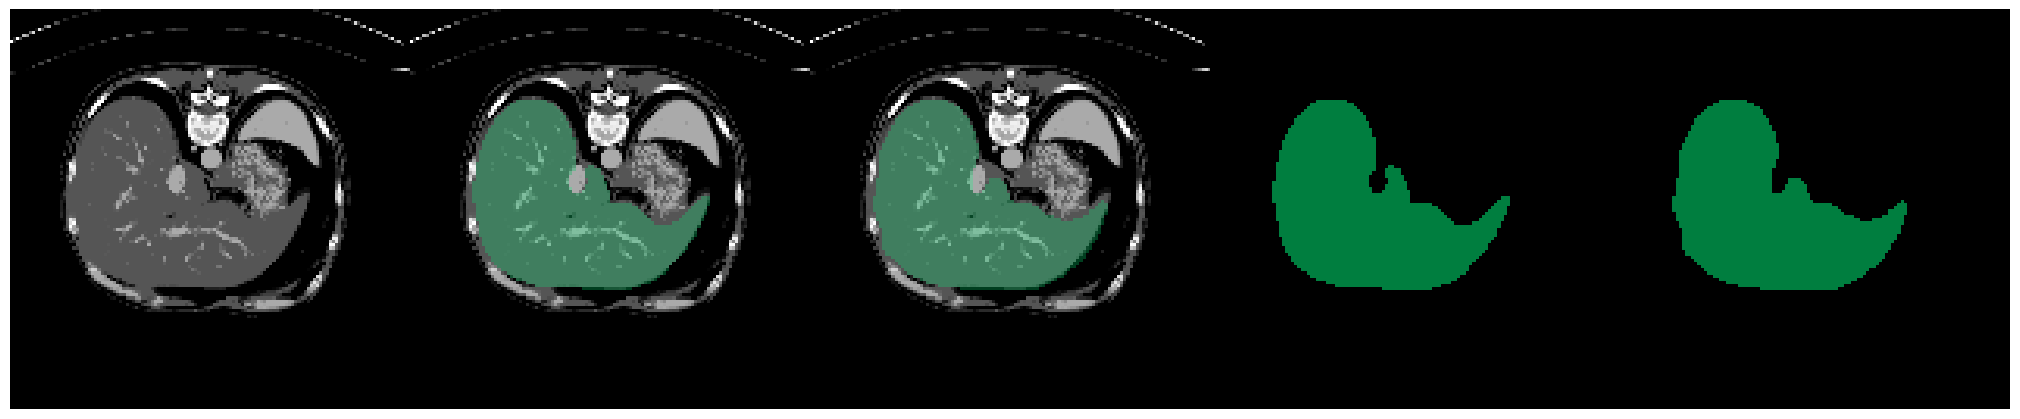

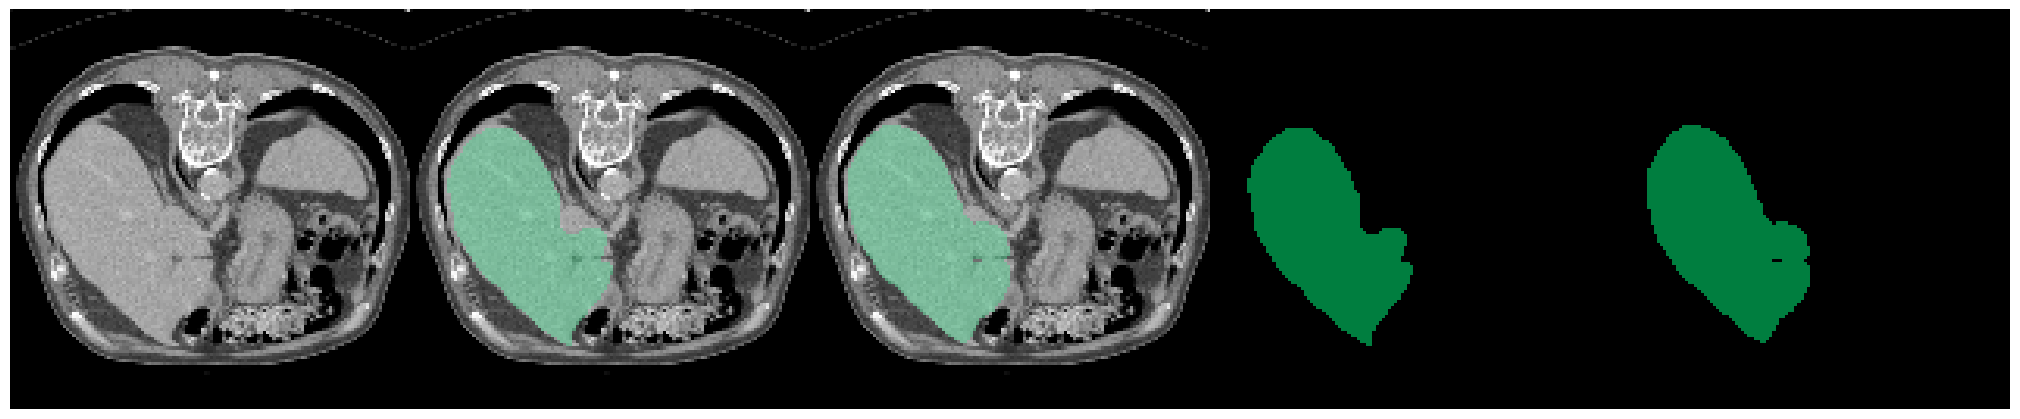

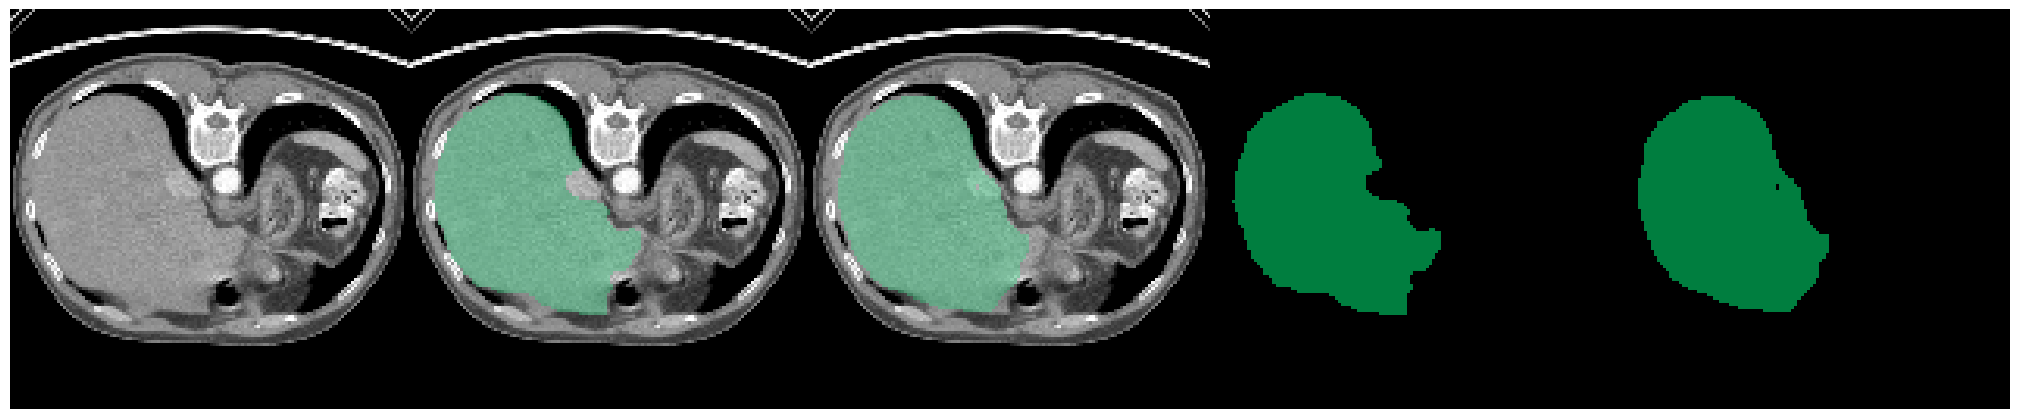

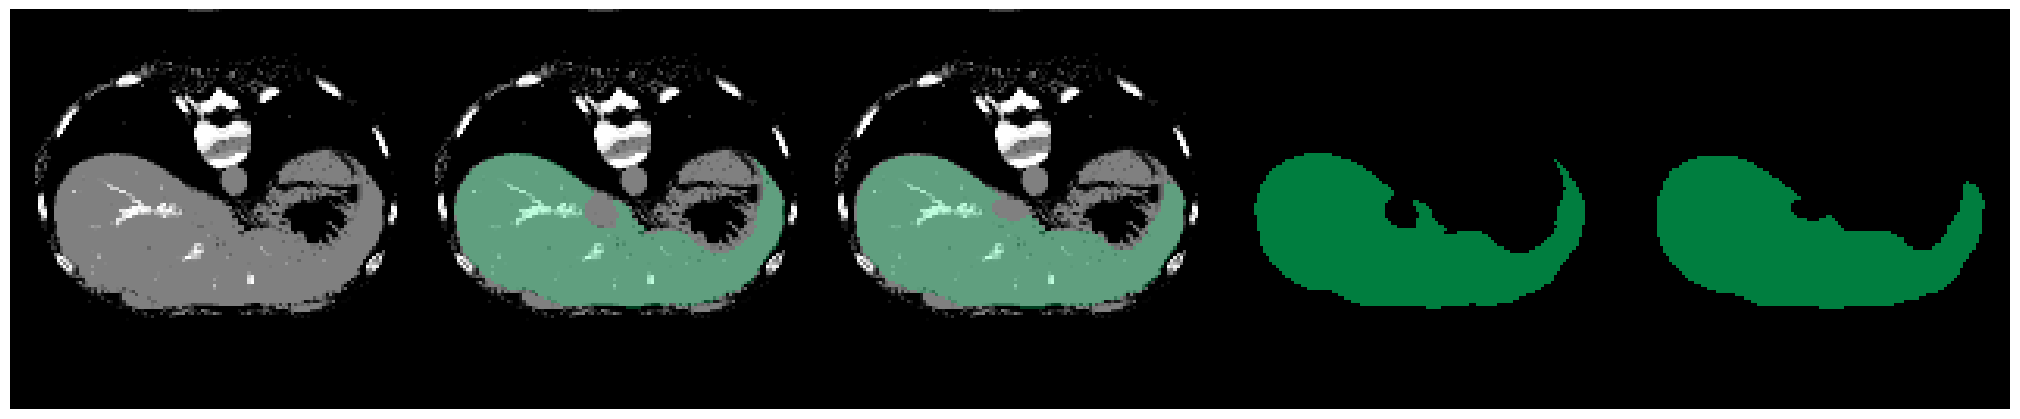

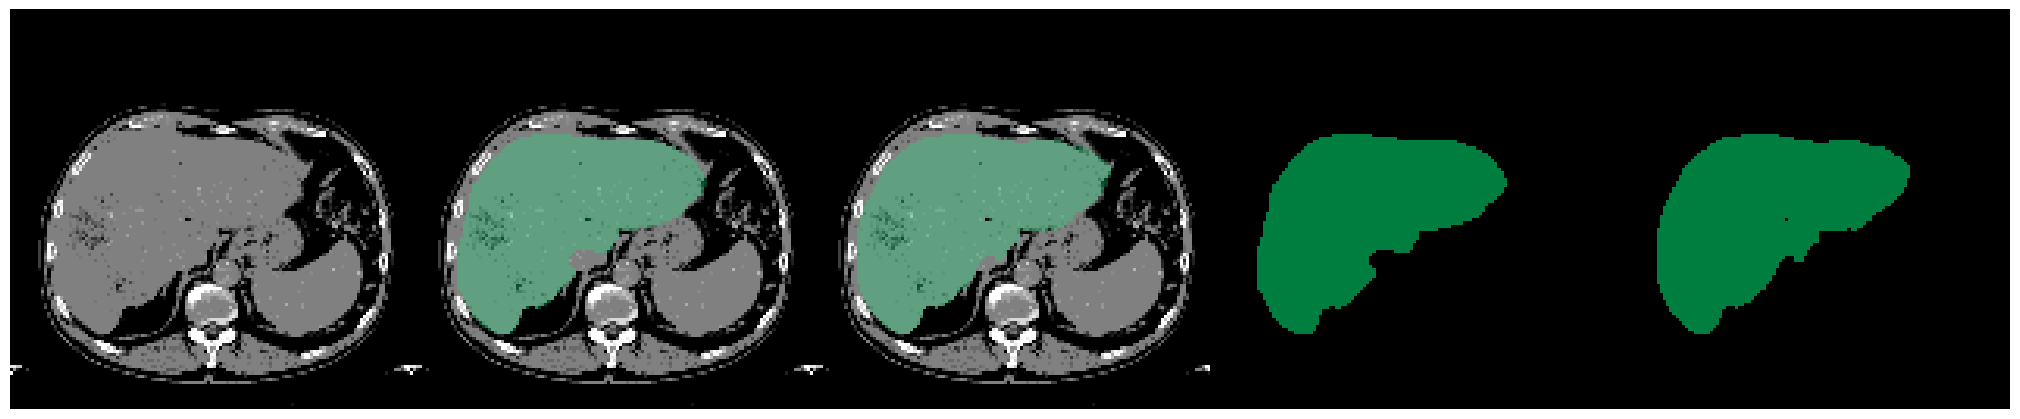

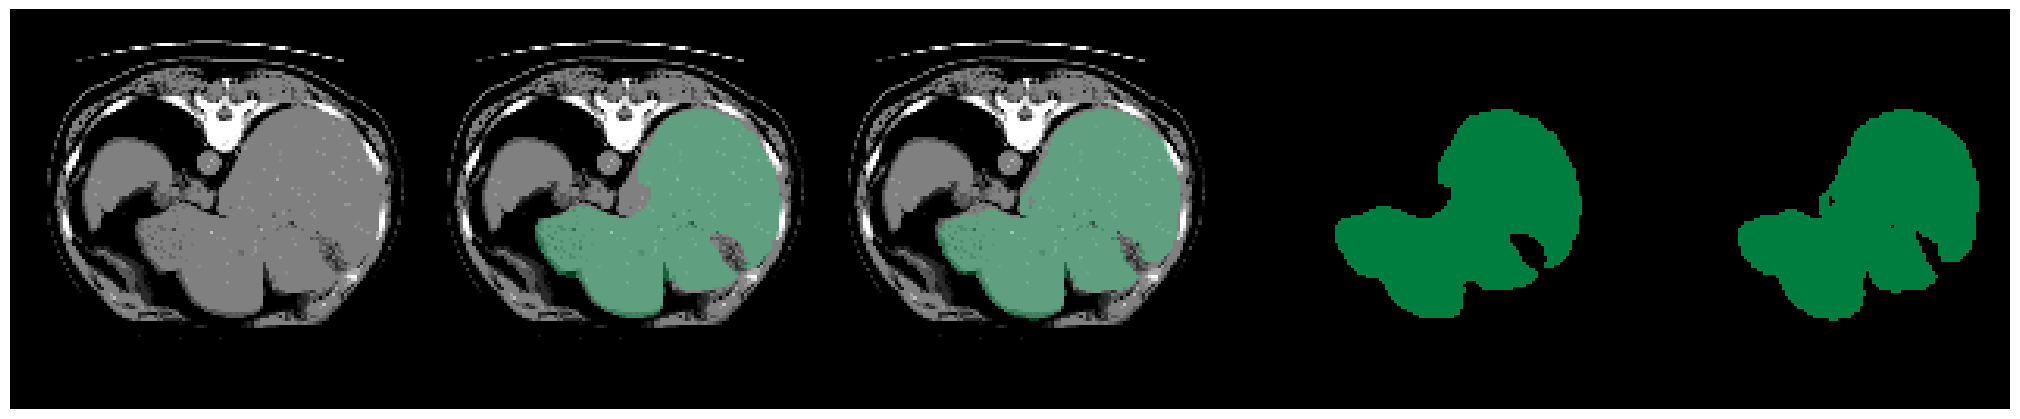

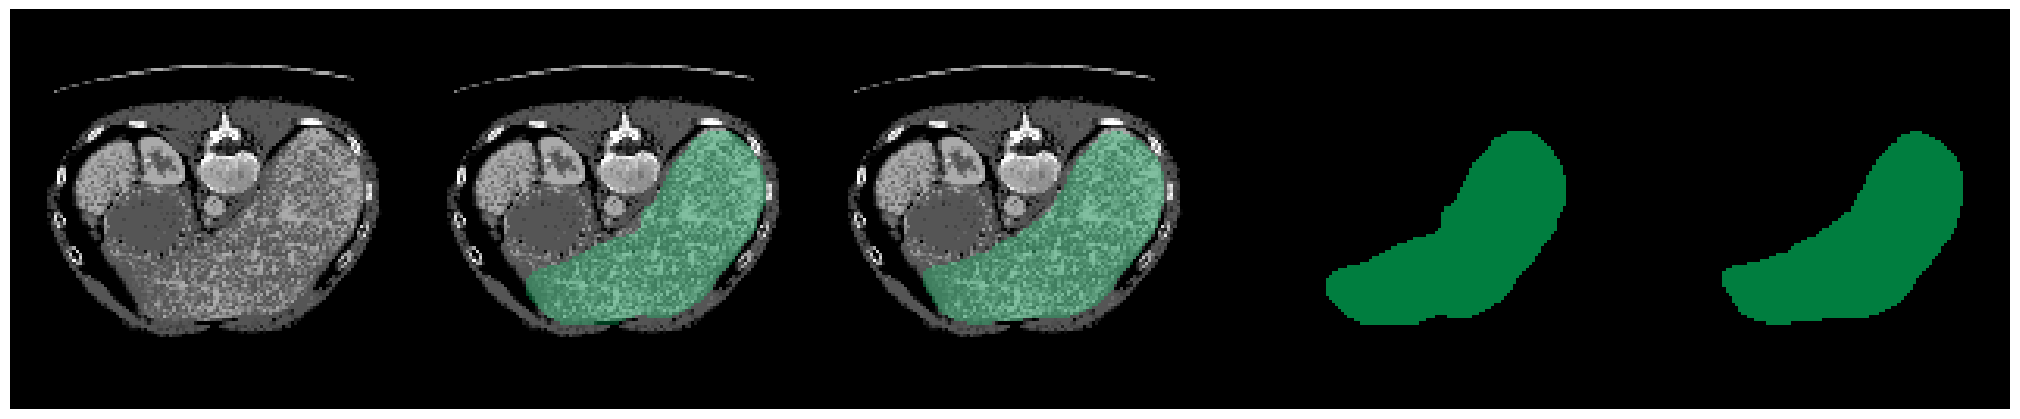

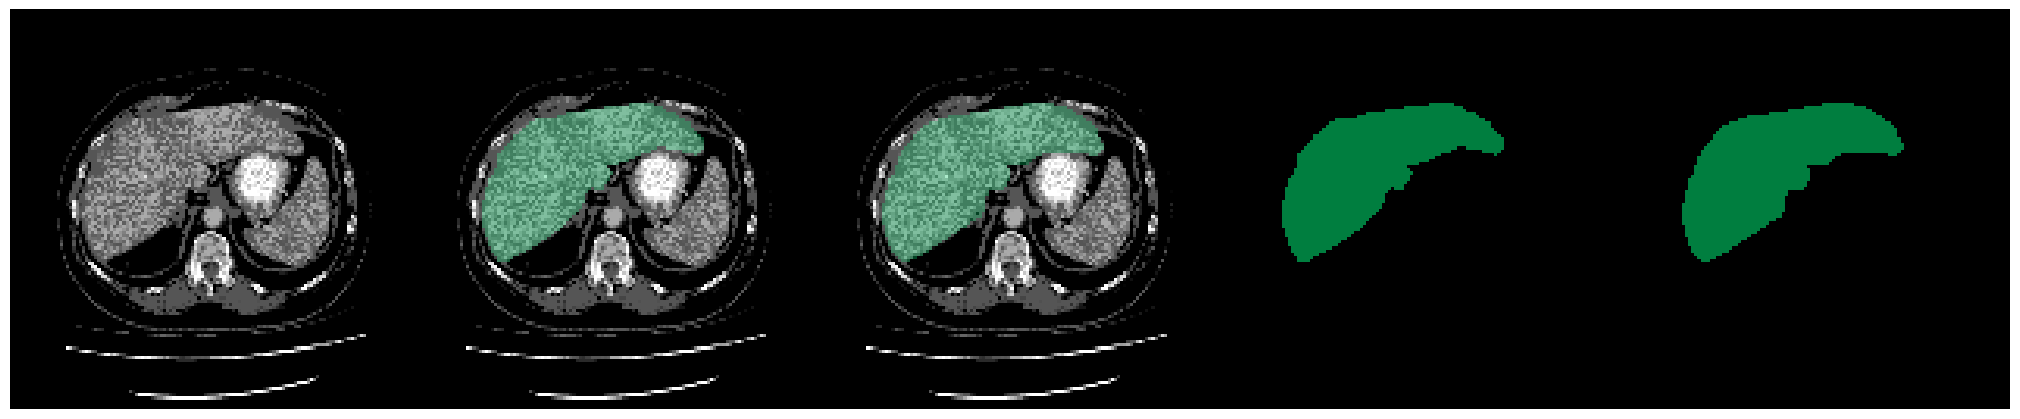

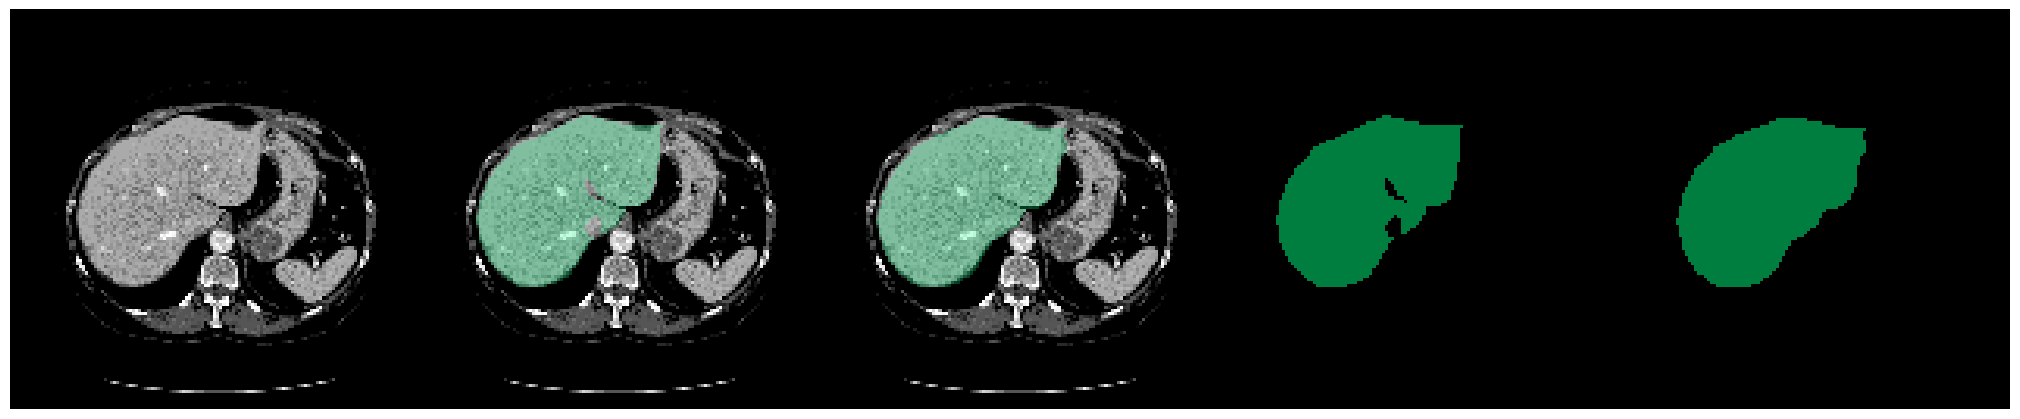

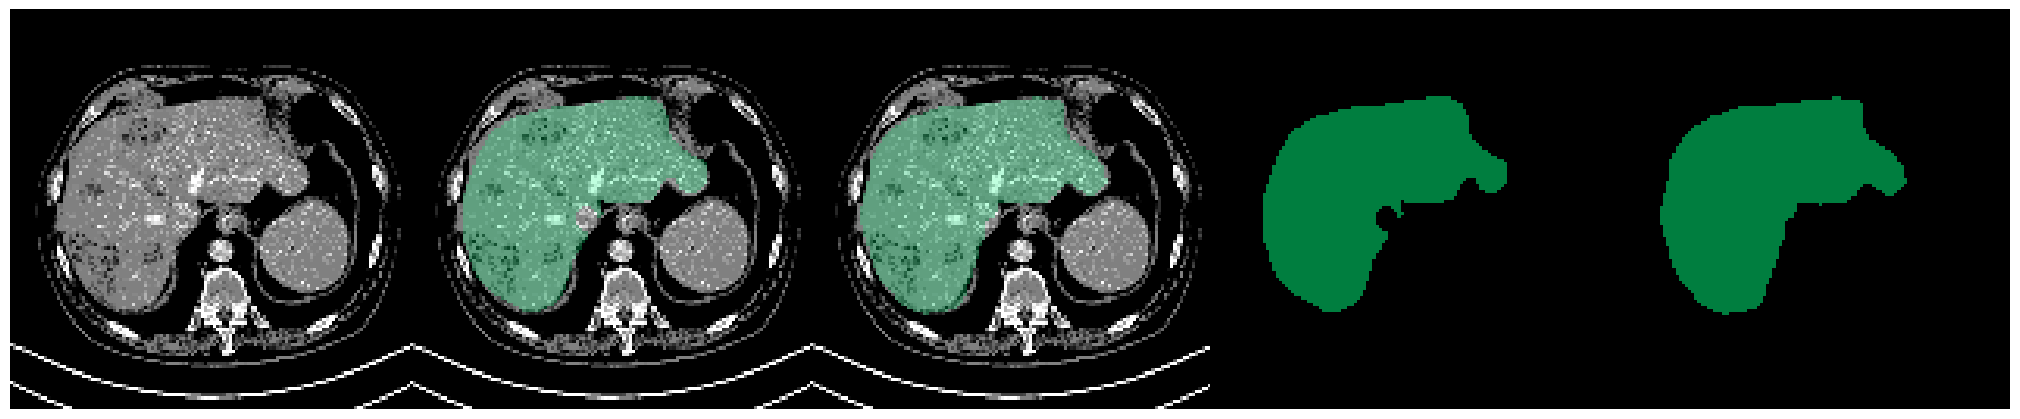

In [12]:
num_images = 10
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet_liver_mcb.pth"
visualize_results_stage_1(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [10]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [ ]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/result_model_*.json"))

['/content/gdrive/MyDrive/KLTN/code/result_model_UNet3D.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoTDA.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DPretrained_pretrained.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWConvNeXtV2CoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_1.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_2.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_2d.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver_1.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet2DWResNeXtCoT_tumor_2d_1.json', '/co

In [ ]:
model_results = load_metrics('/content/gdrive/MyDrive/KLTN/code/result_model_MSC_CoTNeXtUNet_liver_mcb.json')

max epoch: 70
max dice score: 0.9463534951210022


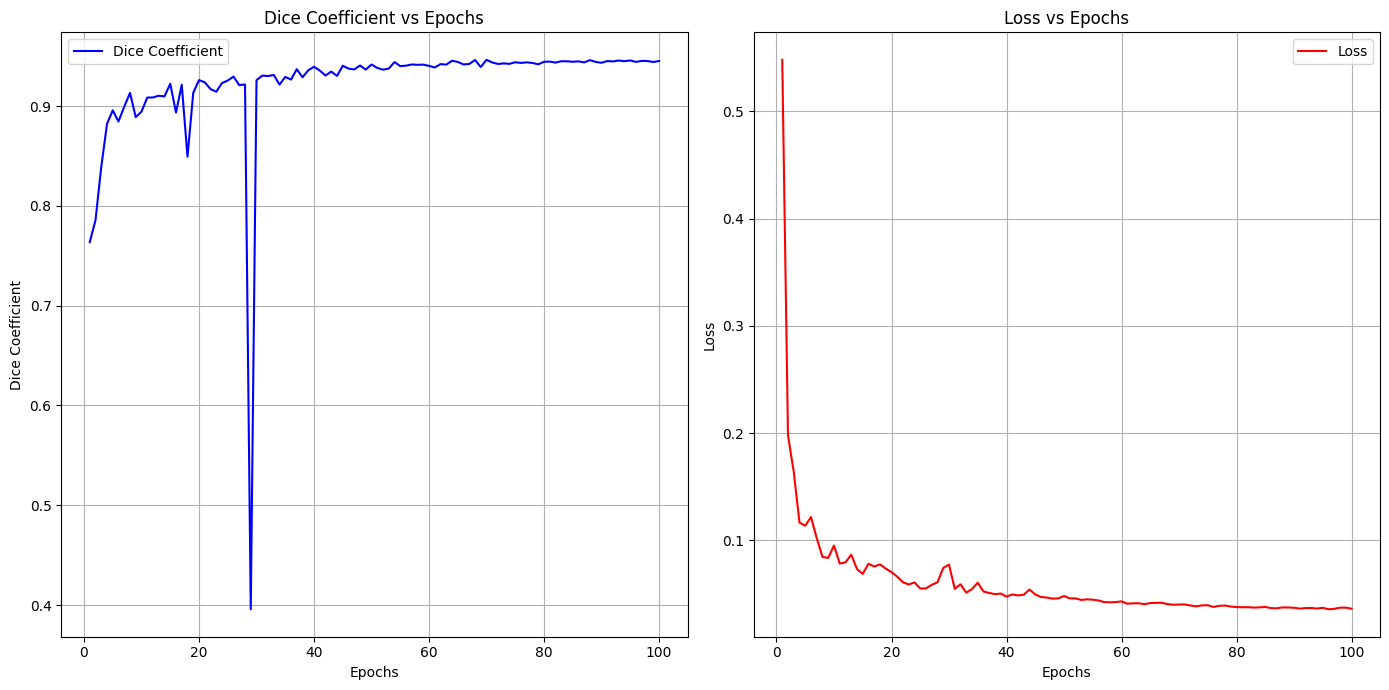

In [ ]:
epochs = list(range(1, len(model_results["dice_liver"]) + 1))
plt.figure(figsize=(14, 7))
print(f"max epoch: {model_results['best_epoch']}")
print(f"max dice score: {max(model_results['dice_liver'])}")

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_results["dice_liver"], label='Dice Coefficient', color='blue')
plt.title('Dice Coefficient vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid()

#loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_results["loss"], label='Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()